<a href="https://colab.research.google.com/github/nbilasals/indonesia_salary_forecast/blob/main/ump_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Regional Salaries (UMR) in Indonesia Using Time Series

## Project Domain

This project focuses on forecasting regional salaries in Indonesia using time series analysis. Regional salary data is important to monitor as it reflects the economic conditions of different regions and helps policymakers, businesses, and job seekers make informed decisions.

The problem arises from the lack of accessible and reliable salary forecasts, which are critical for planning workforce strategies and improving economic policies.

**Why Solve This Problem?**
1. Salary forecasting helps businesses plan recruitment budgets.
2. Policymakers can use the forecasted data to address economic gaps between regions.
3. Forecasting can help job seekers understand future trends and improve financial planning.

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import files
import os
import shutil
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

## Data Preparation

### Data Loading

In [2]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
shutil.move('kaggle.json', '~/.kaggle/kaggle.json')
!chmod 600 ~/.kaggle/kaggle.json

FileNotFoundError: [Errno 2] No such file or directory: '~/.kaggle/kaggle.json'

In [4]:
!kaggle datasets download -d linkgish/indonesian-salary-by-region-19972022

Dataset URL: https://www.kaggle.com/datasets/linkgish/indonesian-salary-by-region-19972022
License(s): GPL-2.0
  0% 0.00/5.08k [00:00<?, ?B/s]
100% 5.08k/5.08k [00:00<00:00, 11.2MB/s]


In [126]:
!unzip indonesian-salary-by-region-19972022.zip

Archive:  indonesian-salary-by-region-19972022.zip
replace Indonesian Salary by Region (1997-2022).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Indonesian Salary by Region (1997-2022).csv  


In [147]:
df = pd.read_csv("Indonesian Salary by Region (1997-2022).csv")
df

REGION   SALARY  YEAR
0              ACEH   128000  1997
1    SUMATERA UTARA   151000  1997
2    SUMATERA BARAT   119000  1997
3              RIAU   151500  1997
4             JAMBI   119500  1997
..              ...      ...   ...
865          MALUKU  2619312  2022
866    MALUKU UTARA  2862231  2022
867     PAPUA BARAT  3200000  2022
868           PAPUA  3561932  2022
869       INDONESIA  2644709  2022

[870 rows x 3 columns]

In [148]:
df['REGION'] = df['REGION'].str.title()
df

REGION   SALARY  YEAR
0              Aceh   128000  1997
1    Sumatera Utara   151000  1997
2    Sumatera Barat   119000  1997
3              Riau   151500  1997
4             Jambi   119500  1997
..              ...      ...   ...
865          Maluku  2619312  2022
866    Maluku Utara  2862231  2022
867     Papua Barat  3200000  2022
868           Papua  3561932  2022
869       Indonesia  2644709  2022

[870 rows x 3 columns]

In [149]:
# Drop rows where the 'REGION' column is 'Indonesia'
df = df[df['REGION'] != 'Indonesia']
df

REGION   SALARY  YEAR
0              Aceh   128000  1997
1    Sumatera Utara   151000  1997
2    Sumatera Barat   119000  1997
3              Riau   151500  1997
4             Jambi   119500  1997
..              ...      ...   ...
864  Sulawesi Barat  2678863  2022
865          Maluku  2619312  2022
866    Maluku Utara  2862231  2022
867     Papua Barat  3200000  2022
868           Papua  3561932  2022

[844 rows x 3 columns]

In [150]:
unique_regions = df['REGION'].unique()
unique_regions

array(['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Jambi',
       'Sumatera Selatan', 'Bengkulu', 'Lampung', 'Kep. Riau',
       'Dki Jakarta', 'Jawa Barat', 'Jawa Tengah', 'Di Yogyakarta',
       'Jawa Timur', 'Bali', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
       'Kalimantan Barat', 'Kalimantan Tengah', 'Kalimantan Selatan',
       'Kalimantan Timur', 'Sulawesi Utara', 'Sulawesi Tengah',
       'Sulawesi Selatan', 'Sulawesi Tenggara', 'Maluku', 'Papua',
       'Kep. Bangka Belitung', 'Banten', 'Gorontalo', 'Maluku Utara',
       'Sulawesi Barat', 'Papua Barat', 'Kalimantan Utara'], dtype=object)

In [151]:
import pandas as pd

# Your salary data
salary_2023_data = {
    "REGION": [
        "Aceh", "Sumatera Utara", "Sumatera Barat", "Kep. Riau", "Kep. Bangka Belitung", "Riau", "Bengkulu",
        "Sumatera Selatan", "Jambi", "Lampung", "Banten", "Dki Jakarta", "Jawa Barat", "Jawa Tengah",
        "Di Yogyakarta", "Jawa Timur", "Bali", "Nusa Tenggara Barat", "Nusa Tenggara Timur",
        "Kalimantan Barat", "Kalimantan Tengah", "Kalimantan Selatan", "Kalimantan Timur", "Kalimantan Utara",
        "Sulawesi Tengah", "Sulawesi Tenggara", "Sulawesi Utara", "Sulawesi Selatan", "Gorontalo", "Sulawesi Barat",
        "Maluku", "Maluku Utara", "Papua", "Papua Barat", "Papua Tengah", "Papua Pegunungan", "Papua Barat Daya",
        "Papua Selatan"
    ],
    "2023_Salary": [
        3413666, 2710493, 2742476, 3279194, 3498479, 3191662, 2418280, 3404177, 2943000, 2633284,
        2661280, 4900798, 1986670, 1958169, 1981782, 2040244, 2713672, 2371407, 2123994, 2608601,
        3181013, 3149977, 3201396, 3251702, 2599546, 2758984, 3485000, 3385145, 2989350, 2871794,
        2812827, 2976720, 3864696, 3282000, 3864700, 3864696, 3864696, 3864696
    ]
}

salary_2024_data = {
    "REGION": [
        "Aceh", "Sumatera Utara", "Sumatera Barat", "Kep. Riau", "Kep. Bangka Belitung", "Riau", "Bengkulu",
        "Sumatera Selatan", "Jambi", "Lampung", "Banten", "Dki Jakarta", "Jawa Barat", "Jawa Tengah",
        "Di Yogyakarta", "Jawa Timur", "Bali", "Nusa Tenggara Barat", "Nusa Tenggara Timur",
        "Kalimantan Barat", "Kalimantan Tengah", "Kalimantan Selatan", "Kalimantan Timur", "Kalimantan Utara",
        "Sulawesi Tengah", "Sulawesi Tenggara", "Sulawesi Utara", "Sulawesi Selatan", "Gorontalo", "Sulawesi Barat",
        "Maluku", "Maluku Utara", "Papua", "Papua Barat", "Papua Tengah", "Papua Pegunungan", "Papua Barat Daya",
        "Papua Selatan"
    ],
    "2024_Salary": [
        3460672, 2809915, 2811449, 3402492, 3640000, 3294625, 2507079, 3456874, 3037121, 2716497,
        2727812, 5067381, 2057495, 2036947, 2125897, 2165244, 2813672, 2444067, 2186826, 2702616,
        3261616, 3282812, 3360858, 3361653, 2736698, 2885964, 3545000, 3434298, 3025100, 2914958,
        2949953, 3200000, 4024270, 3393000, 4024270, 4024270, 4024270, 4024270
    ]
}

# Create DataFrames
df_salary_2023 = pd.DataFrame(salary_2023_data)
df_salary_2024 = pd.DataFrame(salary_2024_data)

# Merge the 2023 and 2024 salary DataFrames
df_merged = pd.merge(df_salary_2023, df_salary_2024, on="REGION", how="left")

# Melt the DataFrame to have the salary columns in one column
df_merged = pd.melt(df_merged, id_vars=["REGION"], value_vars=["2023_Salary", "2024_Salary"],
                    var_name="YEAR", value_name="SALARY")

# Clean up the 'YEAR' column to extract just the year number (remove '_Salary' part)
df_merged['YEAR'] = df_merged['YEAR'].apply(lambda x: x.split("_")[0])
df_merged

REGION  YEAR   SALARY
0                   Aceh  2023  3413666
1         Sumatera Utara  2023  2710493
2         Sumatera Barat  2023  2742476
3              Kep. Riau  2023  3279194
4   Kep. Bangka Belitung  2023  3498479
..                   ...   ...      ...
71           Papua Barat  2024  3393000
72          Papua Tengah  2024  4024270
73      Papua Pegunungan  2024  4024270
74      Papua Barat Daya  2024  4024270
75         Papua Selatan  2024  4024270

[76 rows x 3 columns]

In [152]:
# If df already exists and has similar columns (like Region, Year, Salary), ensure no conflict
# Example: If df already has data, merge it into df_merged
df = pd.concat([df, df_merged], ignore_index=True)

# Optionally sort by Region and Year for organization
df = df.sort_values(by=['REGION', 'YEAR']).reset_index(drop=True)

# Display the final DataFrame
df

REGION   SALARY  YEAR
0              Aceh   128000  1997
1              Aceh   147000  1998
2              Aceh   171000  1999
3              Aceh   265000  2000
4              Aceh   300000  2001
..              ...      ...   ...
915  Sumatera Utara  2499423  2020
916  Sumatera Utara  2499423  2021
917  Sumatera Utara  2522609  2022
918  Sumatera Utara  2710493  2023
919  Sumatera Utara  2809915  2024

[920 rows x 3 columns]

In [153]:
df.to_csv('salary_indo_19972024.csv', index=False)

### Exploratory Data Analysis

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   REGION  920 non-null    object
 1   SALARY  920 non-null    int64 
 2   YEAR    920 non-null    object
dtypes: int64(1), object(2)
memory usage: 21.7+ KB


In [155]:
df.describe().T

count          mean           std       min       25%       50%  \
SALARY  920.0  1.337366e+06  1.040074e+06  106000.0  447838.5  987000.0   

               75%        max  
SALARY  2136641.75  5067381.0

In [156]:
# Average salary per region
region_salary = df.groupby('REGION')['SALARY'].mean().sort_values(ascending=False)
region_salary

REGION
Papua Tengah            3.944485e+06
Papua Selatan           3.944483e+06
Papua Barat Daya        3.944483e+06
Papua Pegunungan        3.944483e+06
Kalimantan Utara        2.751733e+06
Papua Barat             2.114187e+06
Dki Jakarta             2.004255e+06
Papua                   1.713855e+06
Sulawesi Barat          1.713196e+06
Sulawesi Utara          1.536358e+06
Aceh                    1.523649e+06
Kep. Bangka Belitung    1.482319e+06
Sulawesi Selatan        1.451031e+06
Sumatera Selatan        1.432444e+06
Kep. Riau               1.414191e+06
Riau                    1.399660e+06
Kalimantan Tengah       1.393911e+06
Kalimantan Timur        1.387151e+06
Kalimantan Selatan      1.379524e+06
Maluku Utara            1.285294e+06
Jambi                   1.281550e+06
Gorontalo               1.265149e+06
Sumatera Utara          1.264948e+06
Banten                  1.257235e+06
Sumatera Barat          1.234066e+06
Maluku                  1.223535e+06
Sulawesi Tenggara       1.209440e+06
Bali                    1.195225e+06
Lampung                 1.144382e+06
Kalimantan Barat        1.139852e+06
Sulawesi Tengah         1.124670e+06
Bengkulu                1.105200e+06
Nusa Tenggara Barat     1.070001e+06
Nusa Tenggara Timur     9.852257e+05
Jawa Barat              9.283125e+05
Di Yogyakarta           8.794189e+05
Jawa Timur              8.630648e+05
Jawa Tengah             8.491244e+05
Name: SALARY, dtype: float64

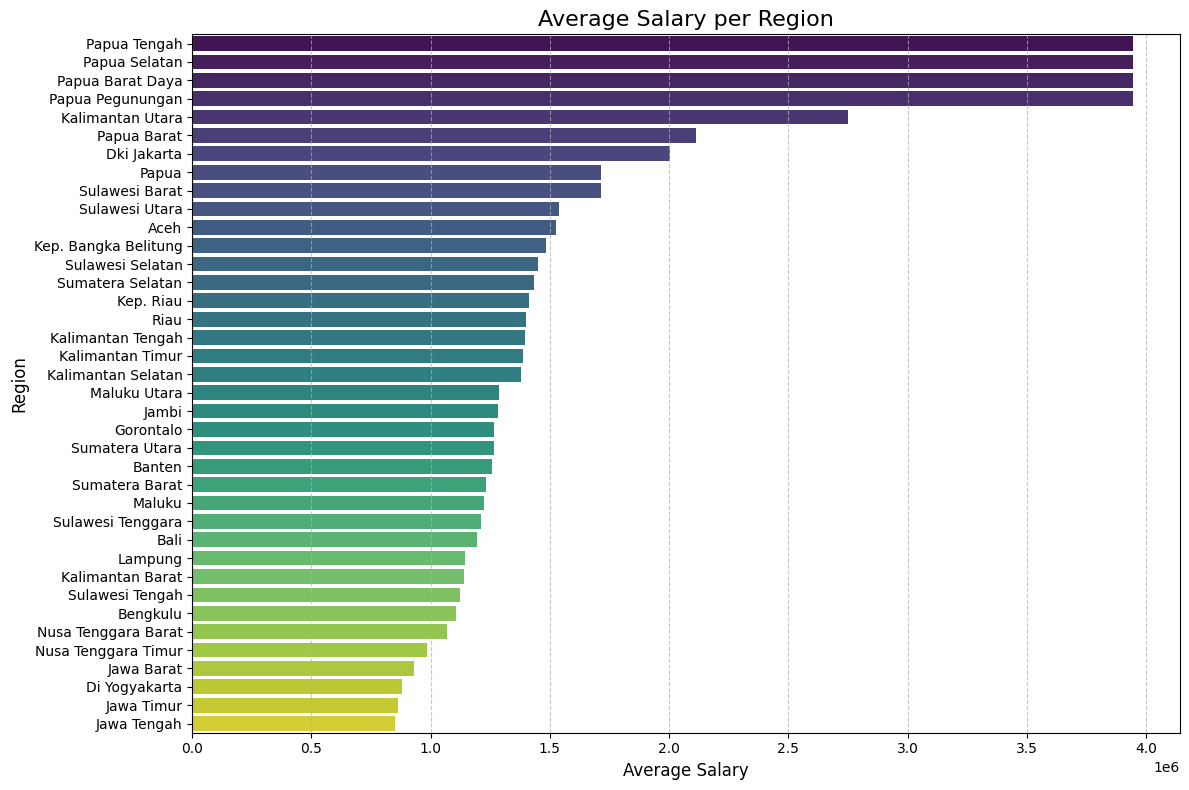

In [157]:
# Average salary per region visualization
plt.figure(figsize=(12, 8))
sns.barplot(x=region_salary.values, y=region_salary.index, palette="viridis")

# Adding labels and title
plt.title('Average Salary per Region', fontsize=16)
plt.xlabel('Average Salary', fontsize=12)
plt.ylabel('Region', fontsize=12)

# Improve readability with grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [158]:
# Yearly trends
yearly_trend = df.groupby('YEAR')['SALARY'].mean()
yearly_trend

YEAR
1997    1.349630e+05
1998    1.509387e+05
1999    1.753903e+05
2000    2.165065e+05
2001    2.904871e+05
2002    3.646419e+05
2003    4.149355e+05
2004    4.573097e+05
2005    5.076968e+05
2006    6.093625e+05
2007    6.820114e+05
2008    7.566119e+05
2009    8.415295e+05
2010    9.088245e+05
2011    9.888294e+05
2012    1.088903e+06
2013    1.296908e+06
2014    1.510464e+06
2015    1.694375e+06
2016    1.906790e+06
2017    2.020501e+06
2018    2.268874e+06
2019    2.455662e+06
2020    2.672371e+06
2021    2.684743e+06
2022    2.722436e+06
2023    3.022375e+06
2024    3.129946e+06
Name: SALARY, dtype: float64

<Figure size 1000x600 with 0 Axes>

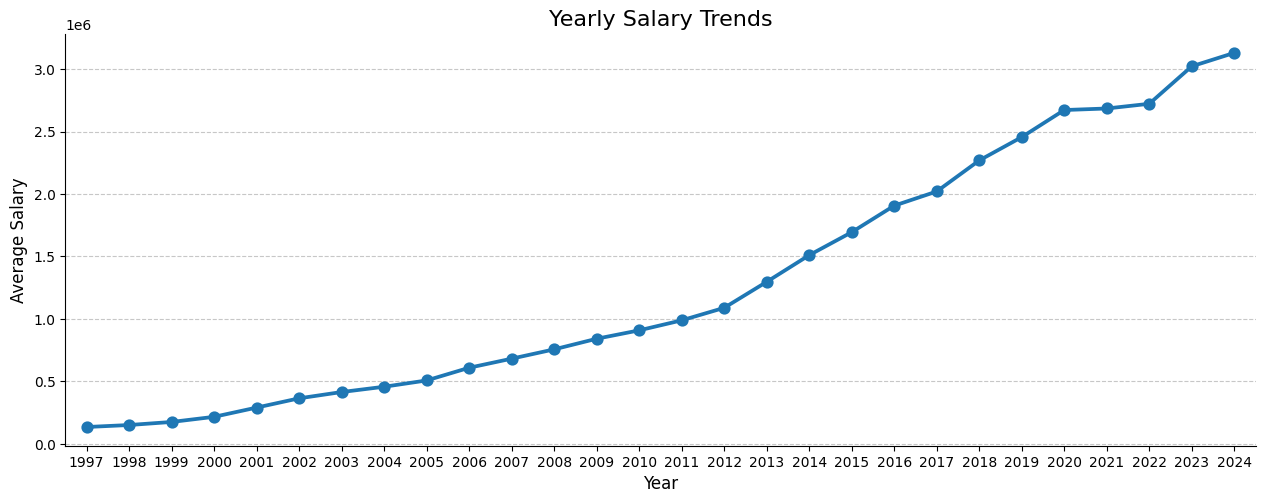

In [159]:
# Yearly trend
plt.figure(figsize=(10, 6))
sns.catplot(x=yearly_trend.index, y=yearly_trend.values, marker='o',kind='point',aspect=2.5)

# Adding labels and title
plt.title('Yearly Salary Trends', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)

# Improve readability with grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [160]:
# Calculate salary growth of country by year

# Calculate the average salary per year for the entire country
avg = df.groupby('YEAR', as_index=False)['SALARY'].mean()

# Calculate yearly salary growth
avg['growth'] = avg['SALARY'].diff()  # Year-to-year growth
avg

YEAR        SALARY         growth
0   1997  1.349630e+05            NaN
1   1998  1.509387e+05   15975.746714
2   1999  1.753903e+05   24451.612903
3   2000  2.165065e+05   41116.129032
4   2001  2.904871e+05   73980.645161
5   2002  3.646419e+05   74154.838710
6   2003  4.149355e+05   50293.548387
7   2004  4.573097e+05   42374.193548
8   2005  5.076968e+05   50387.129032
9   2006  6.093625e+05  101665.648094
10  2007  6.820114e+05   72648.909091
11  2008  7.566119e+05   74600.575758
12  2009  8.415295e+05   84917.606061
13  2010  9.088245e+05   67294.969697
14  2011  9.888294e+05   80004.878788
15  2012  1.088903e+06  100073.242424
16  2013  1.296908e+06  208005.848485
17  2014  1.510464e+06  213555.696970
18  2015  1.694375e+06  183910.935829
19  2016  1.906790e+06  212415.382353
20  2017  2.020501e+06  113710.323529
21  2018  2.268874e+06  248373.411765
22  2019  2.455662e+06  186787.970588
23  2020  2.672371e+06  216708.617647
24  2021  2.684743e+06   12372.235294
25  2022  2.722436e+06   37692.647059
26  2023  3.022375e+06  299939.715170
27  2024  3.129946e+06  107570.394737

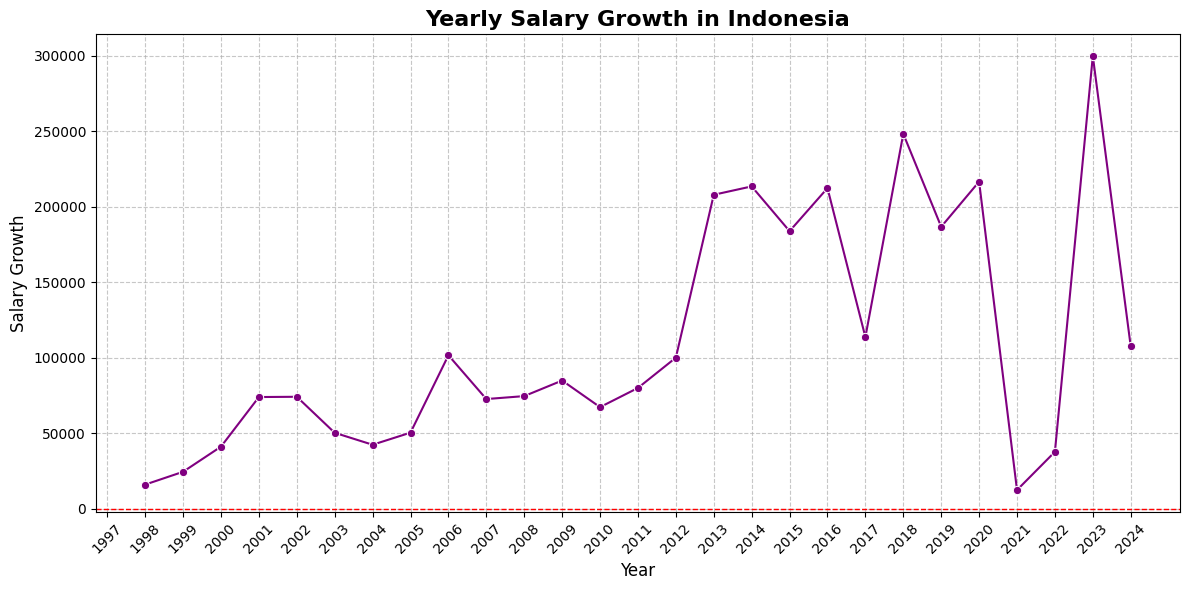

In [161]:
# Plotting salary growth
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg, x='YEAR', y='growth', marker='o', color='purple')

# Adding labels and title
plt.title('Yearly Salary Growth in Indonesia', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Salary Growth', fontsize=12)

# Adding gridlines for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Highlight zero growth line
plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Customize tick parameters
# Convert 'YEAR' column to numeric
# This assumes 'YEAR' contains values that can be converted to integers
avg['YEAR'] = pd.to_numeric(avg['YEAR'])
plt.xticks(avg['YEAR'], rotation=45, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

From the chart above, we can see that 2018 had the highest average UMP (Provincial Minimum Wage) in the observed period, followed by 2020 and 2014. On the other hand, the lowest UMP values occurred in 2021, with 1998 and 1999 not far behind. This sharp decline in 2021 can likely be attributed to the economic impacts of the COVID-19 pandemic, which disrupted labor markets and led to wage stagnation. Similarly, the dip in 1998 and 1999 corresponds with the financial crisis that severely affected Indonesia's economy, pushing wages to their lowest point in recent history. These events highlight how external factors, such as global pandemics and financial crises, can deeply influence regional wage trends.

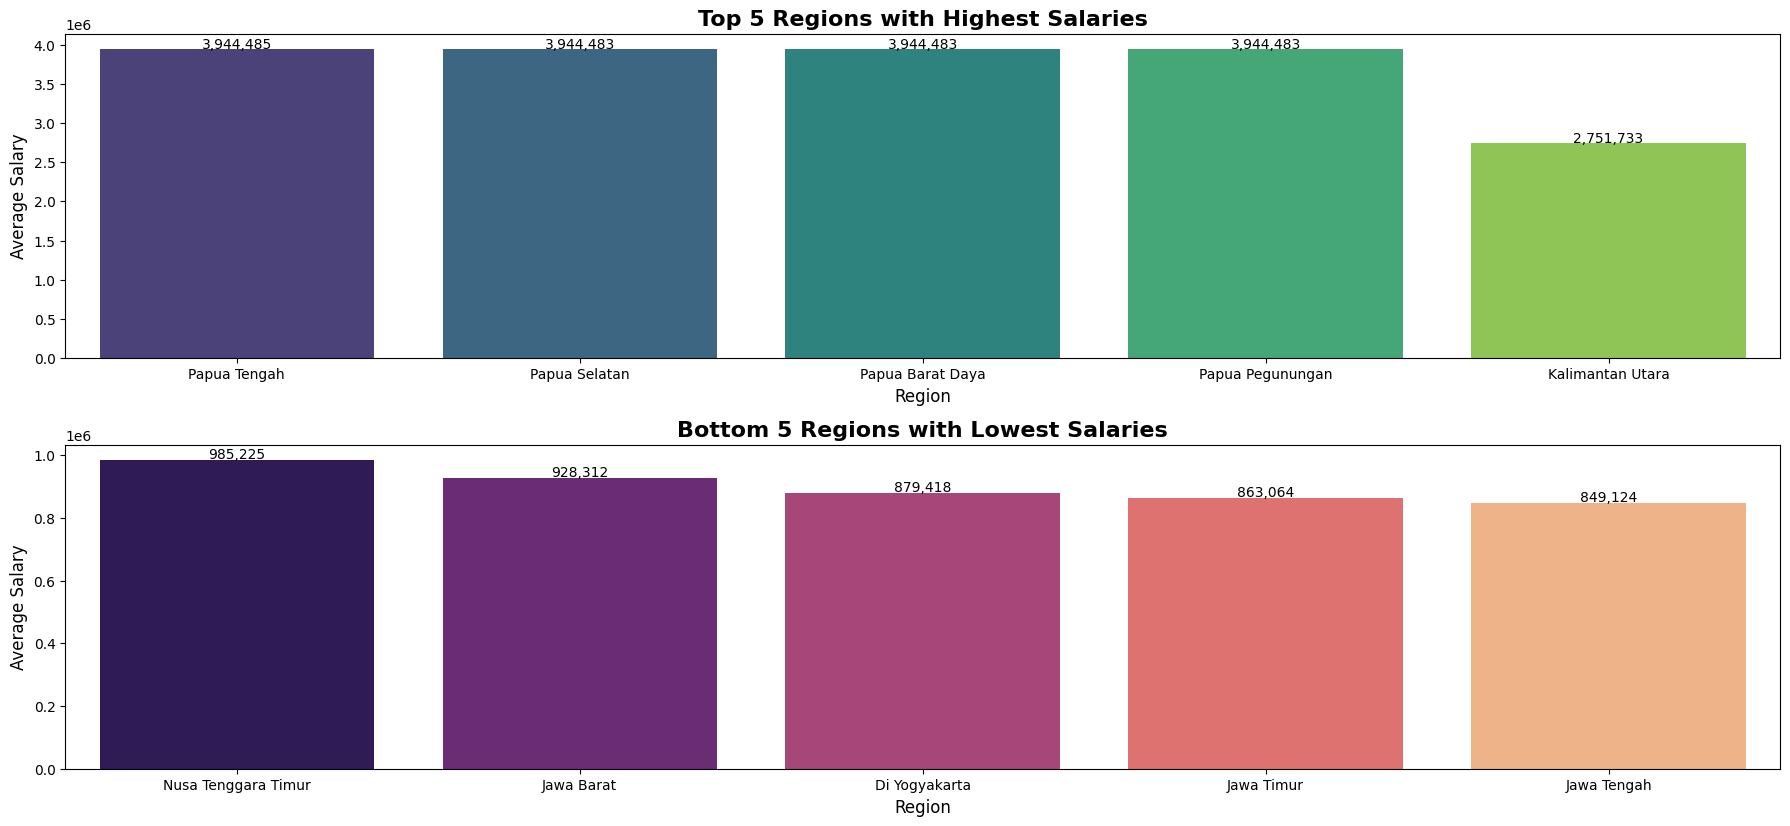

In [162]:
# Calculate the average salary per region
region_salary = df.groupby('REGION')['SALARY'].mean().sort_values(ascending=False)

# Get top 5 and bottom 5 regions
top_5_regions = region_salary.head(5)
bottom_5_regions = region_salary.tail(5)

# Full chart data
sorted_regions = region_salary.reset_index()

# Plotting
plt.figure(figsize=(18, 12))

# Subplot 1: Top 5 regions
plt.subplot(3, 1, 1)
sns.barplot(x=top_5_regions.index, y=top_5_regions.values, palette='viridis')
plt.title('Top 5 Regions with Highest Salaries', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
for i, v in enumerate(top_5_regions.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

# Subplot 2: Bottom 5 regions
plt.subplot(3, 1, 2)
sns.barplot(x=bottom_5_regions.index, y=bottom_5_regions.values, palette='magma')
plt.title('Bottom 5 Regions with Lowest Salaries', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
for i, v in enumerate(bottom_5_regions.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

From 1997 to 2015, there were province expansions, and the minimum wage (UMR) data for each year was inconsistent, which makes it irrelevant for analysis.

To obtain accurate and relevant results in the minimum wage (UMR) calculation, we will focus on data from the last 7 years, which is from 2017 to 2024. During this period, the minimum wage (UMR) figures for each year are consistent, and this will serve as the basis for the most current and relevant minimum wage analysis.

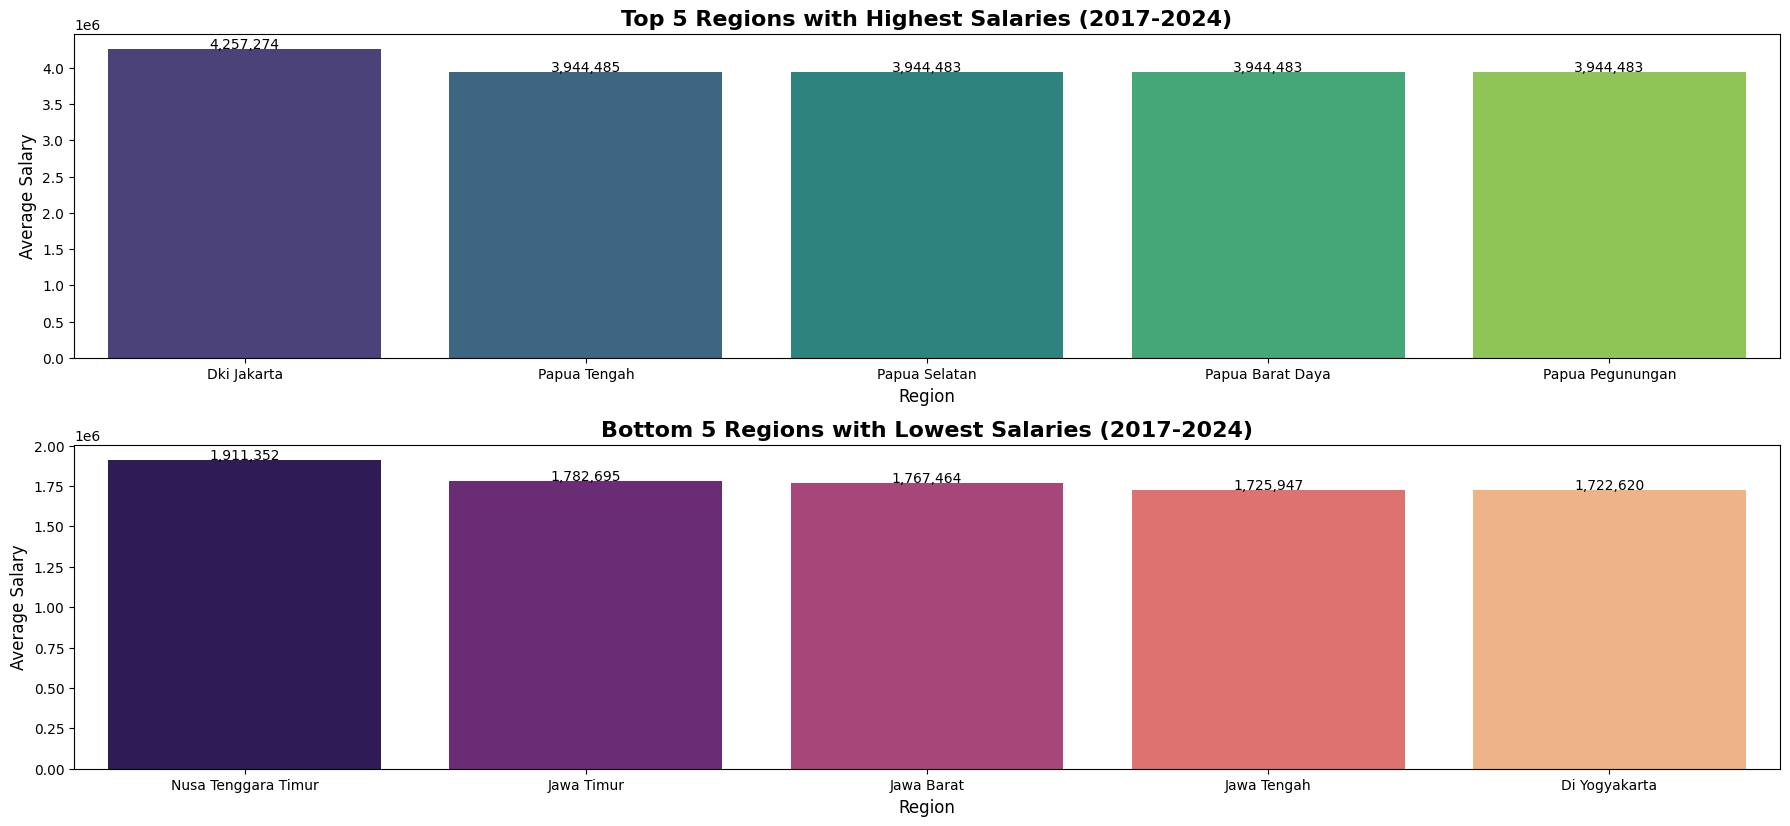

In [183]:
# Filter data for the year above 2017
df_filtered = df[(df['YEAR'].astype(int) >= 2017)]

# Calculate the average salary per region for 2022
region_salary_2024 = df_filtered.groupby('REGION')['SALARY'].mean().sort_values(ascending=False)

# Get top 5 and bottom 5 regions
top_5_regions_2024 = region_salary_2024.head(5)
bottom_5_regions_2024 = region_salary_2024.tail(5)

# Full chart data (sorted)
sorted_regions_2024 = region_salary_2024.reset_index()

# Plotting
plt.figure(figsize=(18, 12))

# Subplot 1: Top 5 regions for 2017-2024
plt.subplot(3, 1, 1)
sns.barplot(x=top_5_regions_2024.index, y=top_5_regions_2024.values, palette='viridis')
plt.title('Top 5 Regions with Highest Salaries (2017-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
for i, v in enumerate(top_5_regions_2024.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

# Subplot 2: Bottom 5 regions for 2017-2024
plt.subplot(3, 1, 2)
sns.barplot(x=bottom_5_regions_2024.index, y=bottom_5_regions_2024.values, palette='magma')
plt.title('Bottom 5 Regions with Lowest Salaries (2017-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
for i, v in enumerate(bottom_5_regions_2022.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [164]:
#Salary Distribution by Region Over the Year
import plotly.express as px

fig = px.bar(
    df,
    x='REGION',
    y="SALARY",
    color="REGION",  # Color by REGION
    animation_frame="YEAR",  # Animate over the years
    range_y=[0, 4766460],  # Set the y-axis range for better scaling
    title="Salary Distribution by Region Over the Years",  # Add title
    labels={"SALARY": "Average Salary", "REGION": "Region"},  # Customize axis labels
    color_continuous_scale='Viridis',  # Use a continuous color scale
    animation_group="REGION",  # Ensure that each region animates individually
    category_orders={"REGION": sorted(df["REGION"].unique())},  # Sort regions alphabetically
)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Region",
    yaxis_title="Average Salary",
    title_x=0.5,  # Center the title
    showlegend=False,  # Disable legend if not necessary
    height=600  # Adjust the figure height for better viewing
)

# Show the figure
fig.show()


In [165]:
# Normalize the REGION column to title case for consistent mapping
df['REGION'] = df['REGION'].str.title()

# Mapping provinces to their respective islands
island_map = {
    'Dki Jakarta': 'Jawa', 'Banten': 'Jawa', 'Jawa Barat': 'Jawa', 'Jawa Tengah': 'Jawa', 'Jawa Timur': 'Jawa', 'Di Yogyakarta': 'Jawa',
    'Aceh': 'Sumatera', 'Sumatera Utara': 'Sumatera', 'Sumatera Barat': 'Sumatera', 'Riau': 'Sumatera', 'Kep. Riau': 'Sumatera', 'Jambi': 'Sumatera',
    'Bengkulu': 'Sumatera', 'Sumatera Selatan': 'Sumatera', 'Kep. Bangka Belitung': 'Sumatera', 'Lampung': 'Sumatera',
    'Kalimantan Barat': 'Kalimantan', 'Kalimantan Utara': 'Kalimantan', 'Kalimantan Timur': 'Kalimantan', 'Kalimantan Selatan': 'Kalimantan', 'Kalimantan Tengah': 'Kalimantan',
    'Sulawesi Barat': 'Sulawesi', 'Sulawesi Utara': 'Sulawesi', 'Sulawesi Tenggara': 'Sulawesi', 'Sulawesi Selatan': 'Sulawesi', 'Sulawesi Tengah': 'Sulawesi', 'Gorontalo': 'Sulawesi',
    'Bali': 'Kepulauan Sunda Kecil', 'Nusa Tenggara Barat': 'Kepulauan Sunda Kecil', 'Nusa Tenggara Timur': 'Kepulauan Sunda Kecil',
    'Maluku': 'Kepulauan Maluku', 'Maluku Utara': 'Kepulauan Maluku',
    'Papua': 'Papua', 'Papua Barat': 'Papua'
}

# Add a new column to map each region to its respective island
df['ISLAND'] = df['REGION'].map(island_map)
df

REGION   SALARY  YEAR    ISLAND
0              Aceh   128000  1997  Sumatera
1              Aceh   147000  1998  Sumatera
2              Aceh   171000  1999  Sumatera
3              Aceh   265000  2000  Sumatera
4              Aceh   300000  2001  Sumatera
..              ...      ...   ...       ...
915  Sumatera Utara  2499423  2020  Sumatera
916  Sumatera Utara  2499423  2021  Sumatera
917  Sumatera Utara  2522609  2022  Sumatera
918  Sumatera Utara  2710493  2023  Sumatera
919  Sumatera Utara  2809915  2024  Sumatera

[920 rows x 4 columns]

In [167]:
df['REGION'].unique()

array(['Aceh', 'Bali', 'Banten', 'Bengkulu', 'Di Yogyakarta',
       'Dki Jakarta', 'Gorontalo', 'Jambi', 'Jawa Barat', 'Jawa Tengah',
       'Jawa Timur', 'Kalimantan Barat', 'Kalimantan Selatan',
       'Kalimantan Tengah', 'Kalimantan Timur', 'Kalimantan Utara',
       'Kep. Bangka Belitung', 'Kep. Riau', 'Lampung', 'Maluku',
       'Maluku Utara', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
       'Papua', 'Papua Barat', 'Papua Barat Daya', 'Papua Pegunungan',
       'Papua Selatan', 'Papua Tengah', 'Riau', 'Sulawesi Barat',
       'Sulawesi Selatan', 'Sulawesi Tengah', 'Sulawesi Tenggara',
       'Sulawesi Utara', 'Sumatera Barat', 'Sumatera Selatan',
       'Sumatera Utara'], dtype=object)

### Plot the salary distribution per region within each island

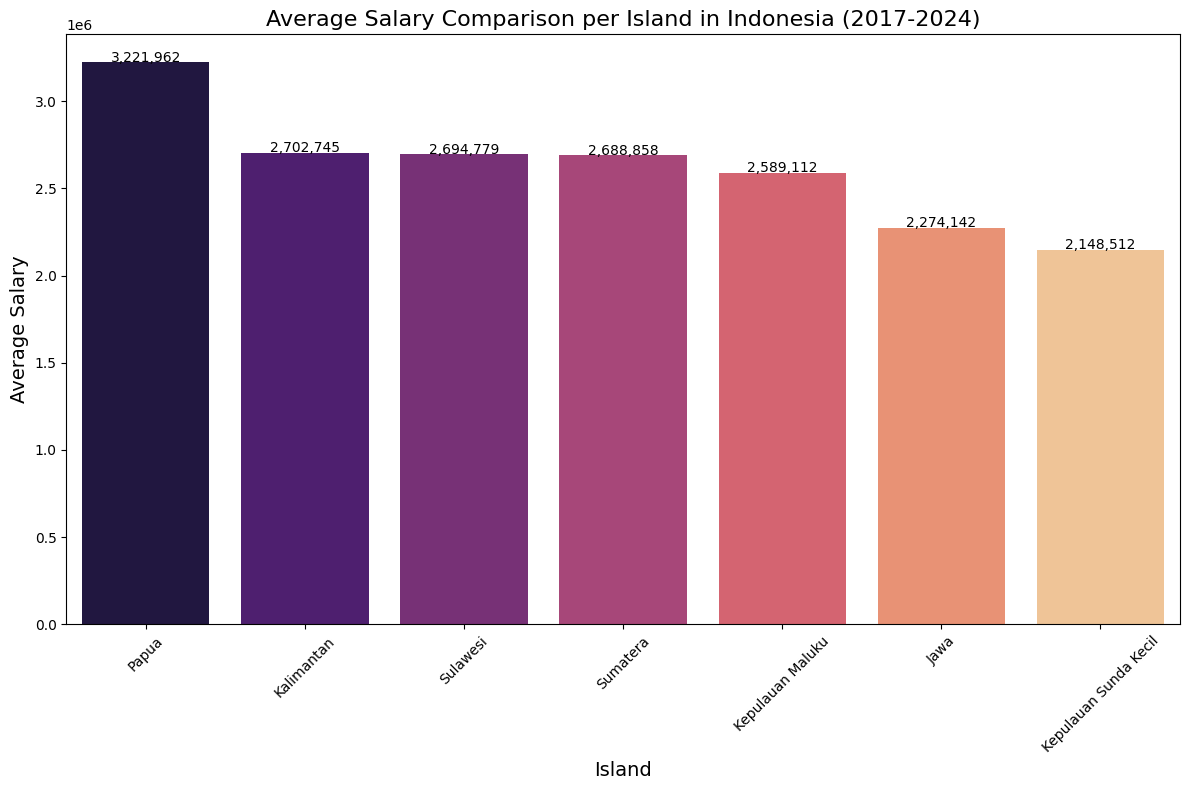

In [170]:
# Calculate the average salary per island for the years 2017-2022
island_salary_filtered = df_filtered.groupby('ISLAND')['SALARY'].mean().sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x=island_salary_filtered.index, y=island_salary_filtered.values, palette='magma')

# Customize the chart
plt.title('Average Salary Comparison per Island in Indonesia (2017-2024)', fontsize=16)
plt.xlabel('Island', fontsize=14)
plt.ylabel('Average Salary', fontsize=14)
plt.xticks(rotation=45)

# Add salary annotations on bars
for i, v in enumerate(island_salary_filtered.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

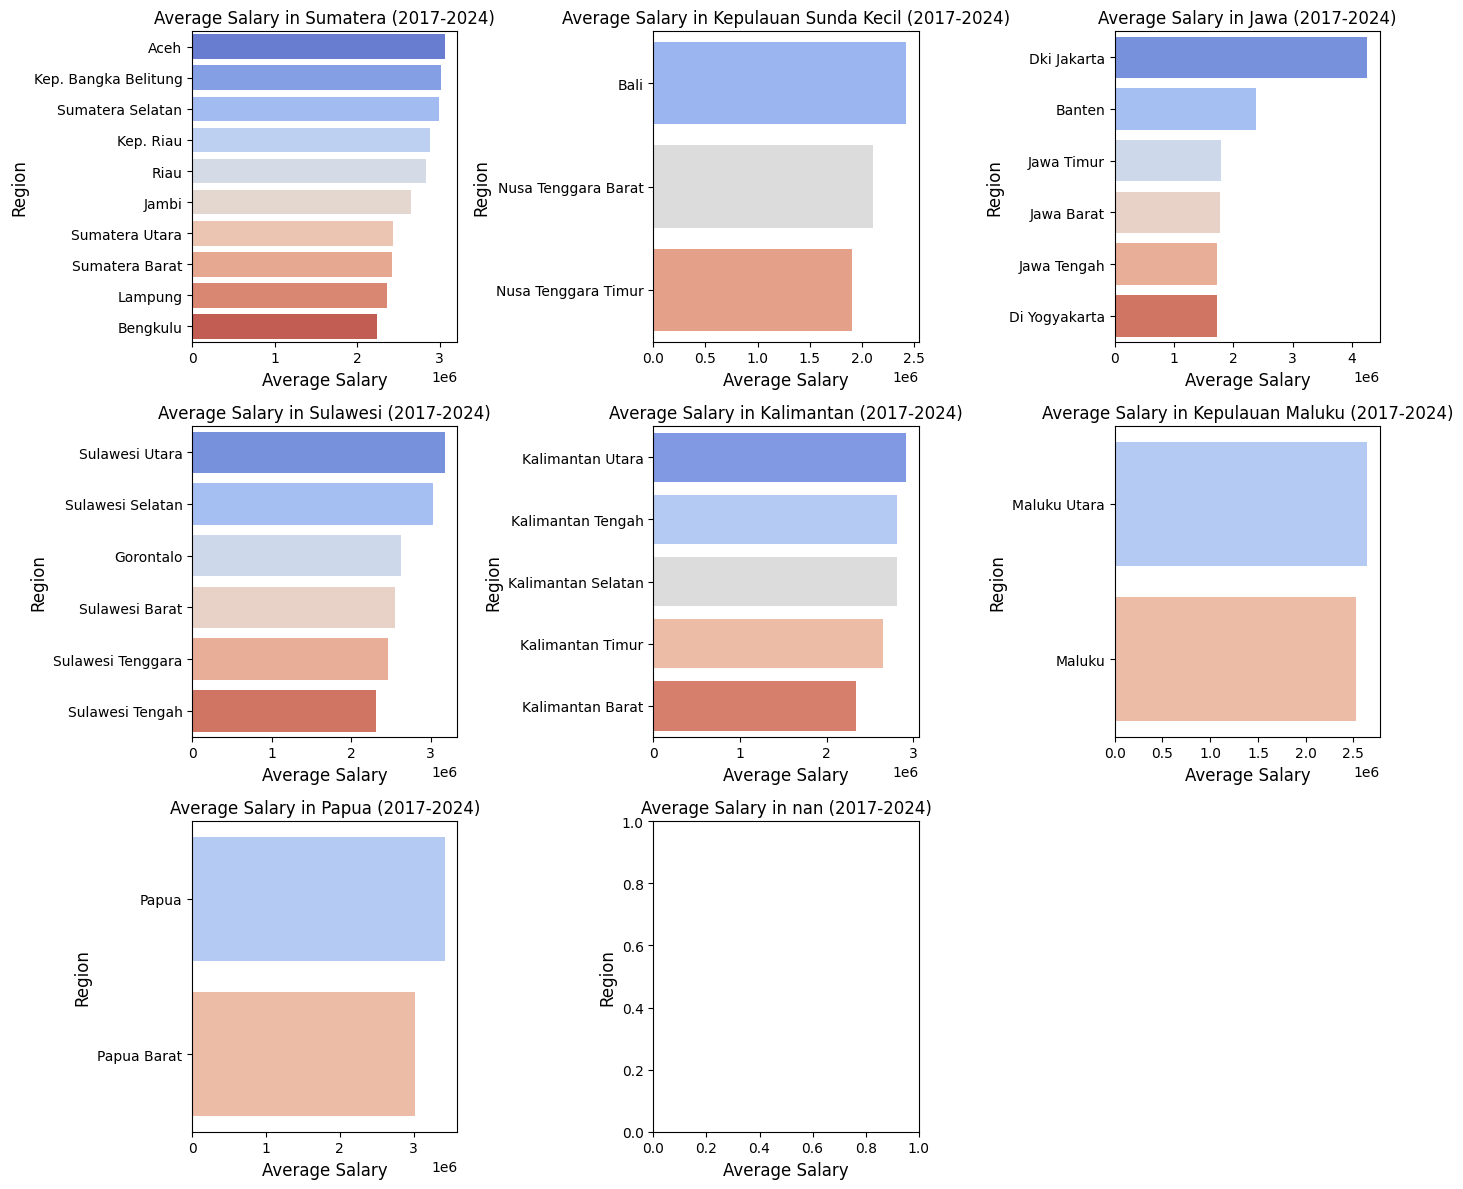

In [178]:
# List of islands to loop through and create individual charts
islands = df_filtered['ISLAND'].unique()

# Create a plot for each island
plt.figure(figsize=(14, 12))
for i, island in enumerate(islands, 1):
    plt.subplot(3, 3, i)  # Create a 3x3 grid for the subplots
    island_data = df_filtered[df_filtered['ISLAND'] == island]

    # Calculate the average salary per region and sort in ascending order
    avg_salary = island_data.groupby('REGION')['SALARY'].mean().sort_values(ascending=False)

    # Plotting the sorted average salary using horizontal barplot
    sns.barplot(y=avg_salary.index, x=avg_salary.values, palette='coolwarm', ci=None)

    plt.title(f'Average Salary in {island} (2017-2024)', fontsize=12)
    plt.xlabel('Average Salary', fontsize=12)
    plt.ylabel('Region', fontsize=12)

plt.tight_layout()
plt.show()

## Modelling

### 1. Forecast Salary for Jakarta

In [187]:
df_jakarta = df[df["REGION"] == "Dki Jakarta"]
df_jakarta

REGION   SALARY  YEAR ISLAND
139  Dki Jakarta   172500  1997   Jawa
140  Dki Jakarta   198500  1998   Jawa
141  Dki Jakarta   231000  1999   Jawa
142  Dki Jakarta   286000  2000   Jawa
143  Dki Jakarta   426300  2001   Jawa
144  Dki Jakarta   591300  2002   Jawa
145  Dki Jakarta   631600  2003   Jawa
146  Dki Jakarta   671600  2004   Jawa
147  Dki Jakarta   711843  2005   Jawa
148  Dki Jakarta   819100  2006   Jawa
149  Dki Jakarta   900560  2007   Jawa
150  Dki Jakarta   972604  2008   Jawa
151  Dki Jakarta  1069865  2009   Jawa
152  Dki Jakarta  1118009  2010   Jawa
153  Dki Jakarta  1290000  2011   Jawa
154  Dki Jakarta  1529150  2012   Jawa
155  Dki Jakarta  2200000  2013   Jawa
156  Dki Jakarta  2441000  2014   Jawa
157  Dki Jakarta  2700000  2015   Jawa
158  Dki Jakarta  3100000  2016   Jawa
159  Dki Jakarta  3355750  2017   Jawa
160  Dki Jakarta  3648036  2018   Jawa
161  Dki Jakarta  3940973  2019   Jawa
162  Dki Jakarta  4276350  2020   Jawa
163  Dki Jakarta  4416186  2021   Jawa
164  Dki Jakarta  4452724  2022   Jawa
165  Dki Jakarta  4900798  2023   Jawa
166  Dki Jakarta  5067381  2024   Jawa

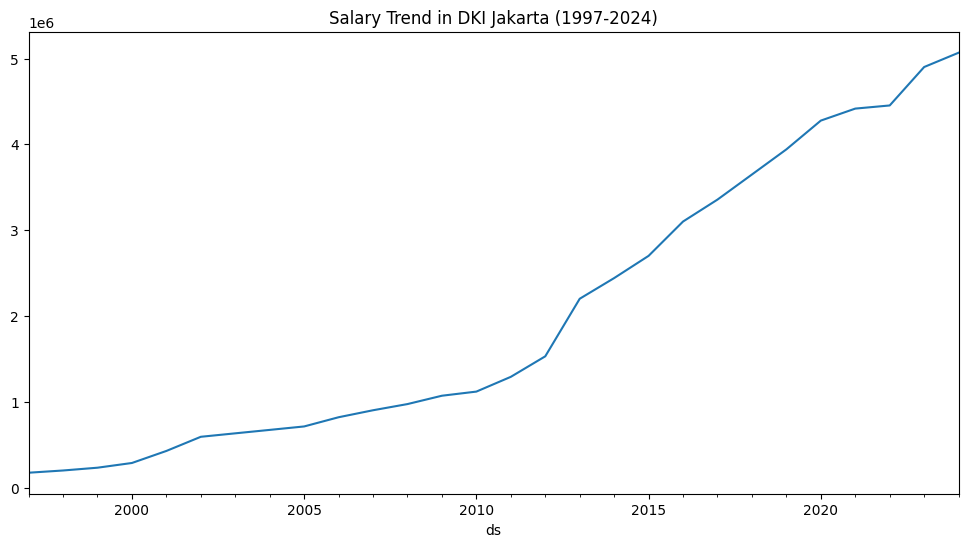

In [190]:
# Ambil data untuk DKI Jakarta
df_jakarta = df[df['REGION'] == 'Dki Jakarta'].copy()
df_jakarta = df_jakarta.rename(columns={'YEAR': 'ds', 'SALARY': 'y'})  # Sesuaikan kolom
df_jakarta['ds'] = pd.to_datetime(df_jakarta['ds'], format='%Y')  # Konversi tahun ke datetime
df_jakarta.set_index('ds', inplace=True)  # Set index ke waktu

# Plot data asli
df_jakarta['y'].plot(figsize=(12, 6), title="Salary Trend in DKI Jakarta (1997-2024)")
plt.show()

Mean Absolute Error (MAE): 93311.31071317817
Mean Squared Error (MSE): 19926969536.591503


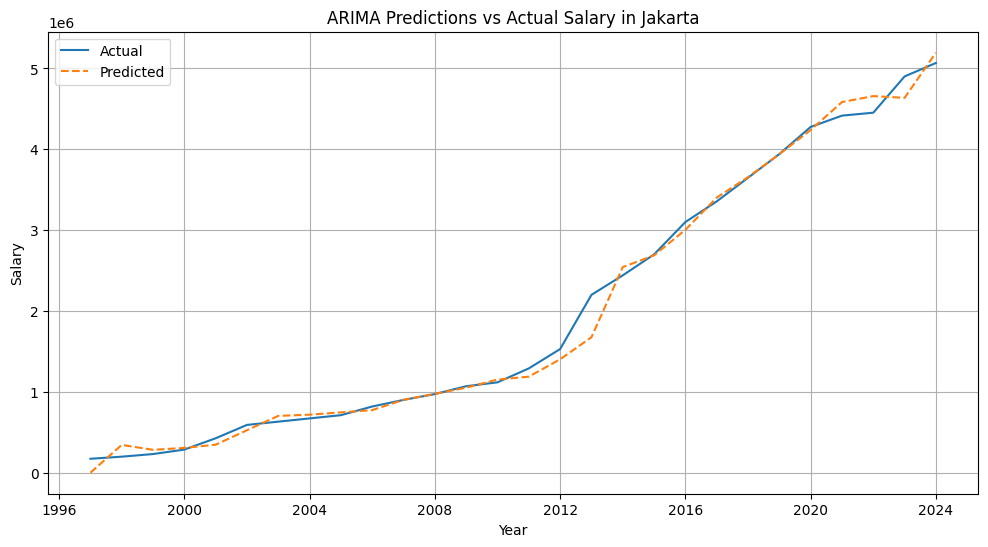

In [215]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_jakarta is already prepared as in the previous code
df_jakarta = df_jakarta.rename(columns={'YEAR': 'ds', 'SALARY': 'y'})  # Rename columns

# Ensure that 'ds' is in datetime format or string format
df_jakarta['ds'] = pd.to_datetime(df_jakarta['ds'], format='%Y')  # Convert year to datetime

# Fit the ARIMA model on the entire dataset
model = ARIMA(df_jakarta['y'], order=(2,1,2))  # Example order, adjust as needed
model_fit = model.fit()

# Make predictions on the entire dataset
predictions = model_fit.predict(start=0, end=len(df_jakarta)-1)

# Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(df_jakarta['y'], predictions)
mse = mean_squared_error(df_jakarta['y'], predictions)

# Print the MAE and MSE
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot predicted vs actual with correct 'Year' labels
plt.figure(figsize=(12, 6))
plt.plot(df_jakarta['ds'], df_jakarta['y'], label='Actual')  # Using 'ds' for the x-axis
plt.plot(df_jakarta['ds'], predictions, label='Predicted', linestyle='--')  # Using 'ds' for the x-axis
plt.title('ARIMA Predictions vs Actual Salary in Jakarta')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 86525.06301991364
Mean Squared Error (MSE): 18992191220.616753


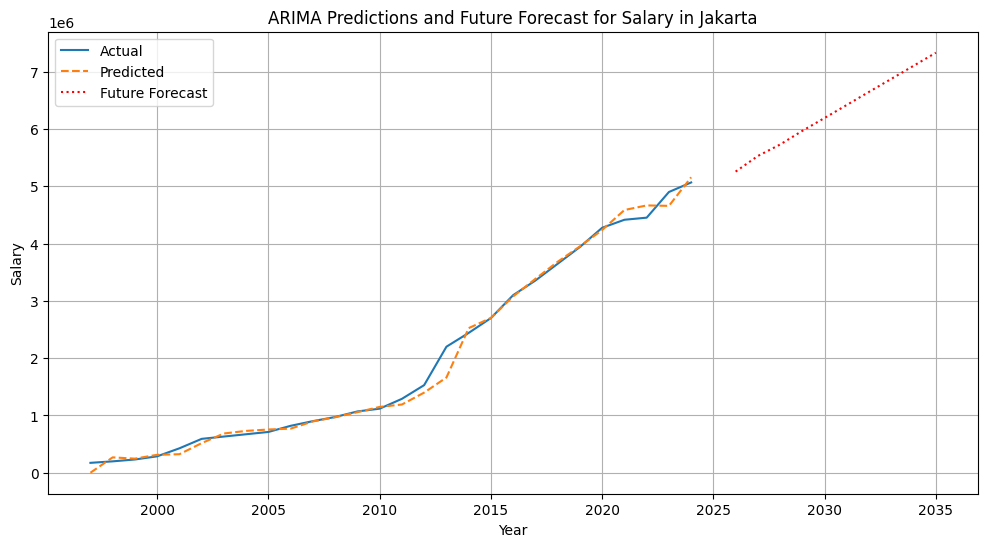

Future Forecasted Salaries:
    Year  Forecasted Salary
28  2025       5.256898e+06
29  2026       5.529757e+06
30  2027       5.729513e+06
31  2028       5.969327e+06
32  2029       6.193571e+06
33  2030       6.421159e+06
34  2031       6.649649e+06
35  2032       6.876628e+06
36  2033       7.104626e+06
37  2034       7.332147e+06


In [226]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_jakarta is already prepared as in the previous code
df_jakarta = df_jakarta.rename(columns={'YEAR': 'ds', 'SALARY': 'y'})  # Rename columns

# Ensure that 'ds' is in datetime format or string format
df_jakarta['ds'] = pd.to_datetime(df_jakarta['ds'], format='%Y')  # Convert year to datetime

# Fit the ARIMA model on the entire dataset
model = ARIMA(df_jakarta['y'], order=(2,2,2))  # Example order, adjust as needed
model_fit = model.fit()

# Make predictions on the entire dataset
predictions = model_fit.predict(start=0, end=len(df_jakarta)-1)

# Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(df_jakarta['y'], predictions)
mse = mean_squared_error(df_jakarta['y'], predictions)

# Print the MAE and MSE
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Forecast future values (let's say 5 years into the future)
forecast_steps = 10  # Specify the number of periods (years) you want to forecast
future_forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates for plotting
last_date = df_jakarta['ds'].max()
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='Y')[1:]  # Skip the start date

# Plot predicted vs actual with future forecast
plt.figure(figsize=(12, 6))
plt.plot(df_jakarta['ds'], df_jakarta['y'], label='Actual')  # Using 'ds' for the x-axis (Actual)
plt.plot(df_jakarta['ds'], predictions, label='Predicted', linestyle='--')  # Predicted
plt.plot(forecast_dates, future_forecast, label='Future Forecast', linestyle=':', color='red')  # Forecast
plt.title('ARIMA Predictions and Future Forecast for Salary in Jakarta')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()

# Print the forecasted values with their corresponding future years
forecasted_results = pd.DataFrame({
    'Year': forecast_dates.year,  # Extract just the year part for clarity
    'Forecasted Salary': future_forecast
})

print("Future Forecasted Salaries:")
print(forecasted_results)

### 2. Forecast Salary for Jogjakarta

In [228]:
df_jogja = df[df["REGION"] == "Di Yogyakarta"]
df_jogja

REGION   SALARY  YEAR ISLAND
111  Di Yogyakarta   106500  1997   Jawa
112  Di Yogyakarta   122500  1998   Jawa
113  Di Yogyakarta   130000  1999   Jawa
114  Di Yogyakarta   194500  2000   Jawa
115  Di Yogyakarta   237500  2001   Jawa
116  Di Yogyakarta   321800  2002   Jawa
117  Di Yogyakarta   360000  2003   Jawa
118  Di Yogyakarta   365000  2004   Jawa
119  Di Yogyakarta   400000  2005   Jawa
120  Di Yogyakarta   460000  2006   Jawa
121  Di Yogyakarta   500000  2007   Jawa
122  Di Yogyakarta   586000  2008   Jawa
123  Di Yogyakarta   700000  2009   Jawa
124  Di Yogyakarta   745694  2010   Jawa
125  Di Yogyakarta   808000  2011   Jawa
126  Di Yogyakarta   892660  2012   Jawa
127  Di Yogyakarta   947114  2013   Jawa
128  Di Yogyakarta   988500  2014   Jawa
129  Di Yogyakarta   988500  2015   Jawa
130  Di Yogyakarta   988500  2016   Jawa
131  Di Yogyakarta  1337645  2017   Jawa
132  Di Yogyakarta  1454154  2018   Jawa
133  Di Yogyakarta  1570923  2019   Jawa
134  Di Yogyakarta  1704608  2020   Jawa
135  Di Yogyakarta  1765000  2021   Jawa
136  Di Yogyakarta  1840951  2022   Jawa
137  Di Yogyakarta  1981782  2023   Jawa
138  Di Yogyakarta  2125897  2024   Jawa

Mean Absolute Error (MAE): 40306.830354942846
Mean Squared Error (MSE): 4736783035.488265


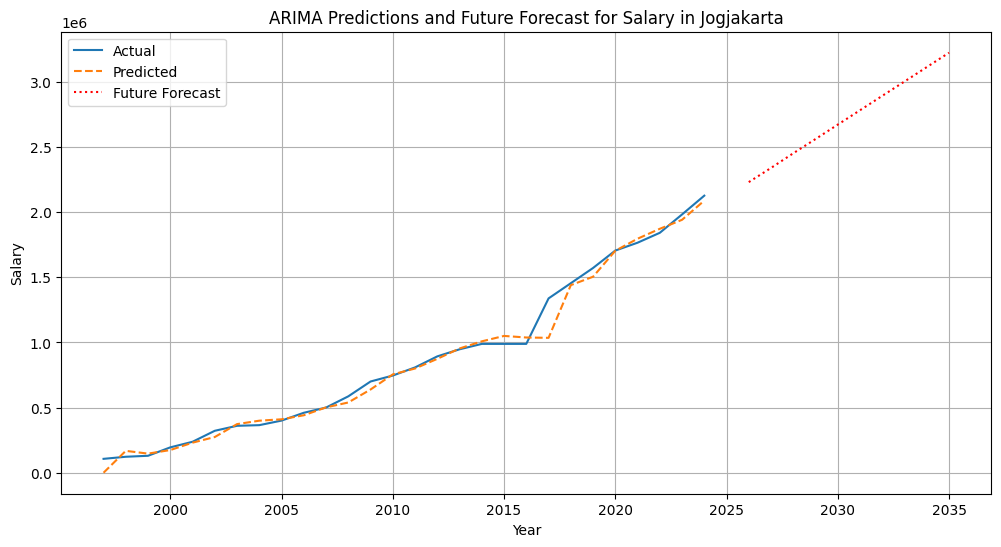

Future Forecasted Salaries:


Year  Forecasted Salary
28  2025       2.229816e+06
29  2026       2.338636e+06
30  2027       2.450921e+06
31  2028       2.560380e+06
32  2029       2.670962e+06
33  2030       2.781328e+06
34  2031       2.891644e+06
35  2032       3.002023e+06
36  2033       3.112373e+06
37  2034       3.222730e+06

In [235]:
# prompt: generate plot for jogja trend salary

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming df_jogja is already prepared as in the previous code
df_jogja = df[df['REGION'] == 'Di Yogyakarta'].copy()
df_jogja = df_jogja.rename(columns={'YEAR': 'ds', 'SALARY': 'y'})  # Rename columns

# Ensure that 'ds' is in datetime format or string format
df_jogja['ds'] = pd.to_datetime(df_jogja['ds'], format='%Y')  # Convert year to datetime

# Fit the ARIMA model on the entire dataset
model = ARIMA(df_jogja['y'], order=(2, 2, 2))  # Example order, adjust as needed
model_fit = model.fit()

# Make predictions on the entire dataset
predictions = model_fit.predict(start=0, end=len(df_jogja) - 1)

# Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(df_jogja['y'], predictions)
mse = mean_squared_error(df_jogja['y'], predictions)

# Print the MAE and MSE
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Forecast future values
forecast_steps = 10  # Specify the number of periods (years) you want to forecast
future_forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates for plotting
last_date = df_jogja['ds'].max()
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='Y')[1:]  # Skip the start date

# Plot predicted vs actual with future forecast
plt.figure(figsize=(12, 6))
plt.plot(df_jogja['ds'], df_jogja['y'], label='Actual')  # Using 'ds' for the x-axis (Actual)
plt.plot(df_jogja['ds'], predictions, label='Predicted', linestyle='--')  # Predicted
plt.plot(forecast_dates, future_forecast, label='Future Forecast', linestyle=':', color='red')  # Forecast
plt.title('ARIMA Predictions and Future Forecast for Salary in Jogjakarta')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()

# Print the forecasted values with their corresponding future years
forecasted_results = pd.DataFrame({
    'Year': forecast_dates.year,  # Extract just the year part for clarity
    'Forecasted Salary': future_forecast
})

print("Future Forecasted Salaries:")
forecasted_results

Mean Absolute Error (MAE): 93311.31071317817
Mean Squared Error (MSE): 19926969536.591503


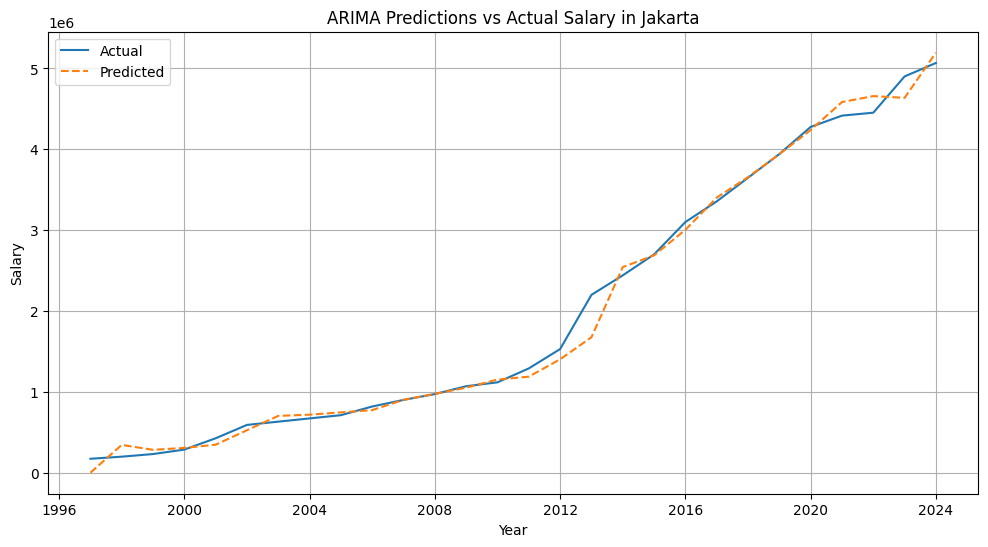

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_jakarta is already prepared as in the previous code
df_jakarta = df_jakarta.rename(columns={'YEAR': 'ds', 'SALARY': 'y'})  # Rename columns

# Ensure that 'ds' is in datetime format or string format
df_jakarta['ds'] = pd.to_datetime(df_jakarta['ds'], format='%Y')  # Convert year to datetime

# Fit the ARIMA model on the entire dataset
model = ARIMA(df_jakarta['y'], order=(2,1,2))  # Example order, adjust as needed
model_fit = model.fit()

# Make predictions on the entire dataset
predictions = model_fit.predict(start=0, end=len(df_jakarta)-1)

# Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(df_jakarta['y'], predictions)
mse = mean_squared_error(df_jakarta['y'], predictions)

# Print the MAE and MSE
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot predicted vs actual with correct 'Year' labels
plt.figure(figsize=(12, 6))
plt.plot(df_jakarta['ds'], df_jakarta['y'], label='Actual')  # Using 'ds' for the x-axis
plt.plot(df_jakarta['ds'], predictions, label='Predicted', linestyle='--')  # Using 'ds' for the x-axis
plt.title('ARIMA Predictions vs Actual Salary in Jakarta')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 86525.06301991364
Mean Squared Error (MSE): 18992191220.616753


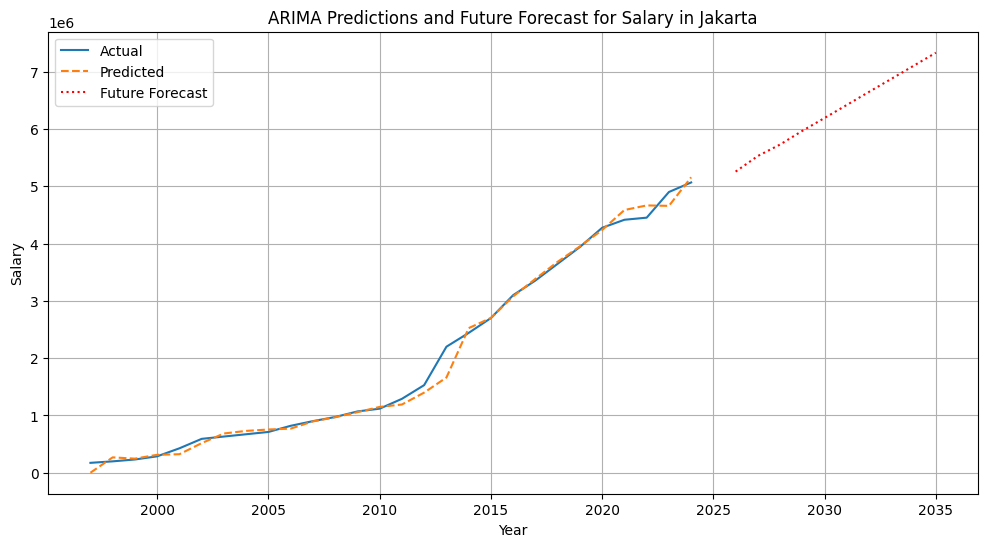

Future Forecasted Salaries:
    Year  Forecasted Salary
28  2025       5.256898e+06
29  2026       5.529757e+06
30  2027       5.729513e+06
31  2028       5.969327e+06
32  2029       6.193571e+06
33  2030       6.421159e+06
34  2031       6.649649e+06
35  2032       6.876628e+06
36  2033       7.104626e+06
37  2034       7.332147e+06


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_jakarta is already prepared as in the previous code
df_jakarta = df_jakarta.rename(columns={'YEAR': 'ds', 'SALARY': 'y'})  # Rename columns

# Ensure that 'ds' is in datetime format or string format
df_jakarta['ds'] = pd.to_datetime(df_jakarta['ds'], format='%Y')  # Convert year to datetime

# Fit the ARIMA model on the entire dataset
model = ARIMA(df_jakarta['y'], order=(2,2,2))  # Example order, adjust as needed
model_fit = model.fit()

# Make predictions on the entire dataset
predictions = model_fit.predict(start=0, end=len(df_jakarta)-1)

# Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(df_jakarta['y'], predictions)
mse = mean_squared_error(df_jakarta['y'], predictions)

# Print the MAE and MSE
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Forecast future values (let's say 5 years into the future)
forecast_steps = 10  # Specify the number of periods (years) you want to forecast
future_forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates for plotting
last_date = df_jakarta['ds'].max()
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='Y')[1:]  # Skip the start date

# Plot predicted vs actual with future forecast
plt.figure(figsize=(12, 6))
plt.plot(df_jakarta['ds'], df_jakarta['y'], label='Actual')  # Using 'ds' for the x-axis (Actual)
plt.plot(df_jakarta['ds'], predictions, label='Predicted', linestyle='--')  # Predicted
plt.plot(forecast_dates, future_forecast, label='Future Forecast', linestyle=':', color='red')  # Forecast
plt.title('ARIMA Predictions and Future Forecast for Salary in Jakarta')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()

# Print the forecasted values with their corresponding future years
forecasted_results = pd.DataFrame({
    'Year': forecast_dates.year,  # Extract just the year part for clarity
    'Forecasted Salary': future_forecast
})

print("Future Forecasted Salaries:")
print(forecasted_results)

## Evaluasi dan Visualisasi

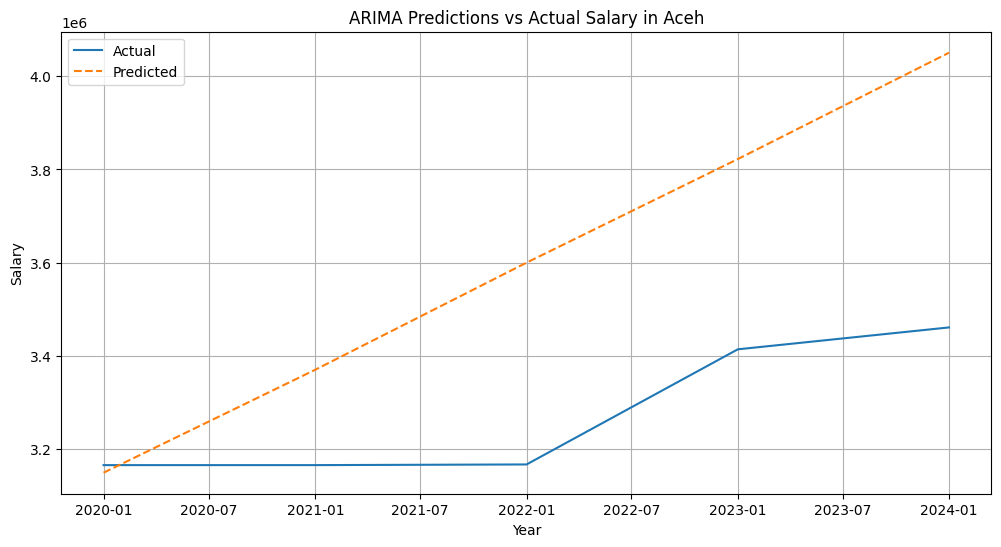

Mean Absolute Error (MAE) for Aceh: 330568.21504997247


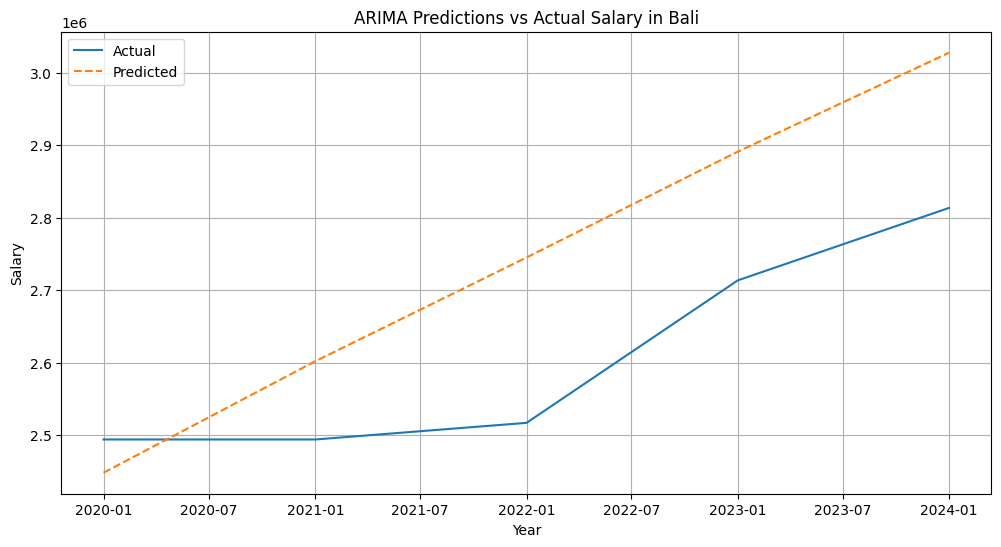

Mean Absolute Error (MAE) for Bali: 154835.18490299815


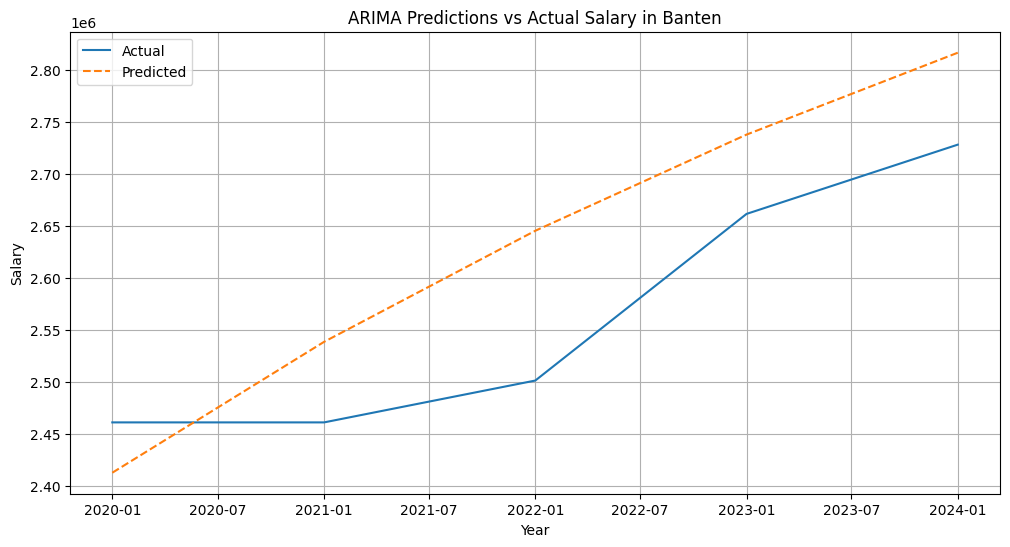

Mean Absolute Error (MAE) for Banten: 86828.19662761185


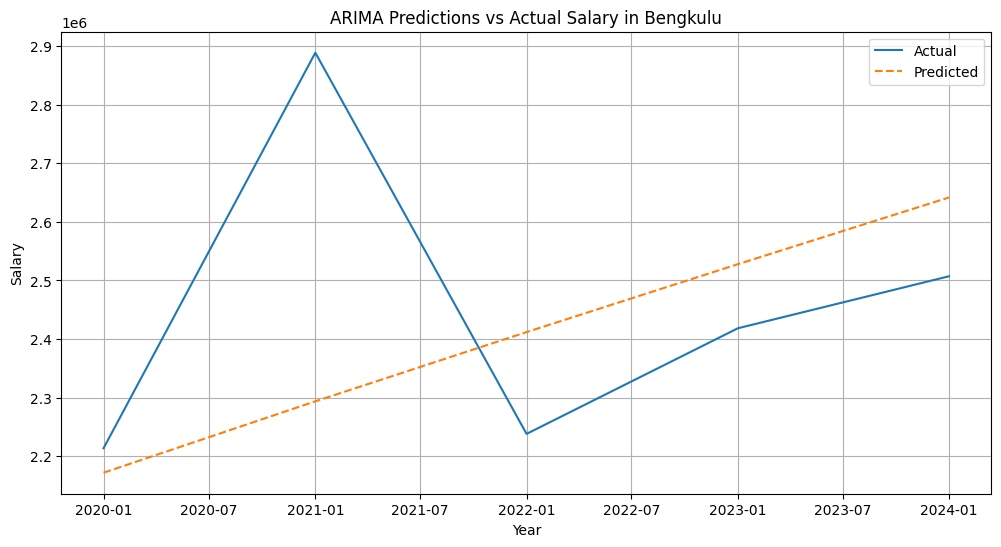

Mean Absolute Error (MAE) for Bengkulu: 210849.29553020644


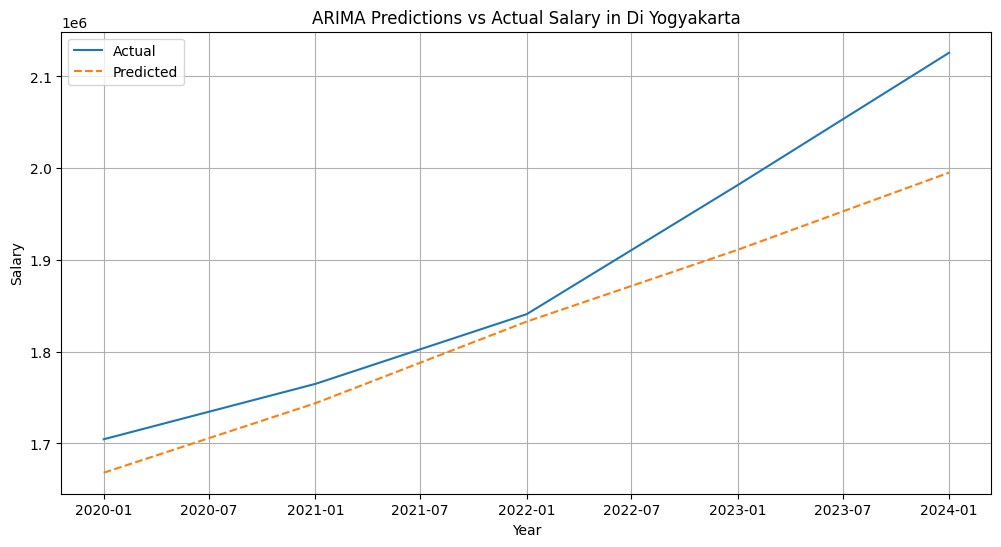

Mean Absolute Error (MAE) for Di Yogyakarta: 53372.99242038685


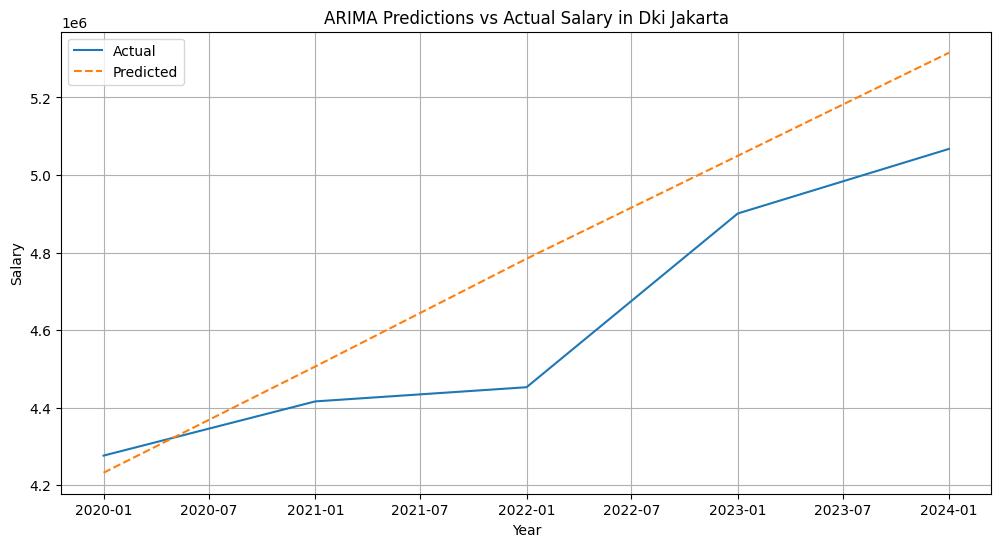

Mean Absolute Error (MAE) for Dki Jakarta: 172494.49673686252


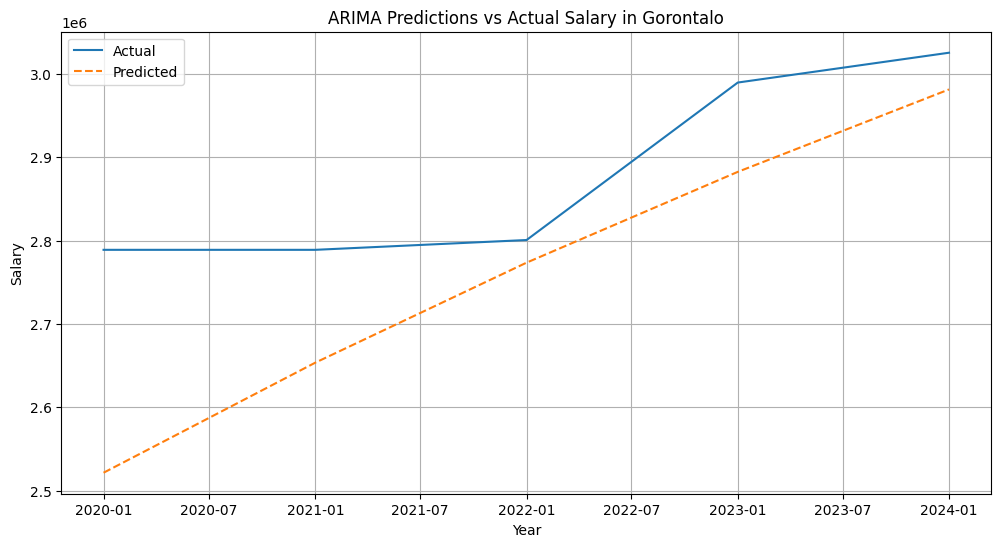

Mean Absolute Error (MAE) for Gorontalo: 116121.96628198065


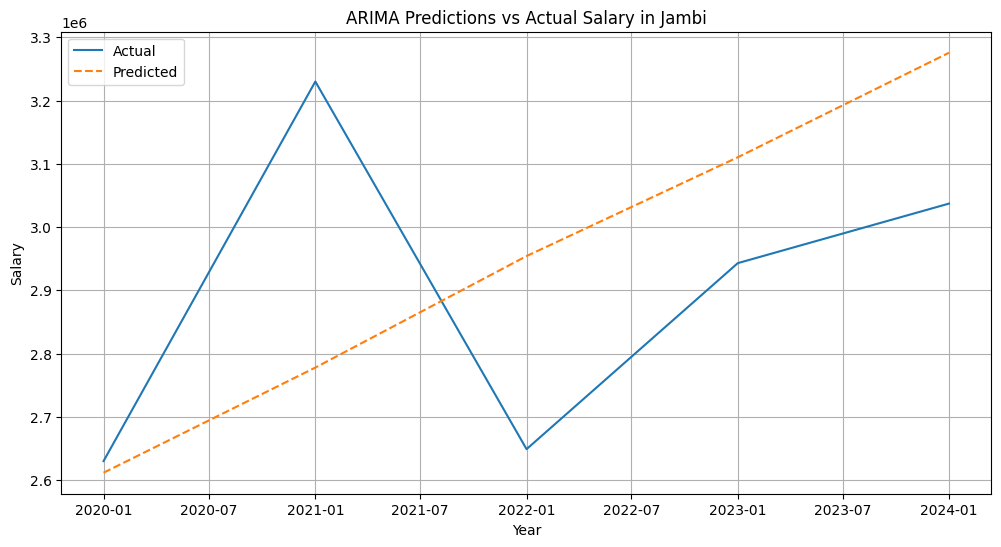

Mean Absolute Error (MAE) for Jambi: 236261.4102790961


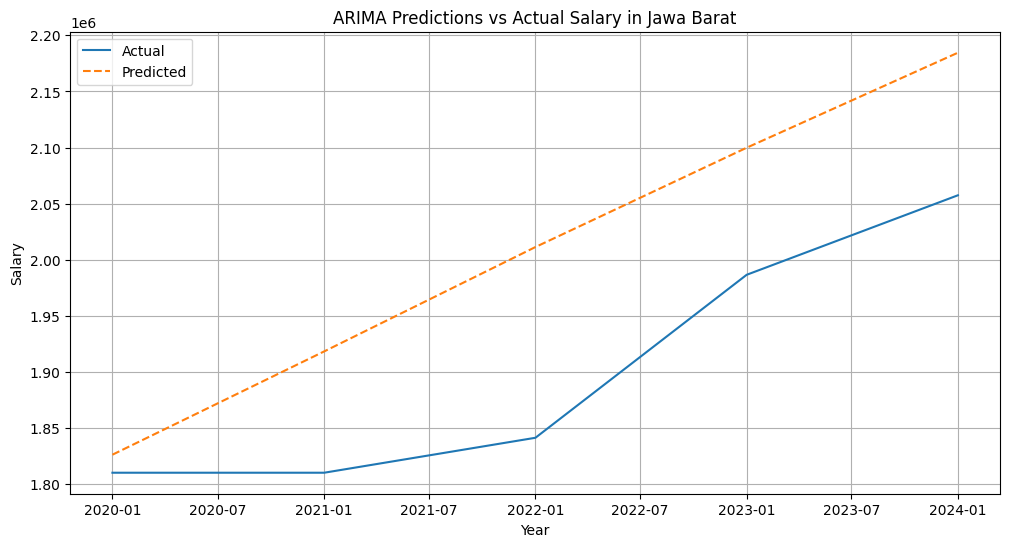

Mean Absolute Error (MAE) for Jawa Barat: 106850.96730143572


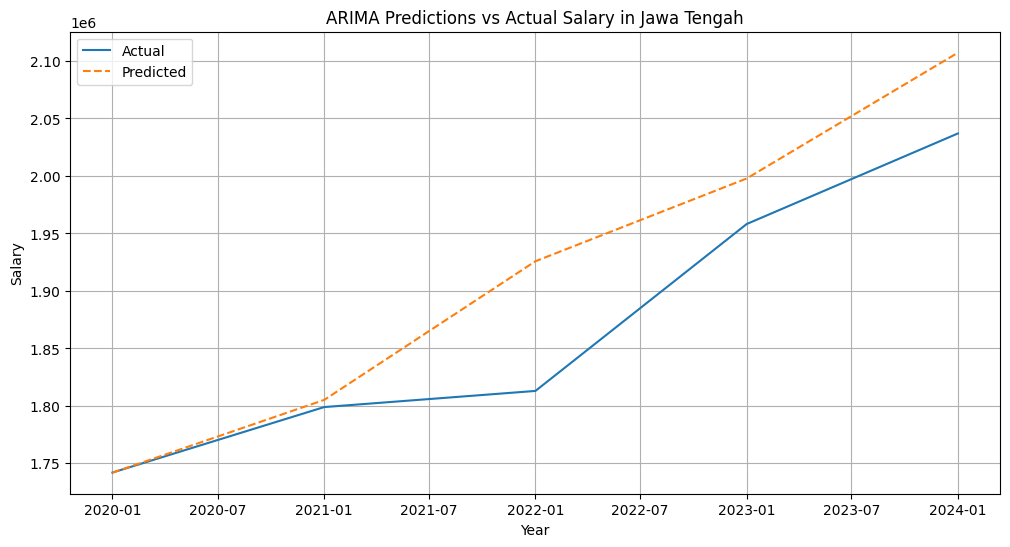

Mean Absolute Error (MAE) for Jawa Tengah: 45804.437584870306


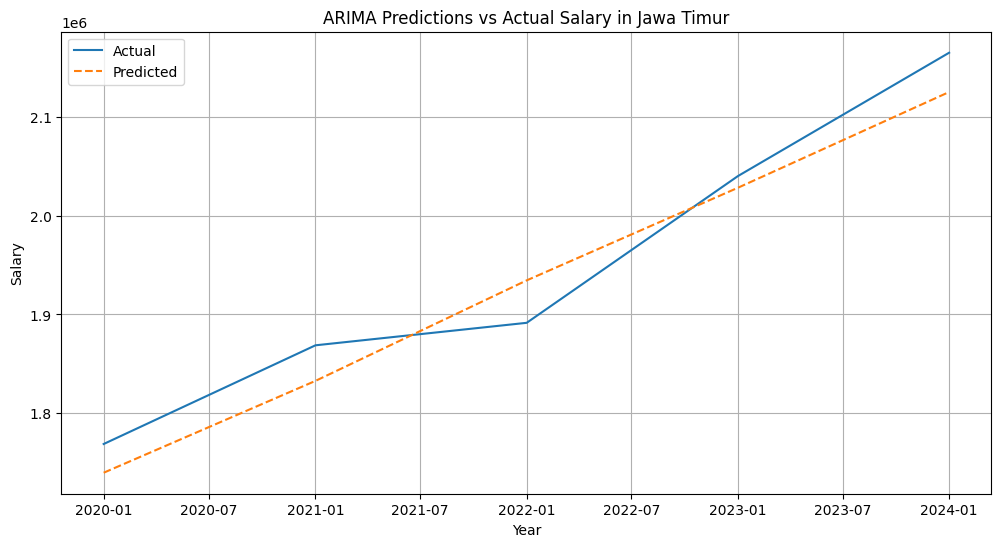

Mean Absolute Error (MAE) for Jawa Timur: 31959.72556024841


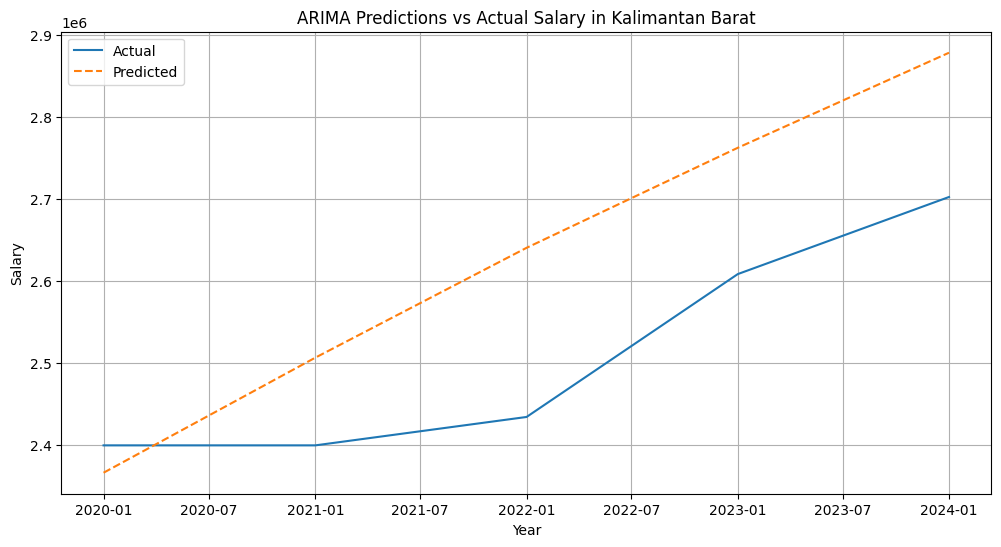

Mean Absolute Error (MAE) for Kalimantan Barat: 135330.38214309924


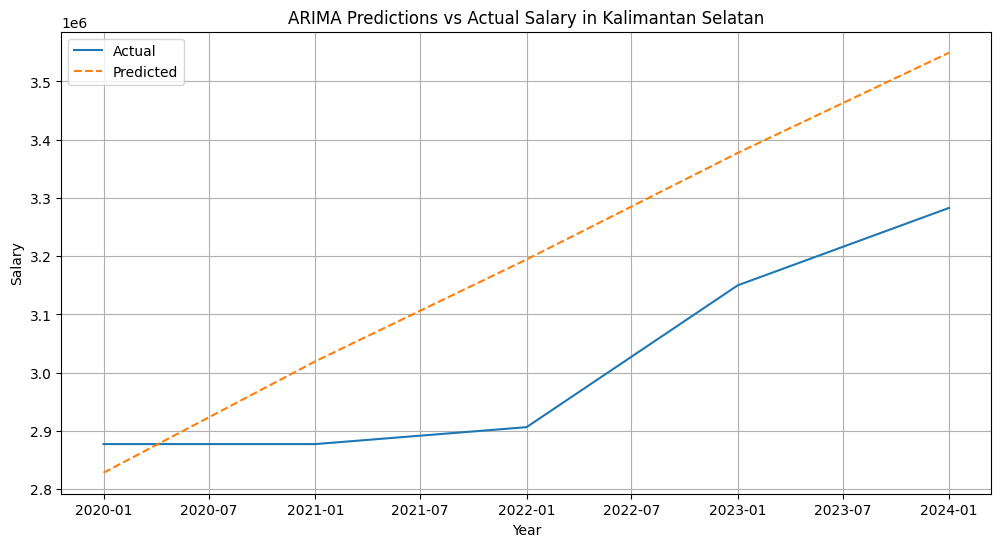

Mean Absolute Error (MAE) for Kalimantan Selatan: 194573.74117726414


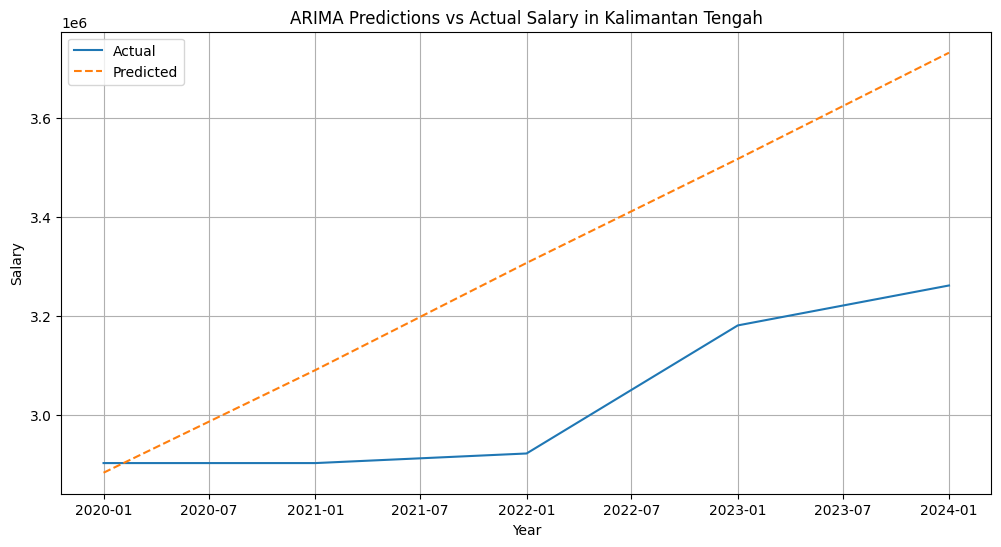

Mean Absolute Error (MAE) for Kalimantan Tengah: 279512.67578947765


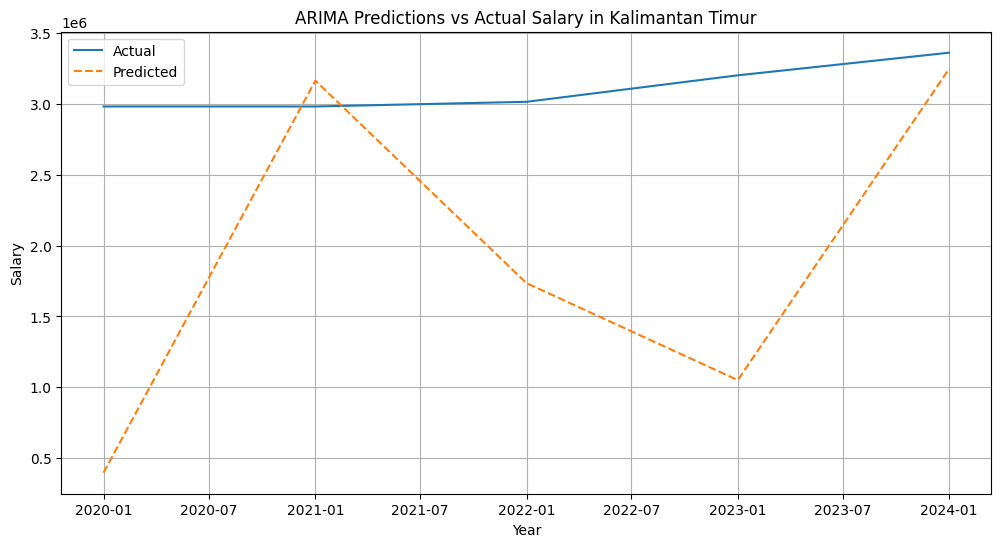

Mean Absolute Error (MAE) for Kalimantan Timur: 1262685.4834593108


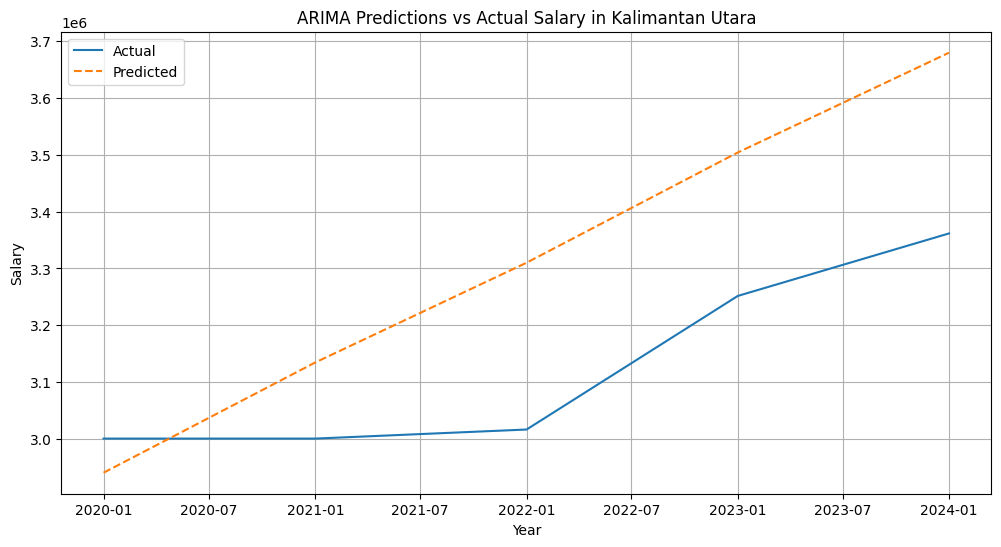

Mean Absolute Error (MAE) for Kalimantan Utara: 211518.25166895037


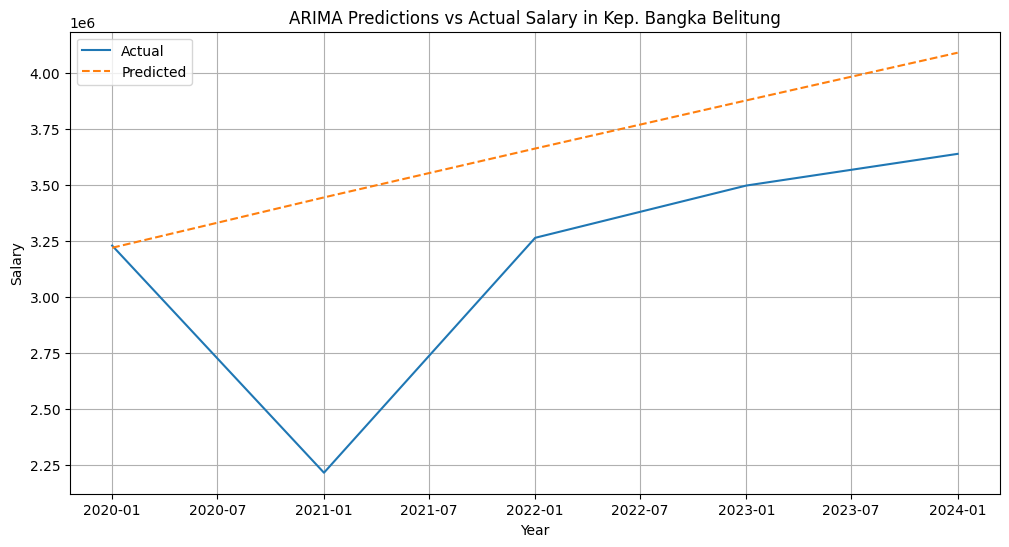

Mean Absolute Error (MAE) for Kep. Bangka Belitung: 494303.8223509025


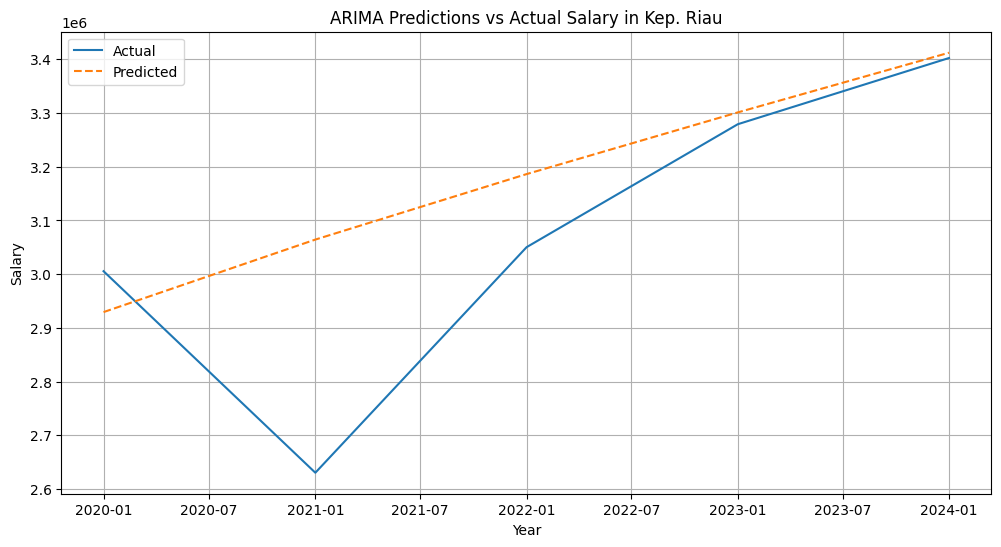

Mean Absolute Error (MAE) for Kep. Riau: 135665.29095108286


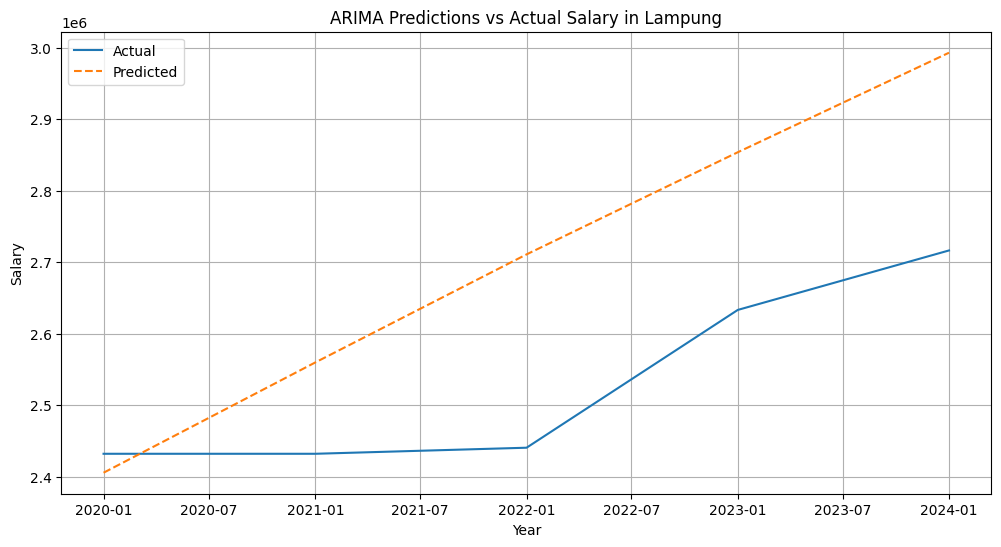

Mean Absolute Error (MAE) for Lampung: 184427.0279759624


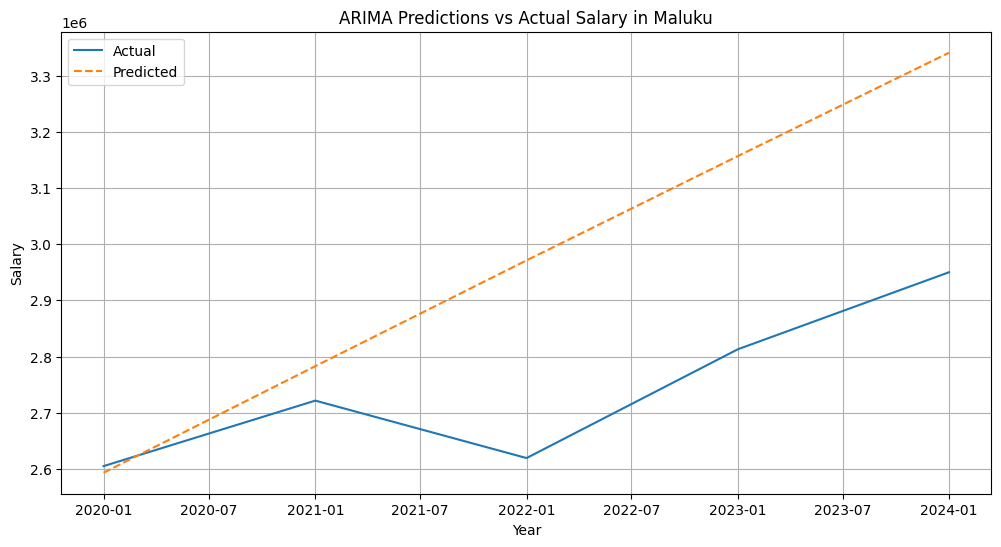

Mean Absolute Error (MAE) for Maluku: 231823.82986569387


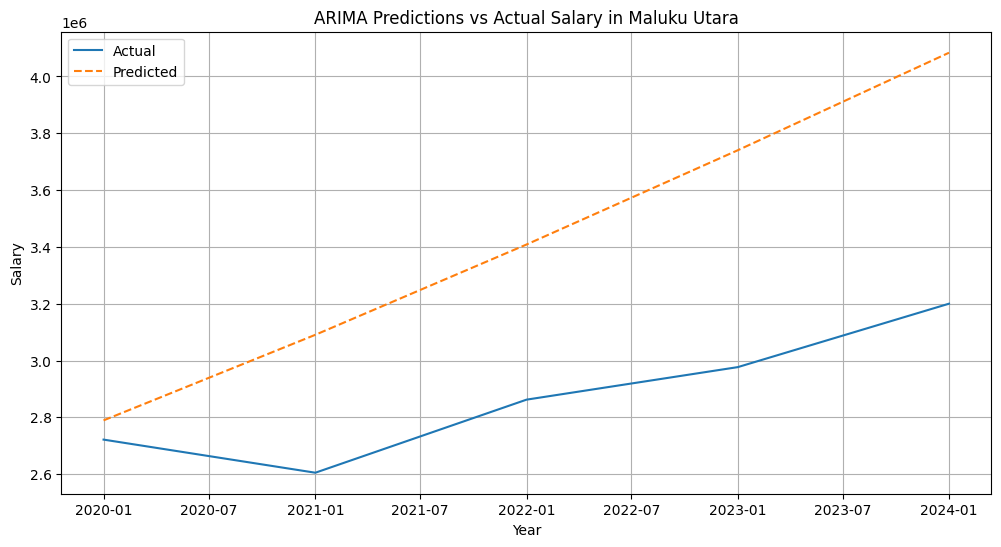

Mean Absolute Error (MAE) for Maluku Utara: 549304.2458747305


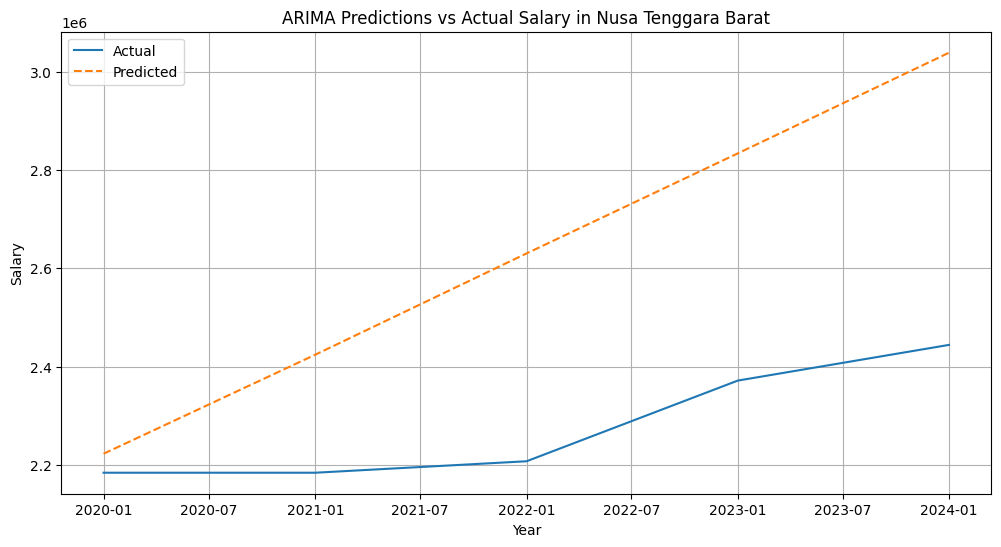

Mean Absolute Error (MAE) for Nusa Tenggara Barat: 351831.74074442


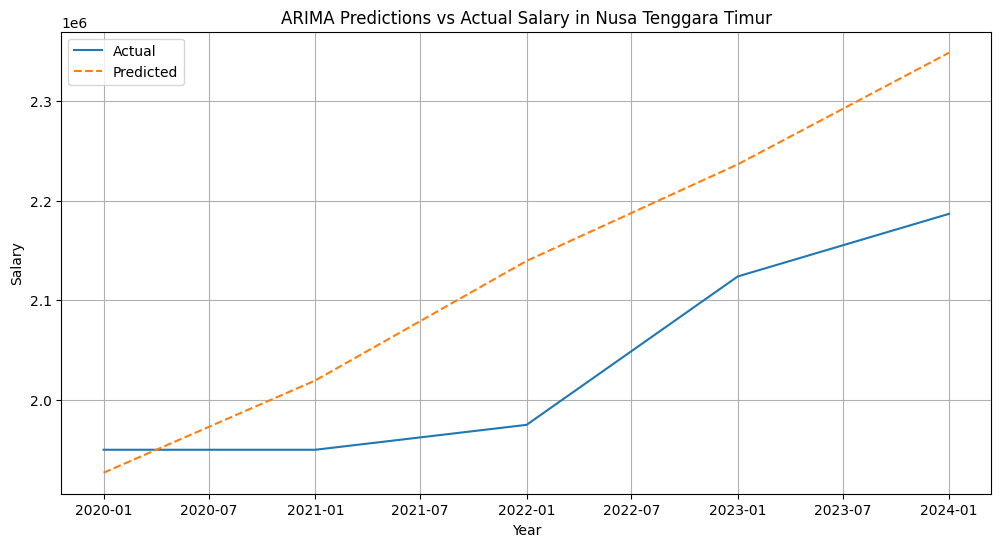

Mean Absolute Error (MAE) for Nusa Tenggara Timur: 106291.81481513358


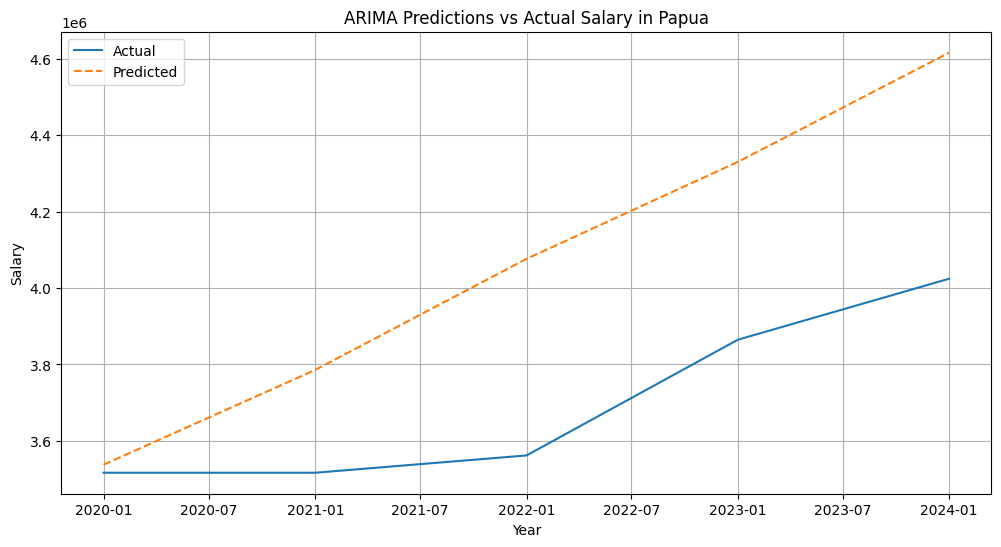

Mean Absolute Error (MAE) for Papua: 372333.97100007423


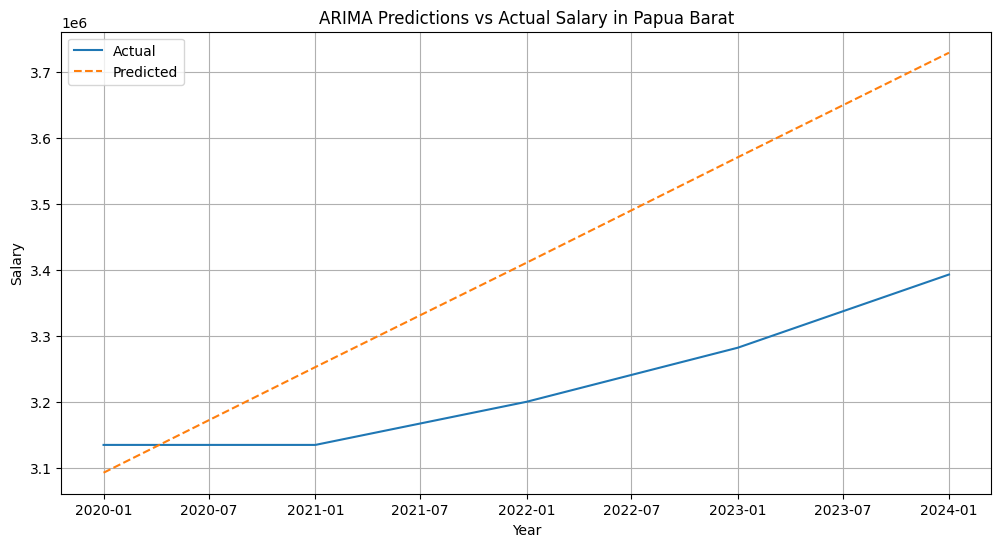

Mean Absolute Error (MAE) for Papua Barat: 199241.5809612195


LinAlgError: Schur decomposition solver error.

In [236]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# Group data by region
regions = df['REGION'].unique()  # Get unique regions
predictions_all_regions = []

# Loop for each region
for region in regions:
    region_data = df[df['REGION'] == region].copy()
    region_data = region_data.rename(columns={'YEAR': 'ds', 'SALARY': 'y'})

    # Ensure 'ds' is datetime
    region_data['ds'] = pd.to_datetime(region_data['ds'], format='%Y')

    # Train-test split
    train_data = region_data[:-5]  # Training on all data except the last 5 years
    test_data = region_data[-5:]   # Testing on the last 5 years

    # Fit the ARIMA model
    model = ARIMA(train_data['y'], order=(2, 1, 2))  # (p, d, q) are examples, adjust based on ACF/PACF
    model_fit = model.fit()

    # Make predictions
    predictions = model_fit.predict(start=len(train_data), end=len(region_data)-1)
    predictions_all_regions.append((region, predictions))

    # Plot predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['ds'], test_data['y'], label='Actual')
    plt.plot(test_data['ds'], predictions, label='Predicted', linestyle='--')
    plt.title(f'ARIMA Predictions vs Actual Salary in {region}')
    plt.xlabel('Year')
    plt.ylabel('Salary')
    plt.legend()
    plt.grid(True)
    plt.show()

    # You can calculate MAE for each region as well
    mae = mean_absolute_error(test_data['y'], predictions)
    print(f"Mean Absolute Error (MAE) for {region}: {mae}")


## Konversi Model

In [238]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your dataset with 'REGION', 'YEAR', 'SALARY'
regions = df['REGION'].unique()  # Get unique regions
results = []

# Loop through each region
for region in regions:
    # Filter data for the current region
    df_region = df[df['REGION'] == region].copy()

    # Rename columns as required by ARIMA (ds for date, y for value)
    df_region = df_region.rename(columns={'YEAR': 'ds', 'SALARY': 'y'})

    # Ensure that 'ds' is in datetime format (use %Y for year if the column is just years)
    df_region['ds'] = pd.to_datetime(df_region['ds'], format='%Y')

    # Fit the ARIMA model (you can adjust (p, d, q) as needed for each region)
    model = ARIMA(df_region['y'], order=(2, 1, 2))  # Example order, adjust as needed
    model_fit = model.fit()

    # Make predictions on the entire dataset (for simplicity, we'll predict all years in the dataset)
    predictions = model_fit.predict(start=0, end=len(df_region)-1)

    # Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
    mae = mean_absolute_error(df_region['y'], predictions)
    mse = mean_squared_error(df_region['y'], predictions)

    # Store the results
    results.append({
        'Region': region,
        'MAE': mae,
        'MSE': mse,
        'Predictions': predictions,
        'Actual': df_region['y']
    })

    # Plot the actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(df_region['ds'], df_region['y'], label='Actual')  # Actual salaries
    plt.plot(df_region['ds'], predictions, label='Predicted', linestyle='--')  # Predicted salaries
    plt.title(f'ARIMA Predictions vs Actual Salary in {region}')
    plt.xlabel('Year')
    plt.ylabel('Salary')
    plt.legend()
    plt.grid(True)
    plt.show()

# Optionally, you can print the MAE and MSE for each region
for result in results:
    print(f"Region: {result['Region']}")
    print(f"Mean Absolute Error (MAE): {result['MAE']}")
    print(f"Mean Squared Error (MSE): {result['MSE']}")
    print("-" * 50)


ValueError: cannot assemble with duplicate keys

## Inference (Optional)

ds    0
ds    0
dtype: int64
892


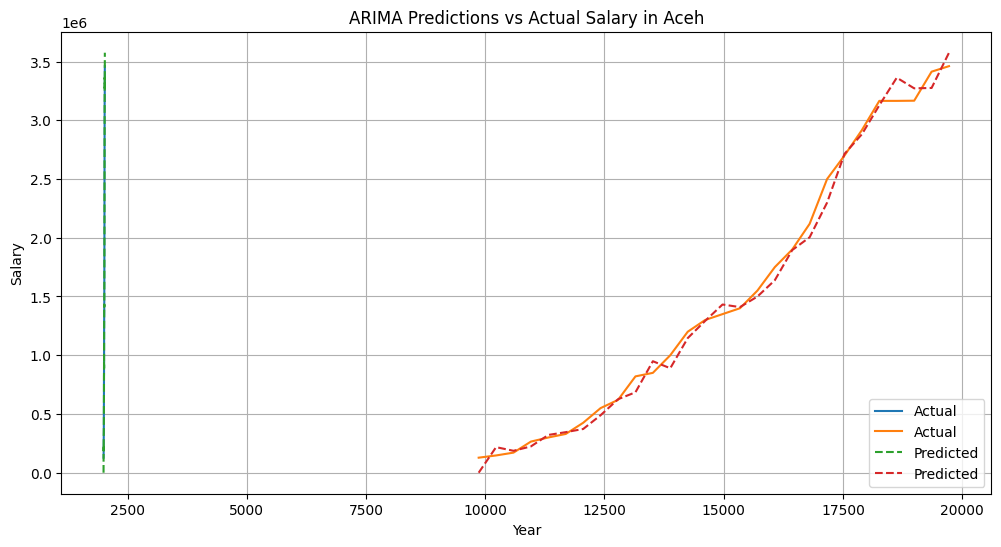

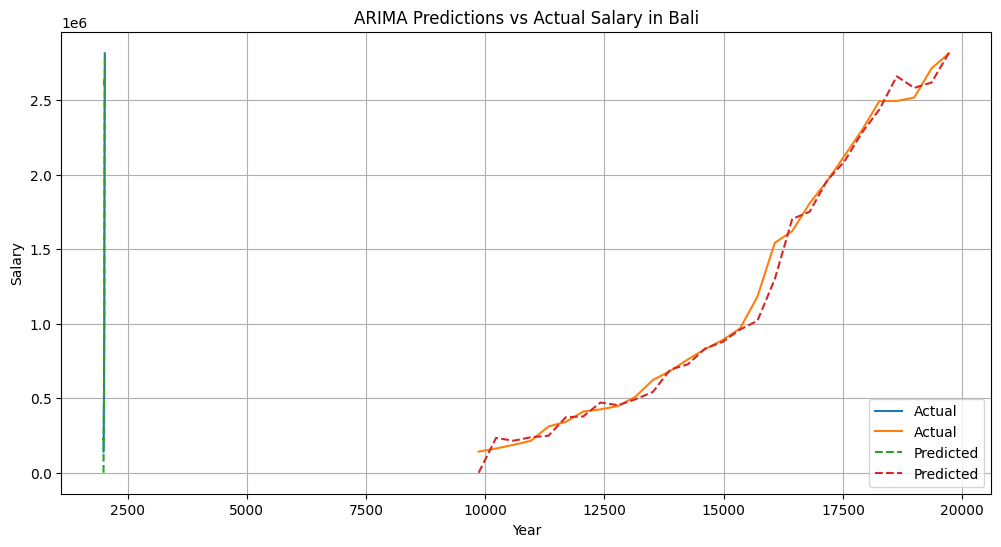

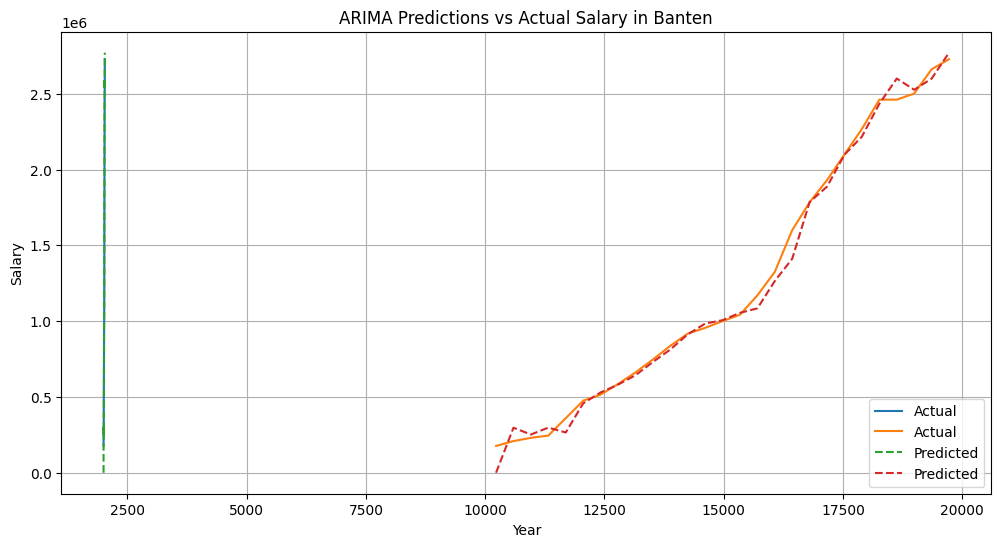

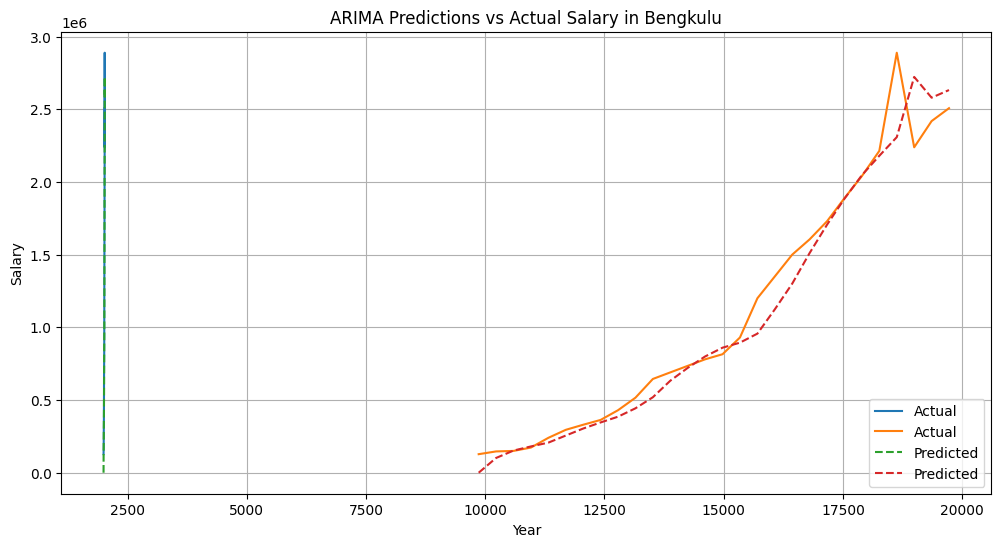

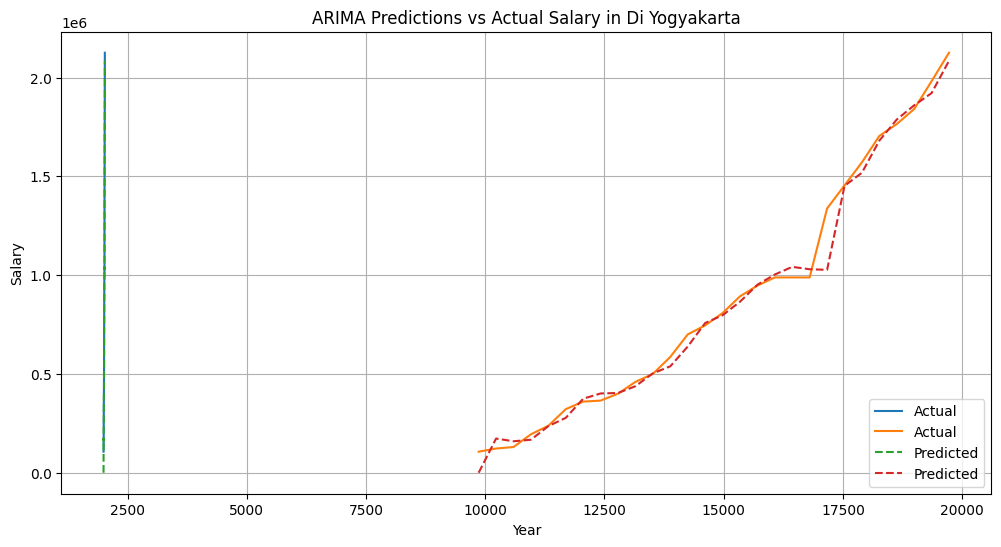

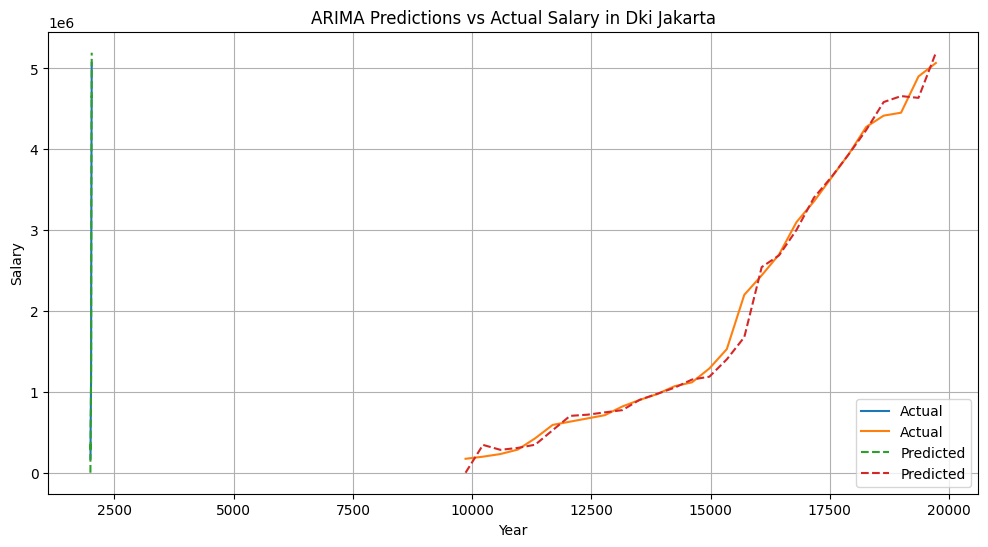

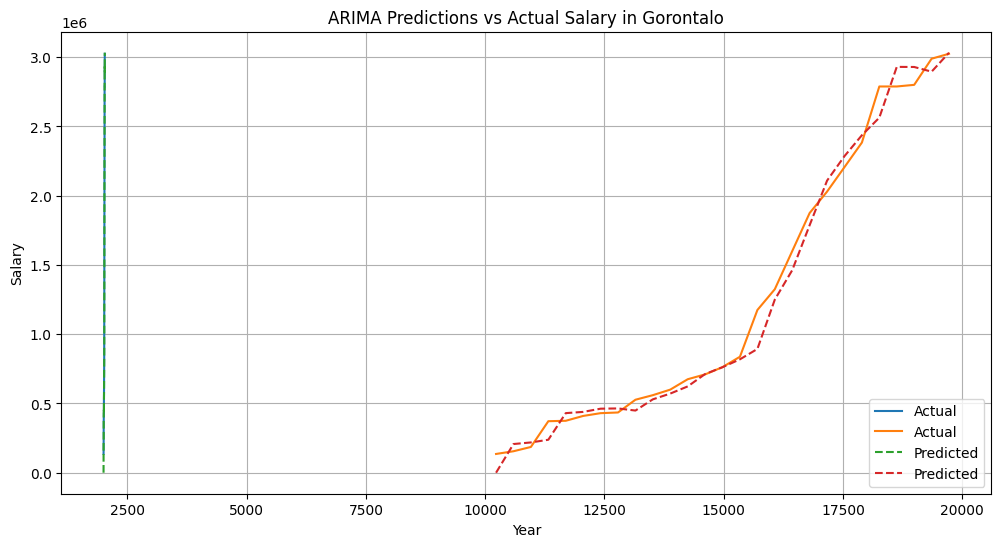

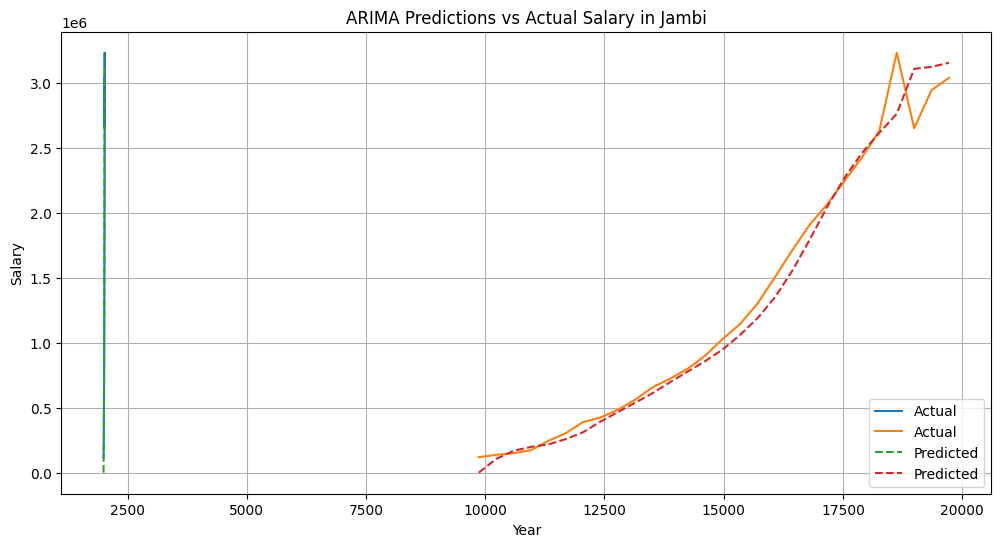

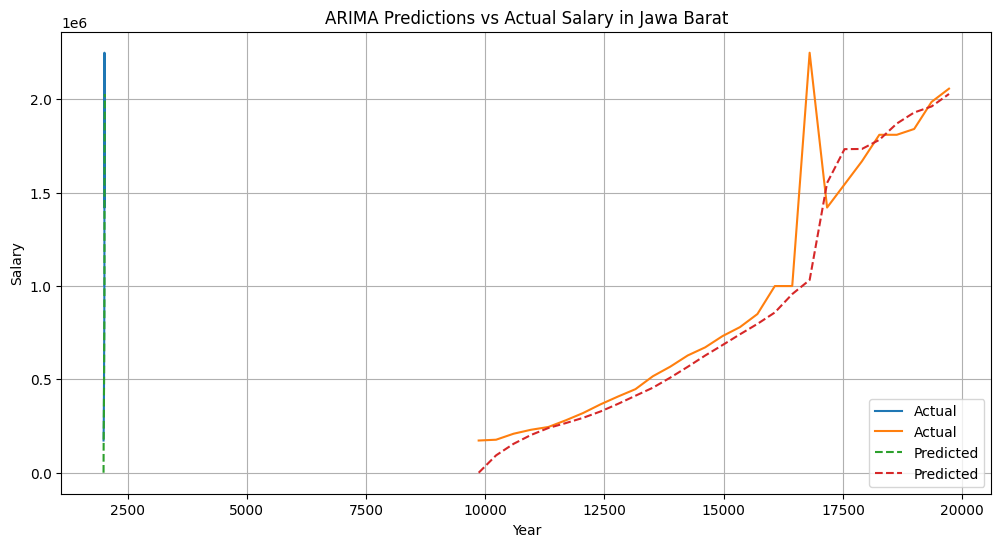

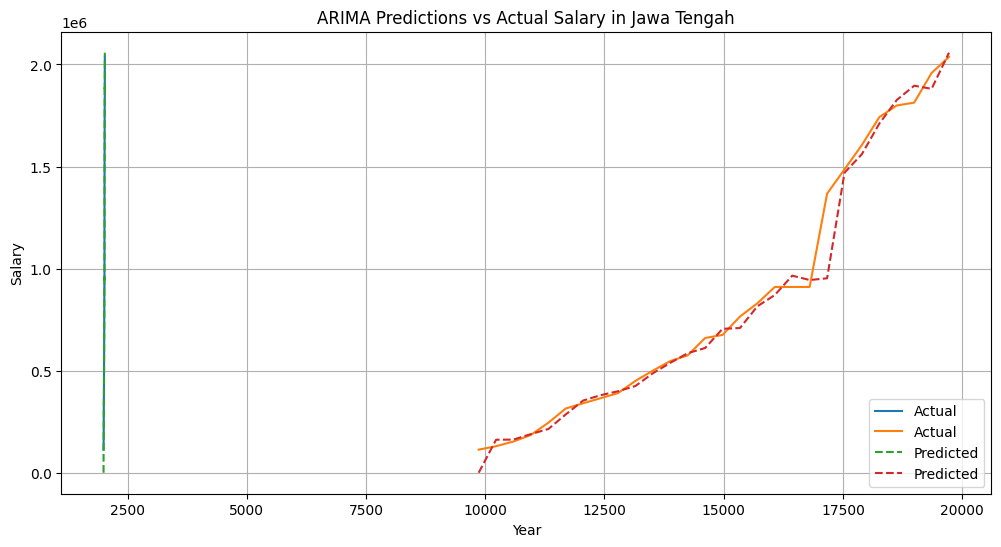

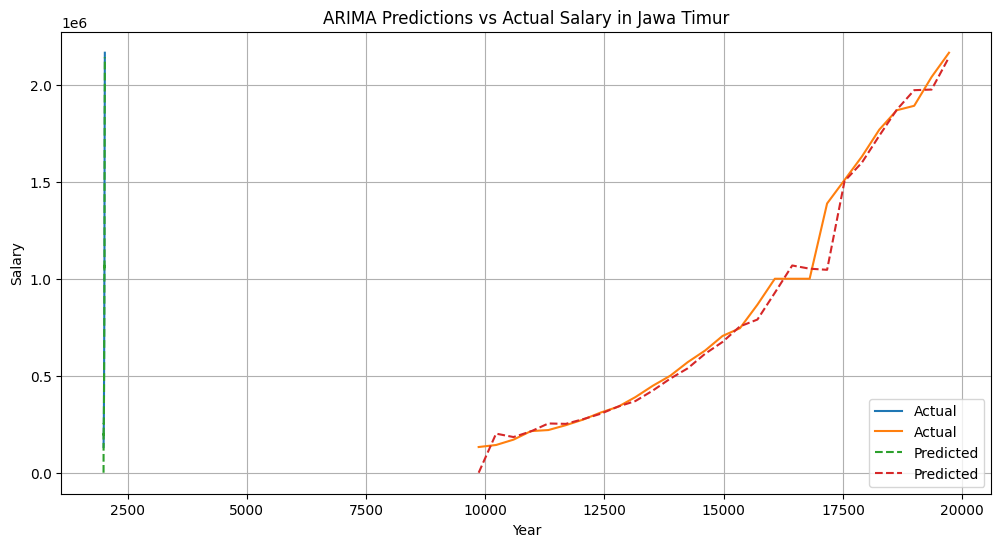

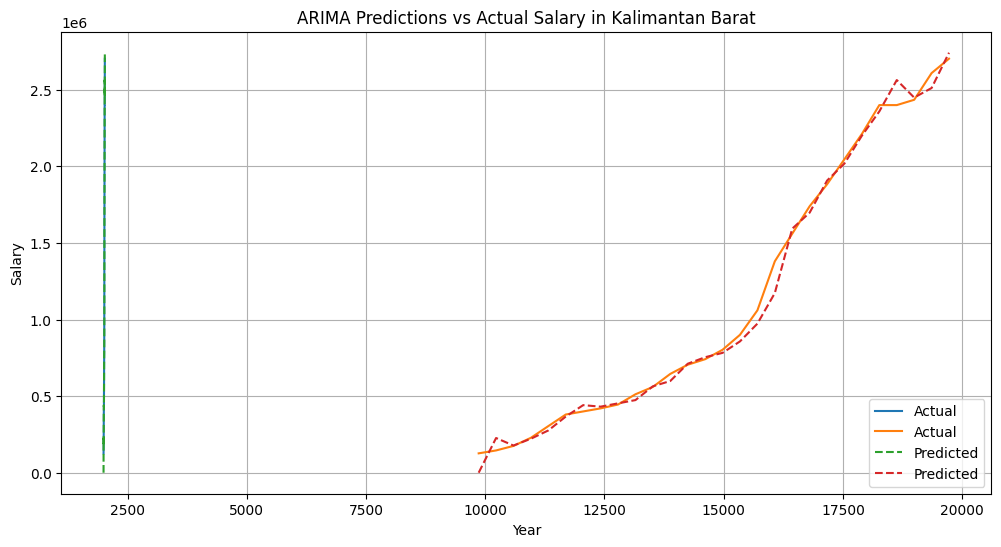

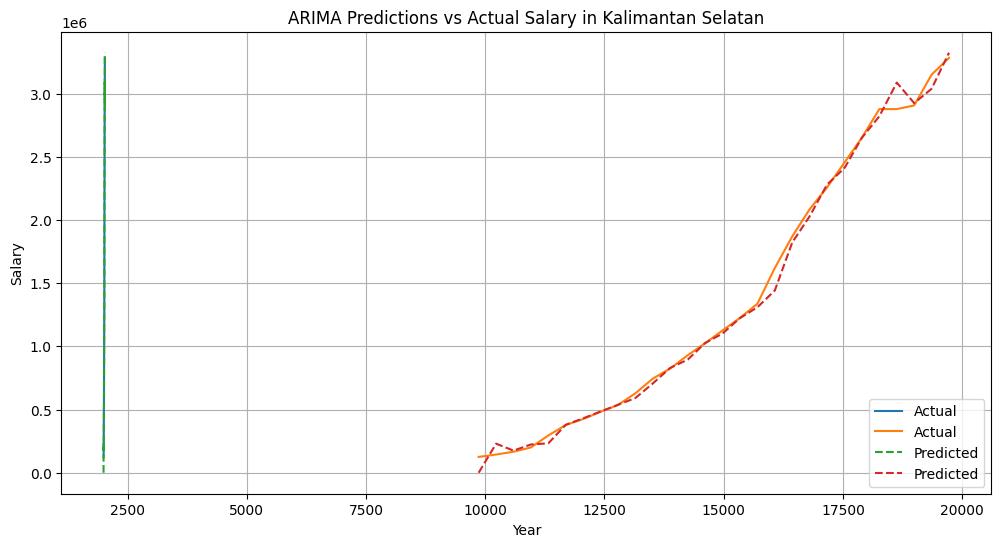

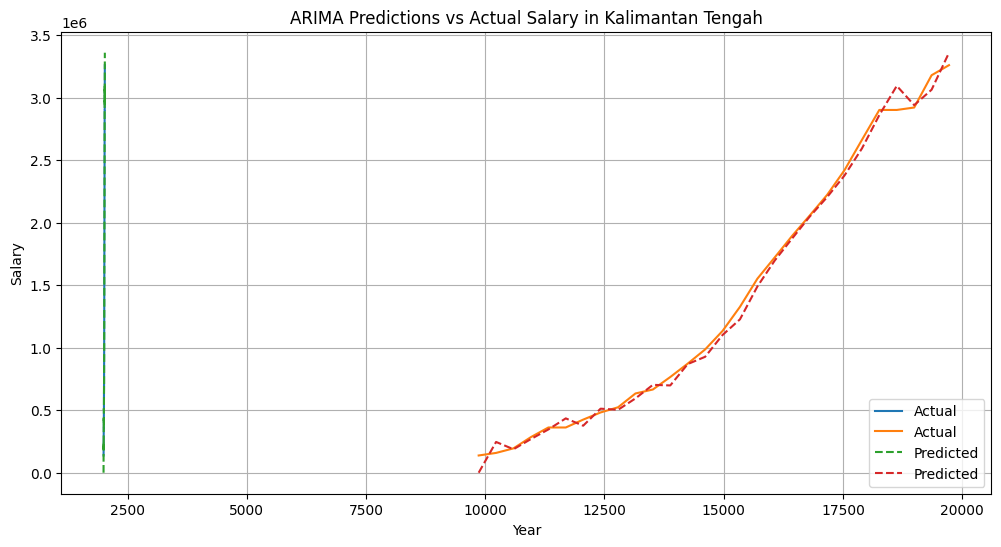

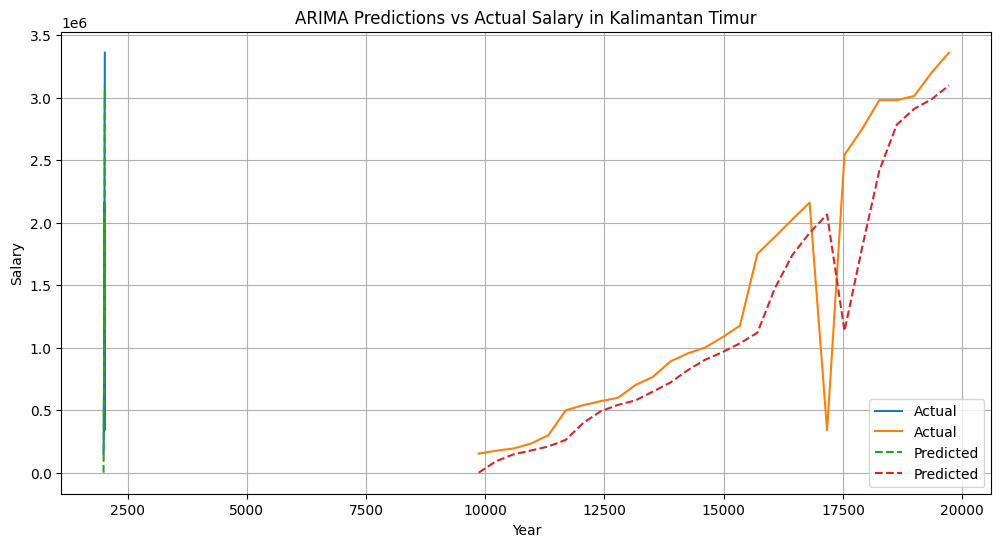

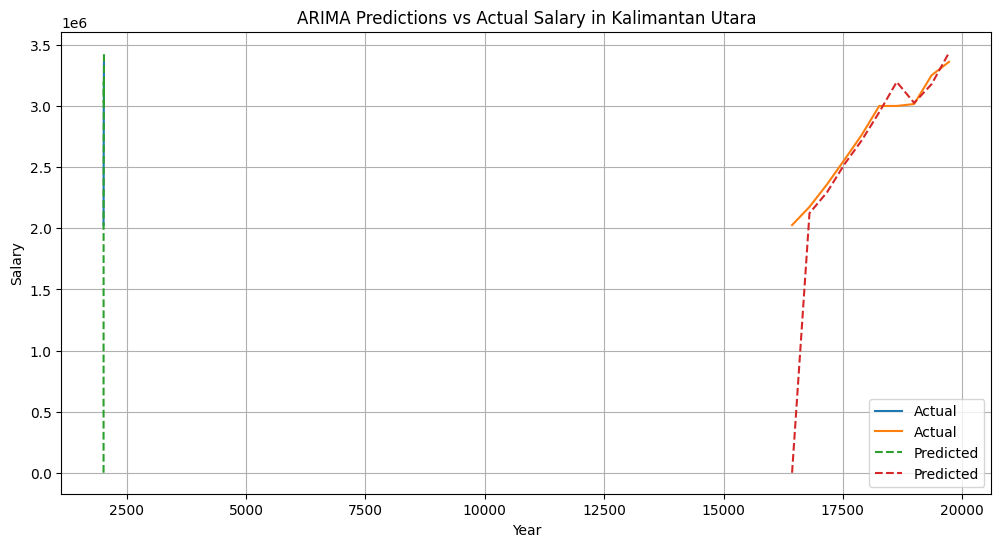

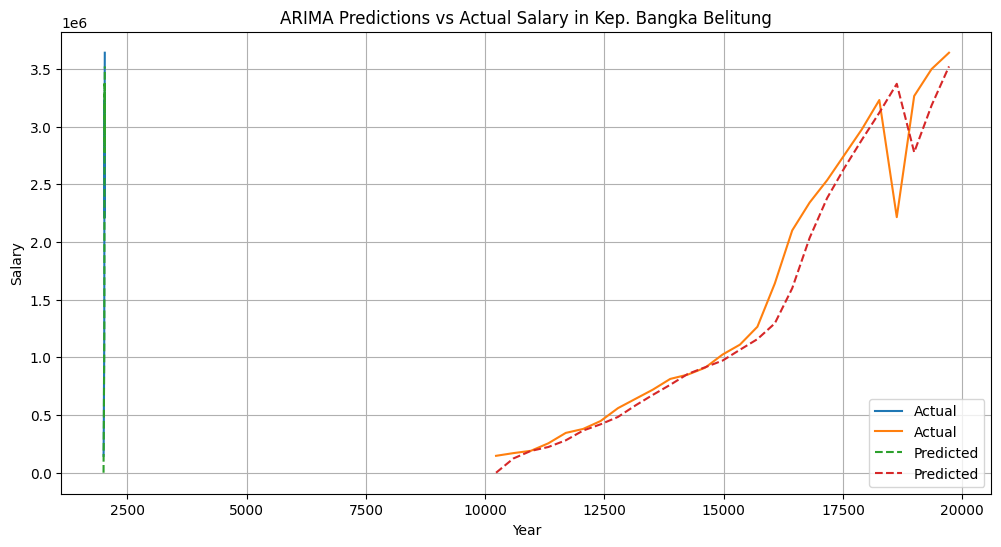

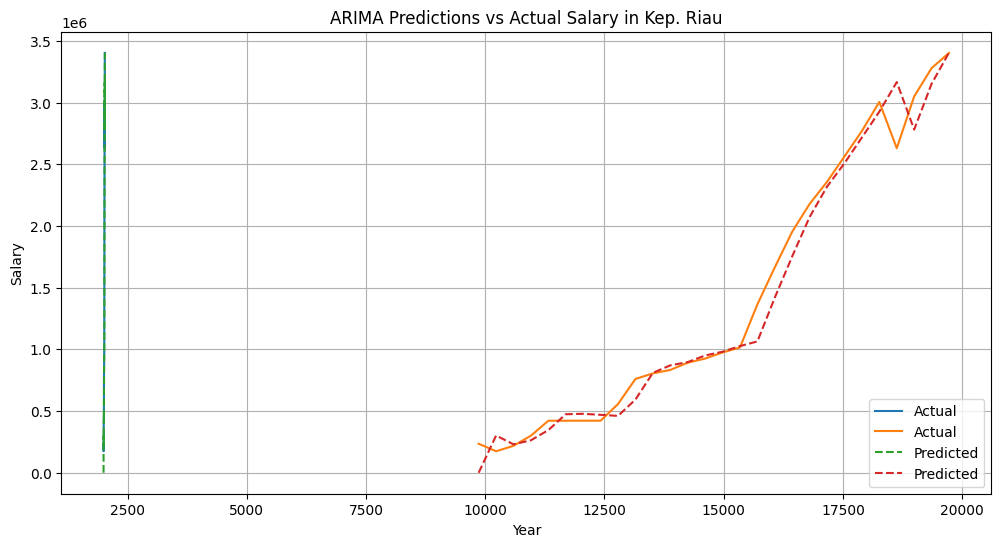

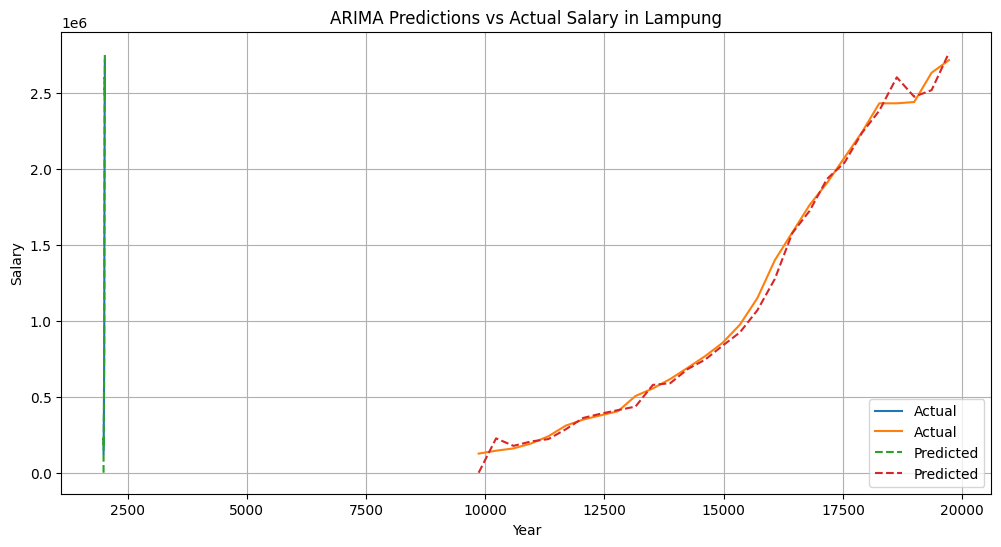

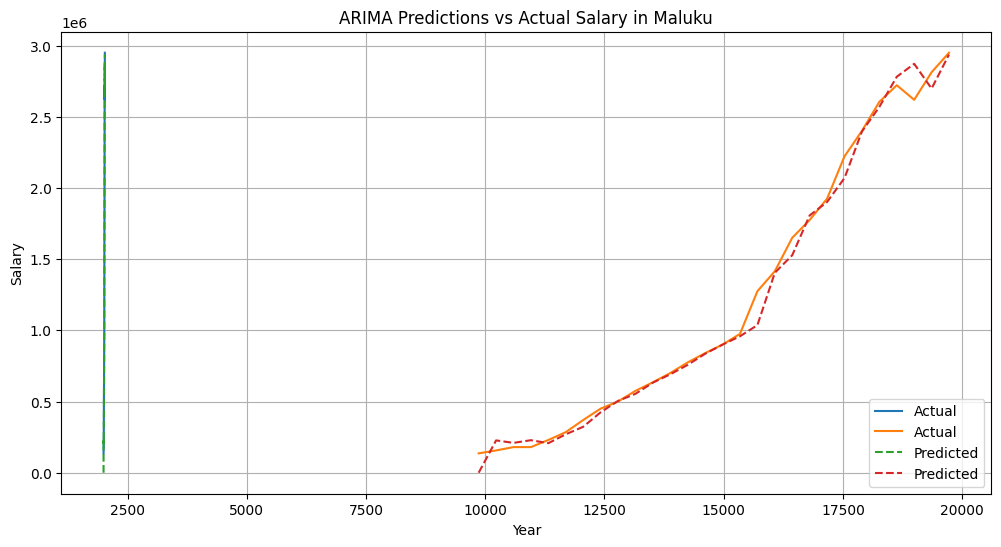

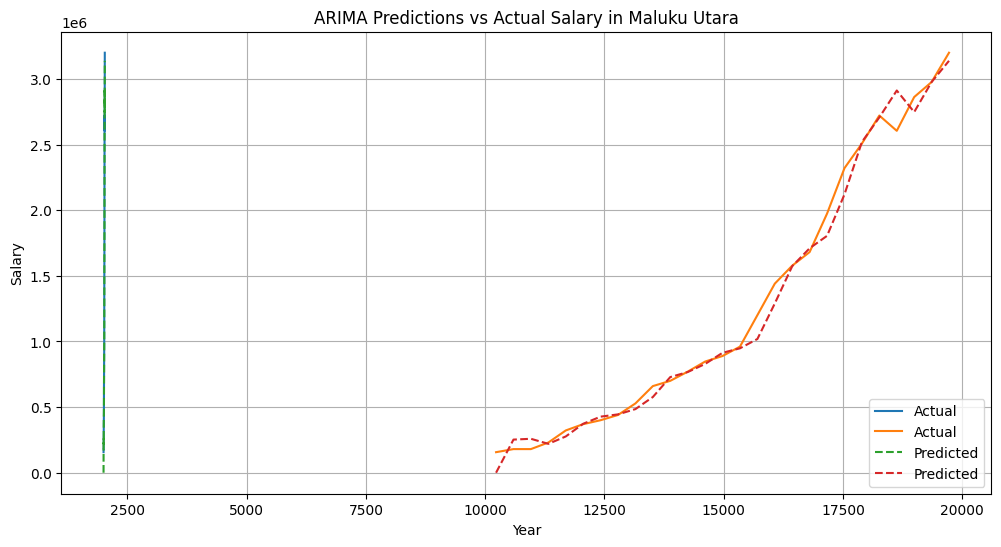

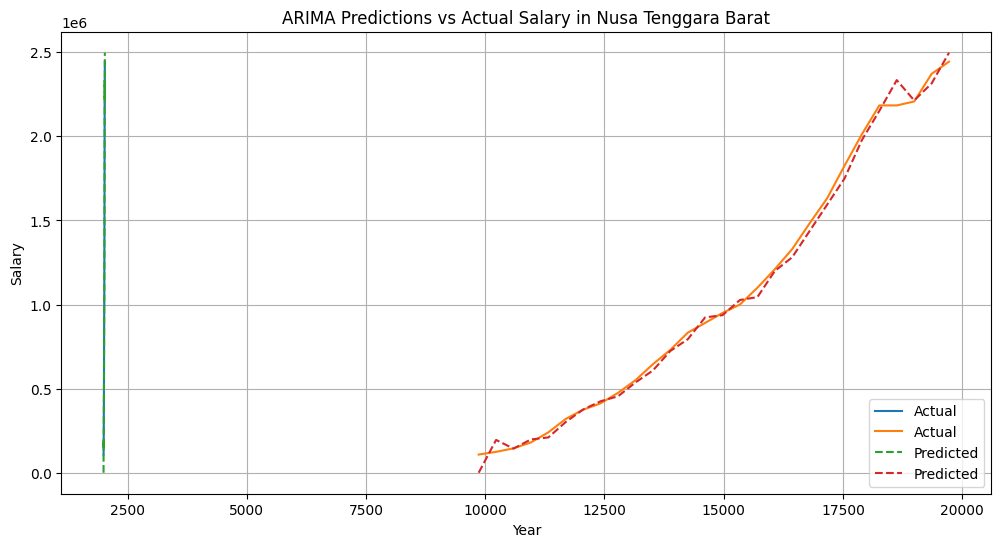

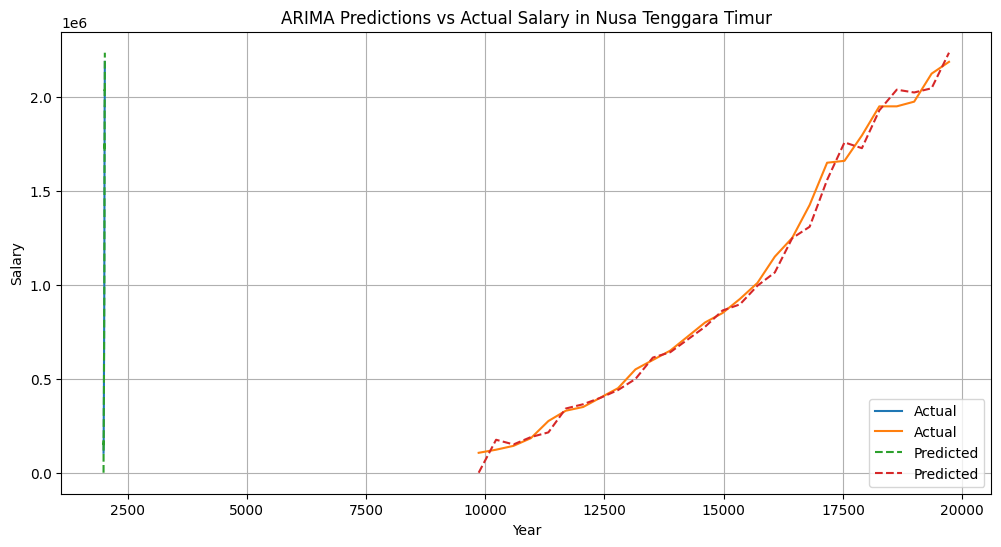

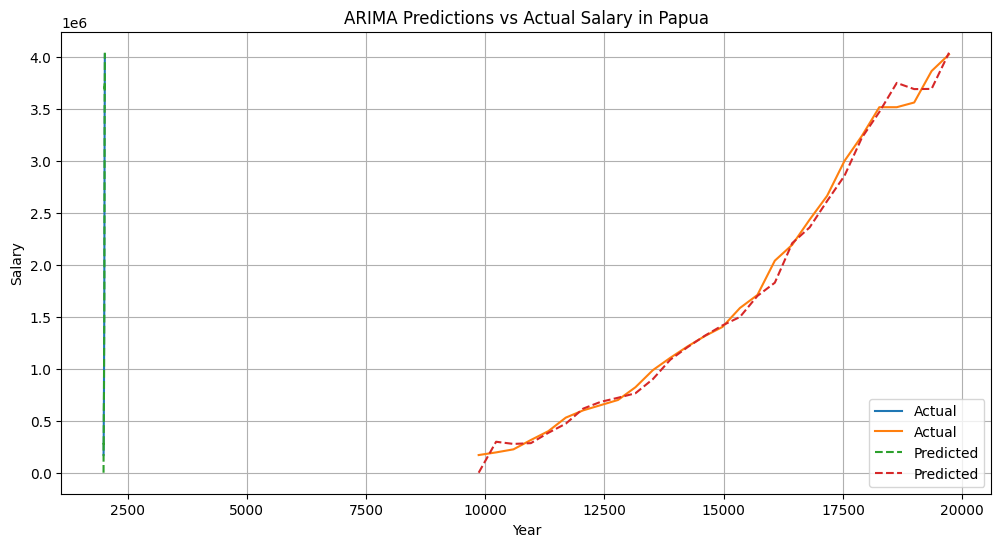

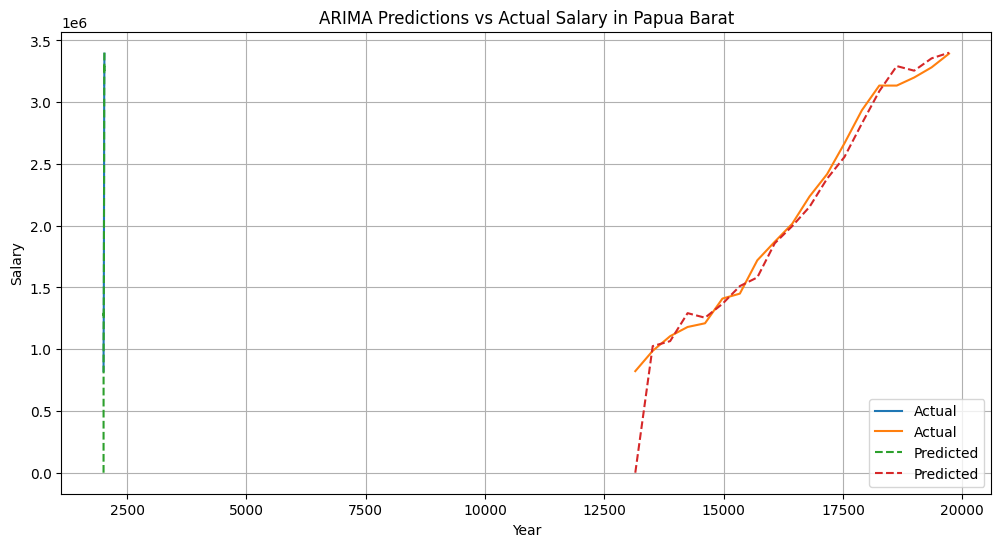

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [242]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Assuming 'df' is your dataset with 'REGION', 'YEAR', 'SALARY'

# Check for missing or duplicate values in the 'ds' column (previously 'YEAR')
print(df['ds'].isna().sum())  # Check for NaN values in the 'ds' column
print(df['ds'].duplicated().sum())  # Check for duplicates in the 'ds' column

# Drop rows with missing ds values (if any)
df = df.dropna(subset=['ds'])

# Drop duplicate rows if necessary
df = df.drop_duplicates(subset=['REGION', 'ds'])  # Use 'ds' instead of 'YEAR'

# Group by region
regions = df['REGION'].unique()  # Get unique regions
results = []

# Loop through each region
for region in regions:
    # Filter data for the current region
    df_region = df[df['REGION'] == region].copy()

    # 'ds' column should already be in datetime format from previous processing
    # If not, uncomment and run the following line:
    # df_region['ds'] = pd.to_datetime(df_region['ds'], format='%Y')

    # Rename columns as required by ARIMA (ds for date, y for value)
    df_region = df_region.rename(columns={'SALARY': 'y'})

    # Fit the ARIMA model (you can adjust (p, d, q) as needed for each region)
    model = ARIMA(df_region['y'], order=(2, 1, 2))  # Example order, adjust as needed
    model_fit = model.fit()

    # Make predictions on the entire dataset (for simplicity, we'll predict all years in the dataset)
    predictions = model_fit.predict(start=0, end=len(df_region)-1)

    # Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
    mae = mean_absolute_error(df_region['y'], predictions)
    mse = mean_squared_error(df_region['y'], predictions)

    # Store the results
    results.append({
        'Region': region,
        'MAE': mae,
        'MSE': mse,
        'Predictions': predictions,
        'Actual': df_region['y']
    })

    # Plot the actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(df_region['ds'], df_region['y'], label='Actual')  # Actual salaries
    plt.plot(df_region['ds'], predictions, label='Predicted', linestyle='--')  # Predicted salaries
    plt.title(f'ARIMA Predictions vs Actual Salary in {region}')
    plt.xlabel('Year')
    plt.ylabel('Salary')
    plt.legend()
    plt.grid(True)
    plt.show()

# Optionally, you can print the MAE and MSE for each region
for result in results:
    print(f"Region: {result['Region']}")
    print(f"Mean Absolute Error (MAE): {result['MAE']}")
    print(f"Mean Squared Error (MSE): {result['MSE']}")
    print("-" * 50)

ds    0
ds    0
dtype: int64
892


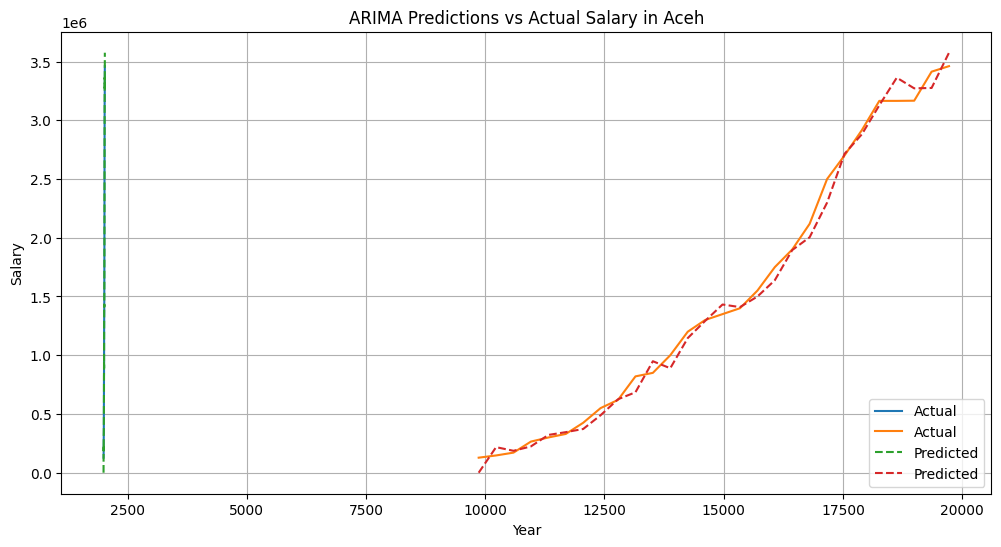

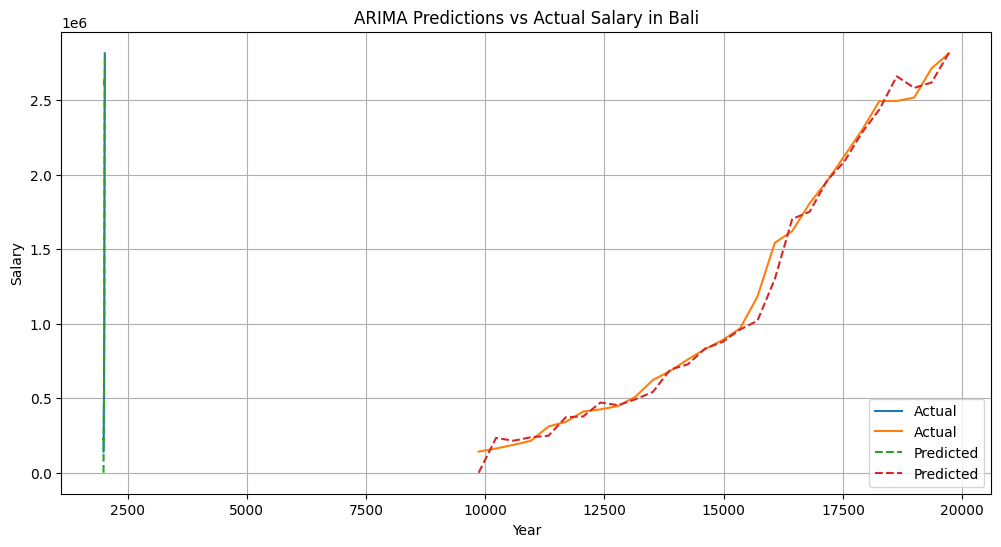

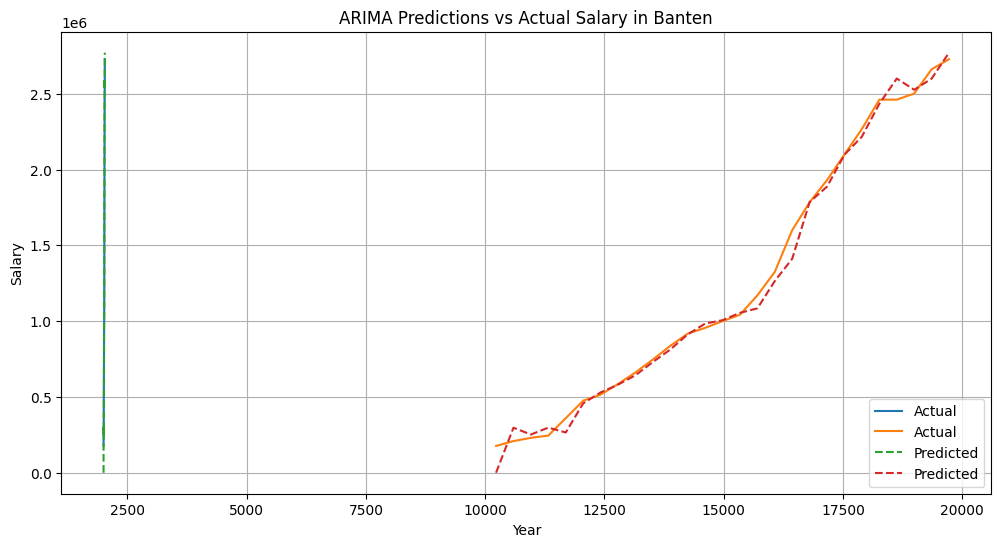

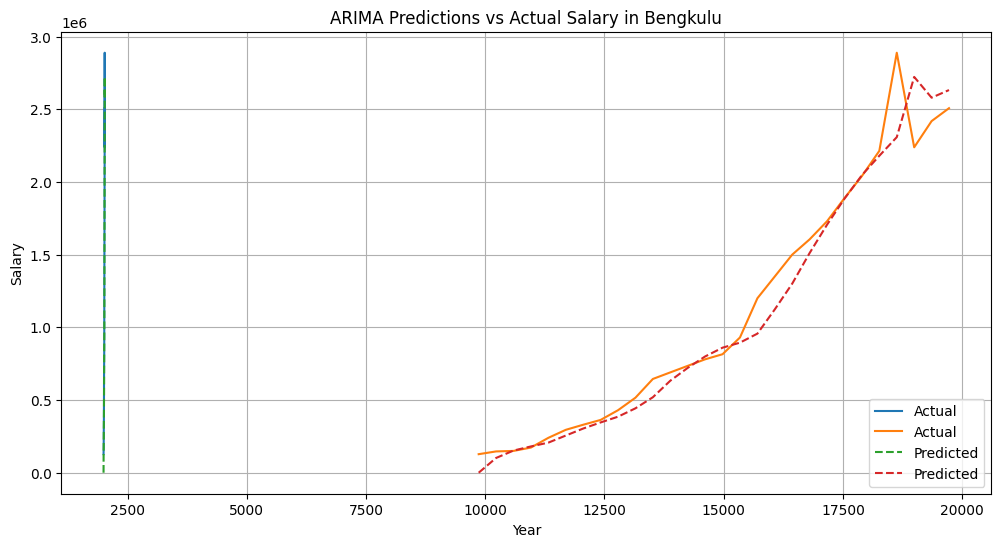

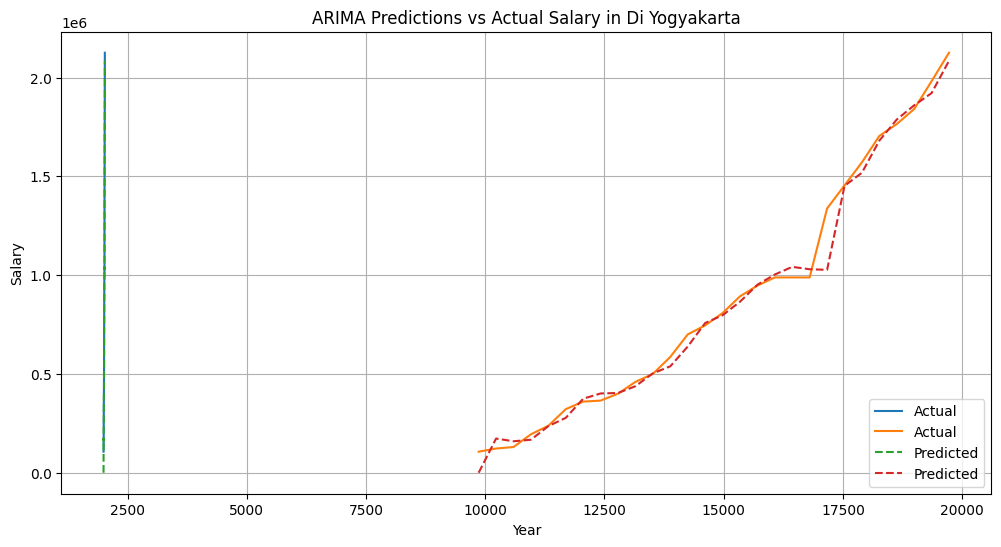

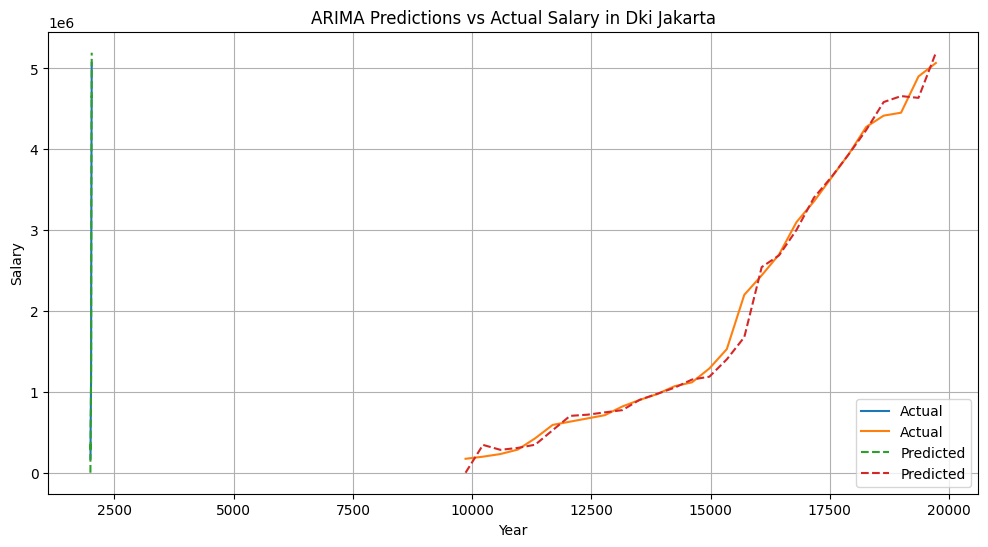

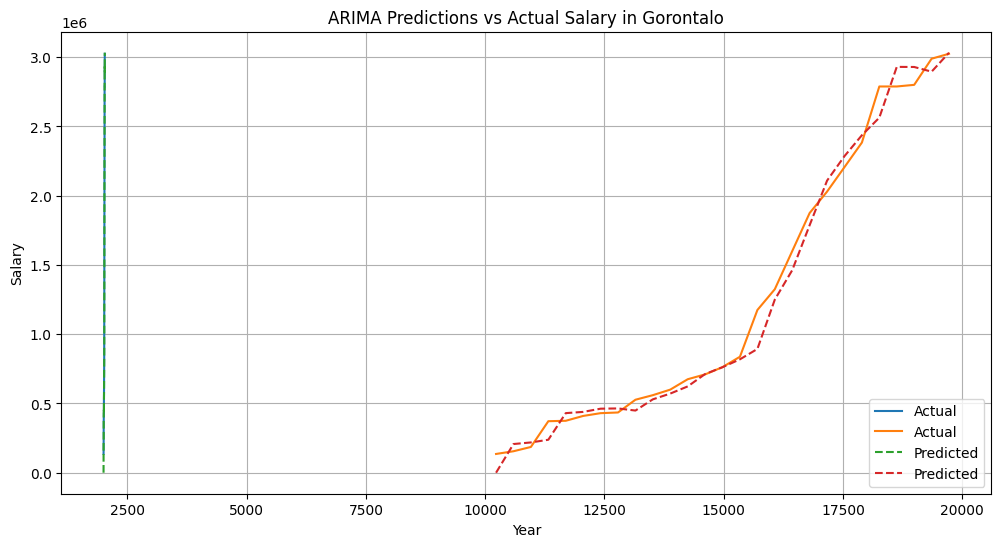

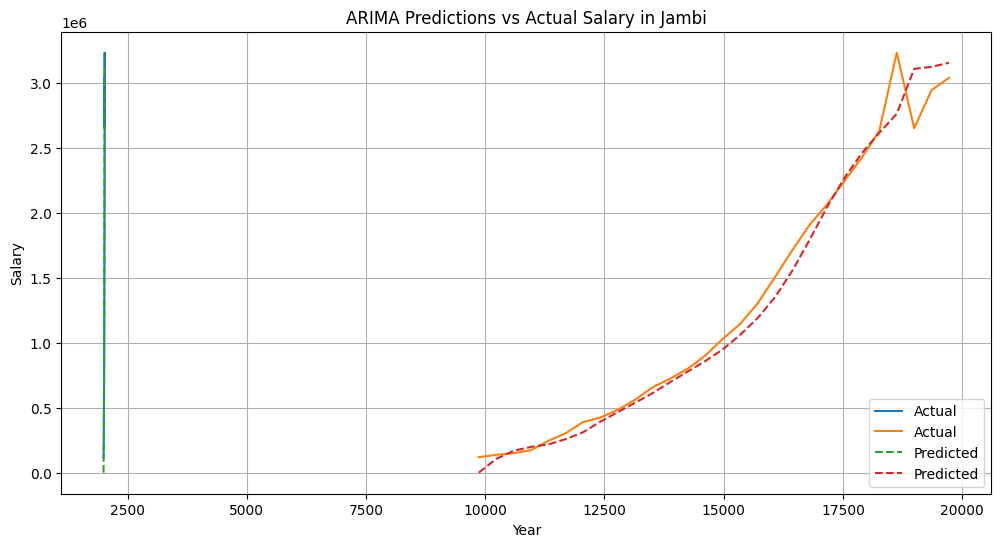

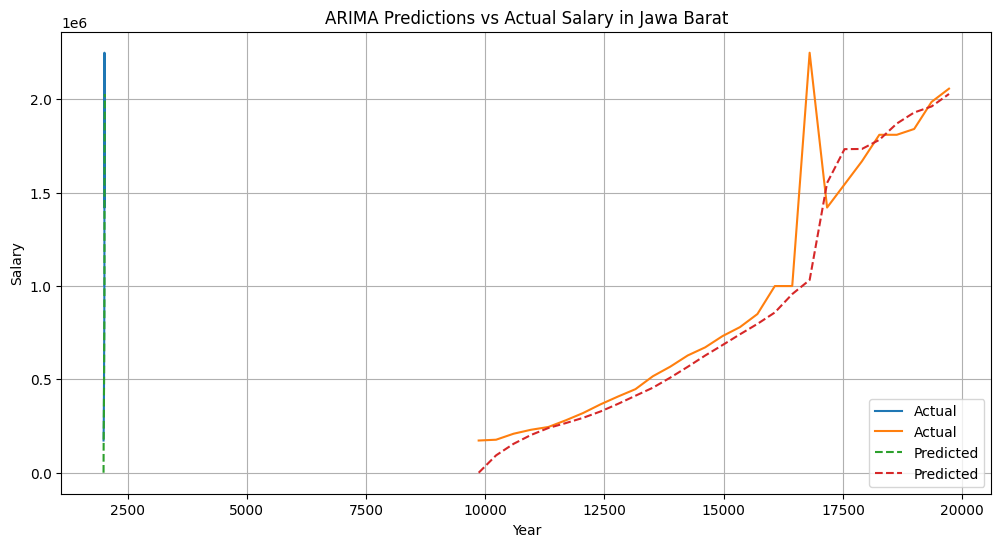

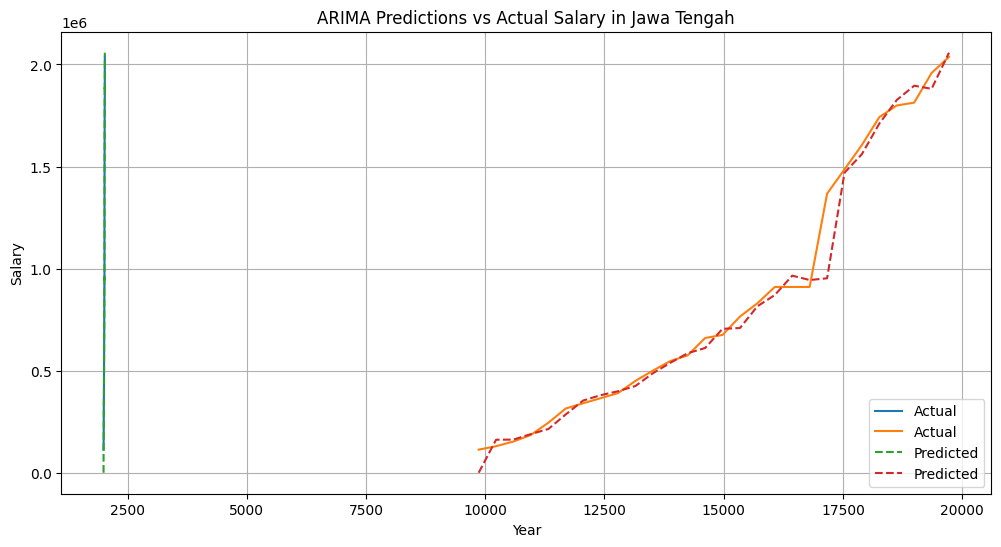

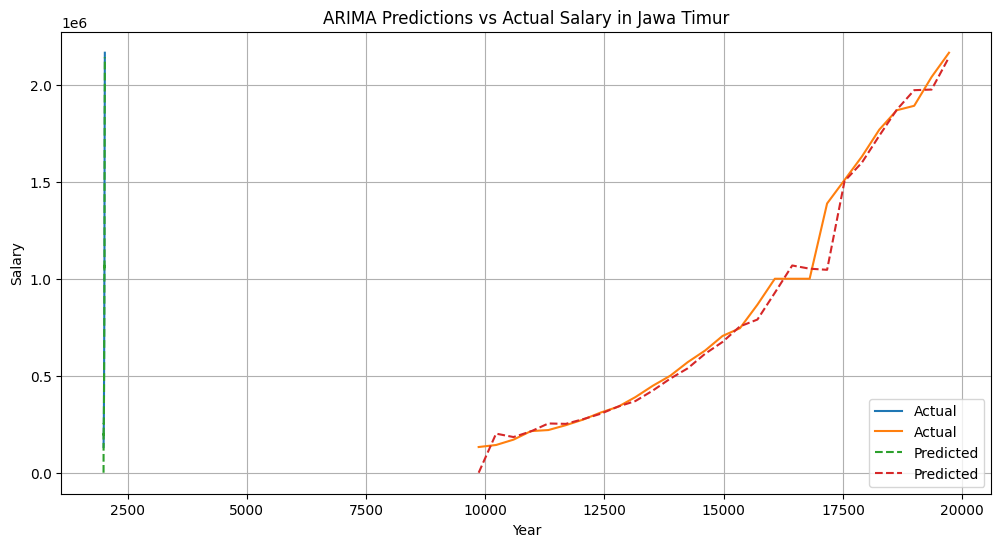

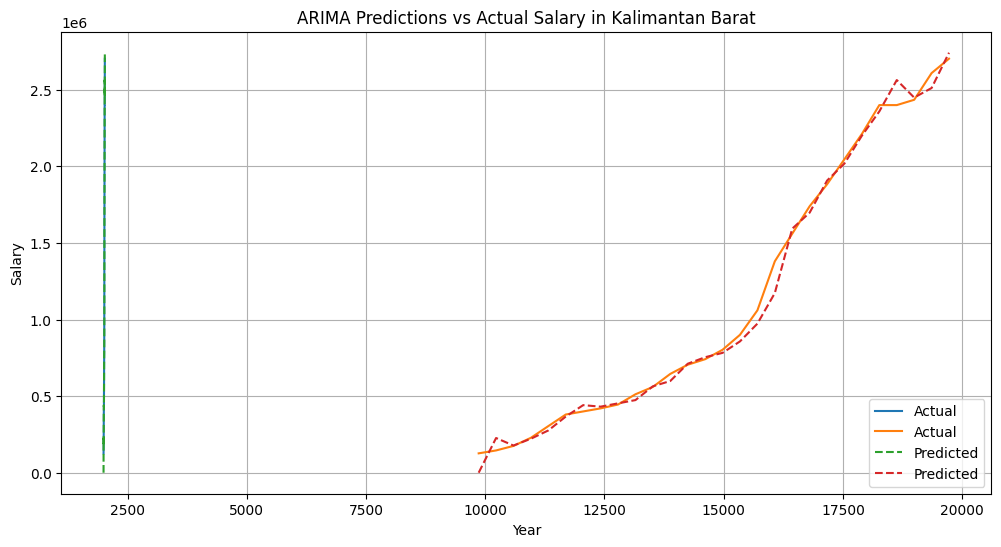

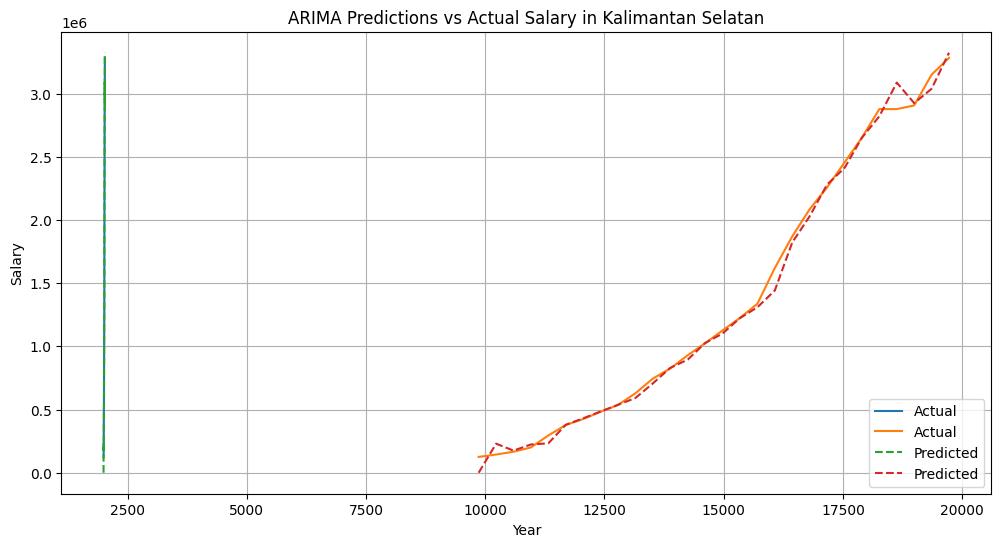

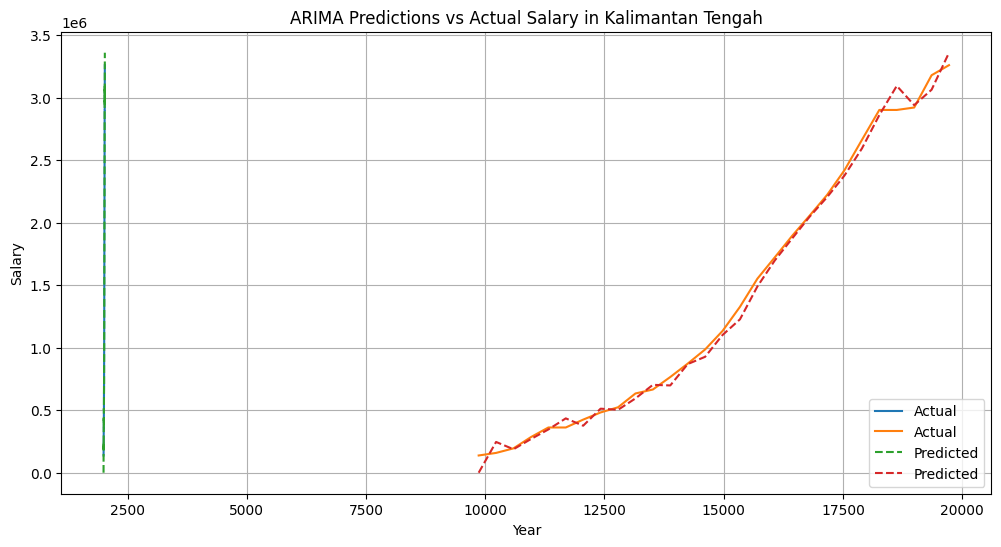

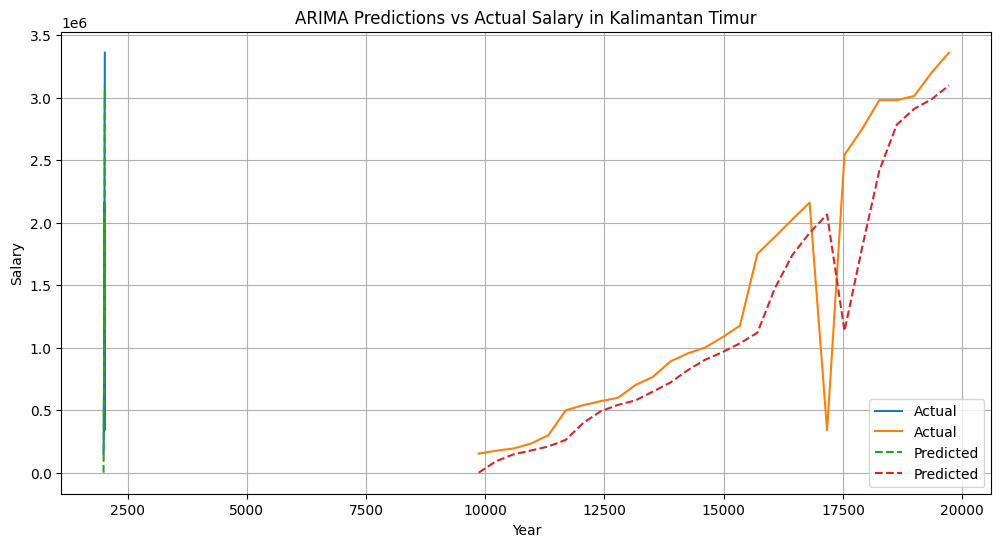

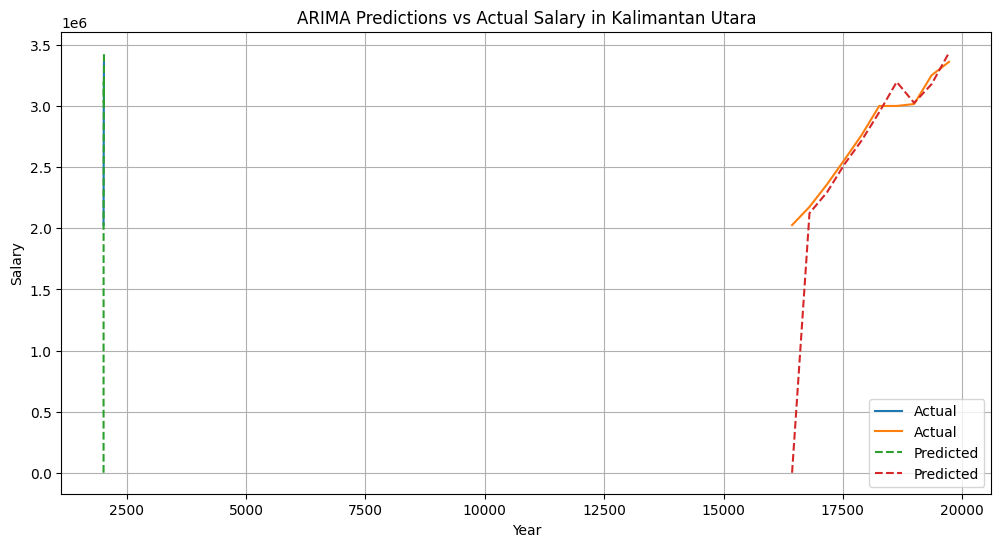

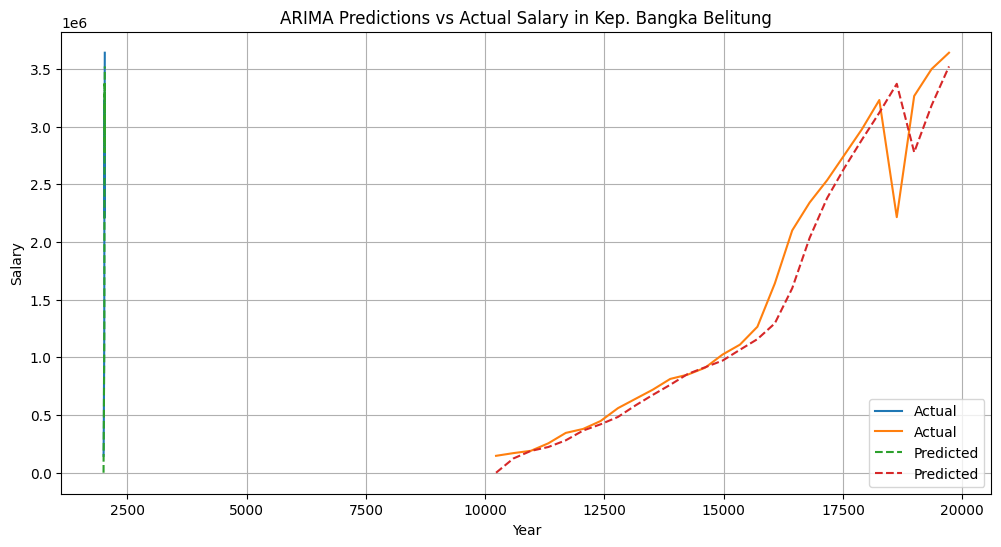

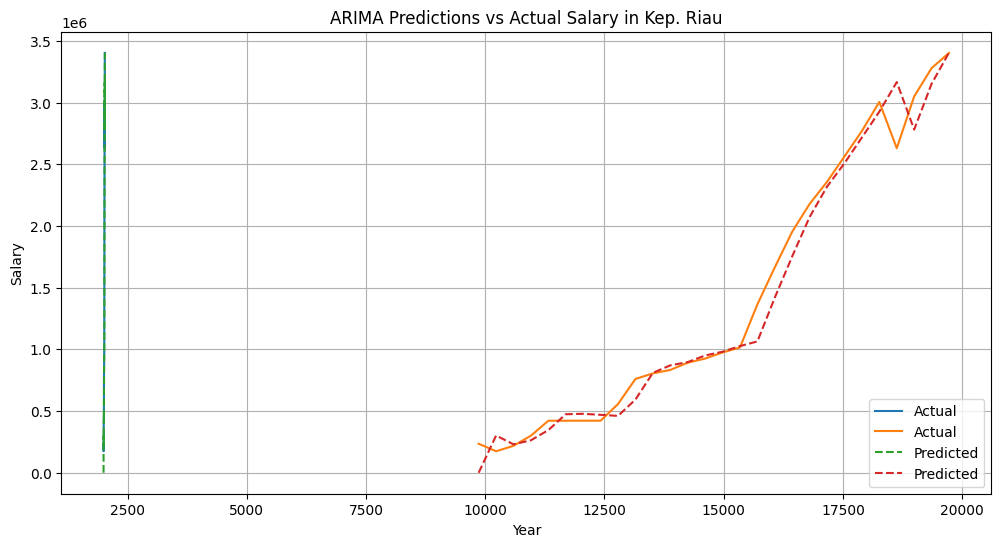

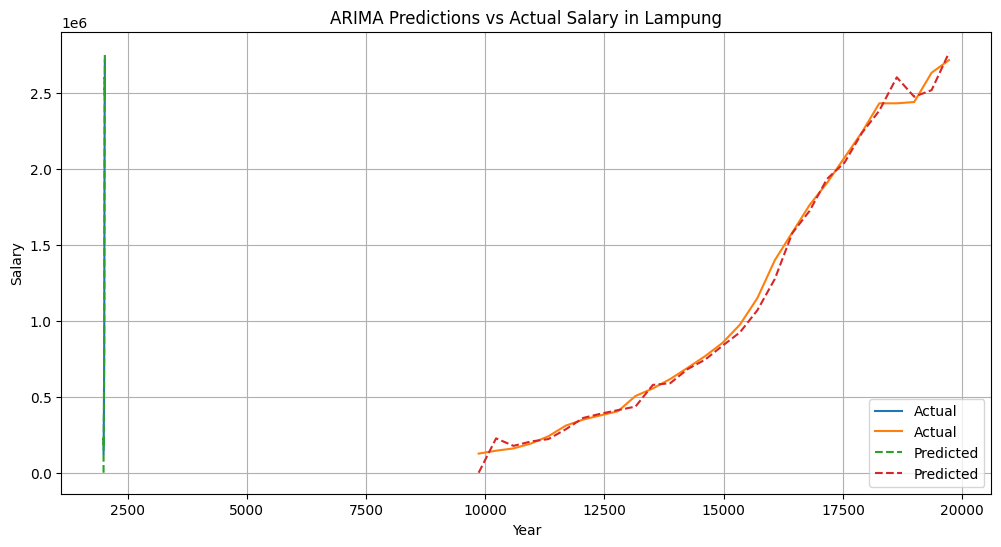

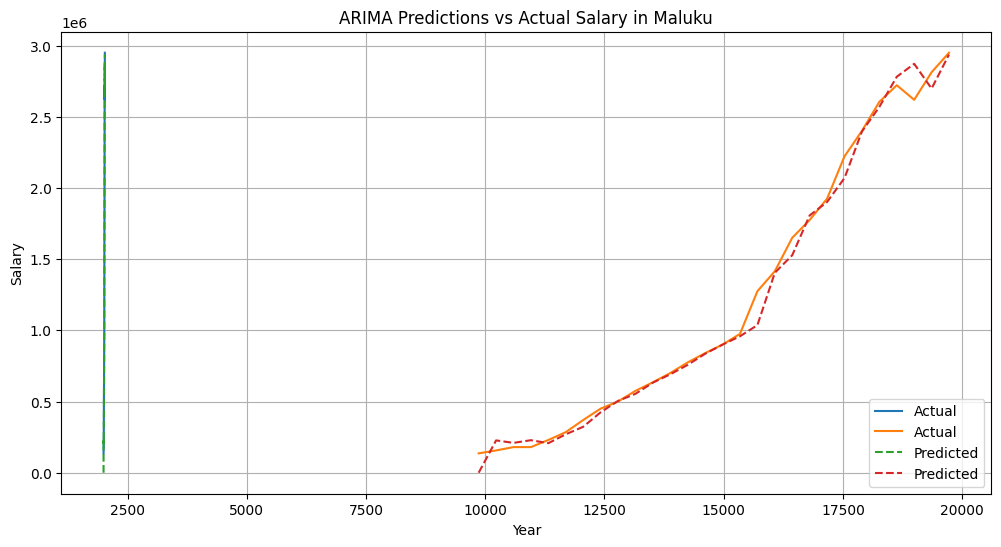

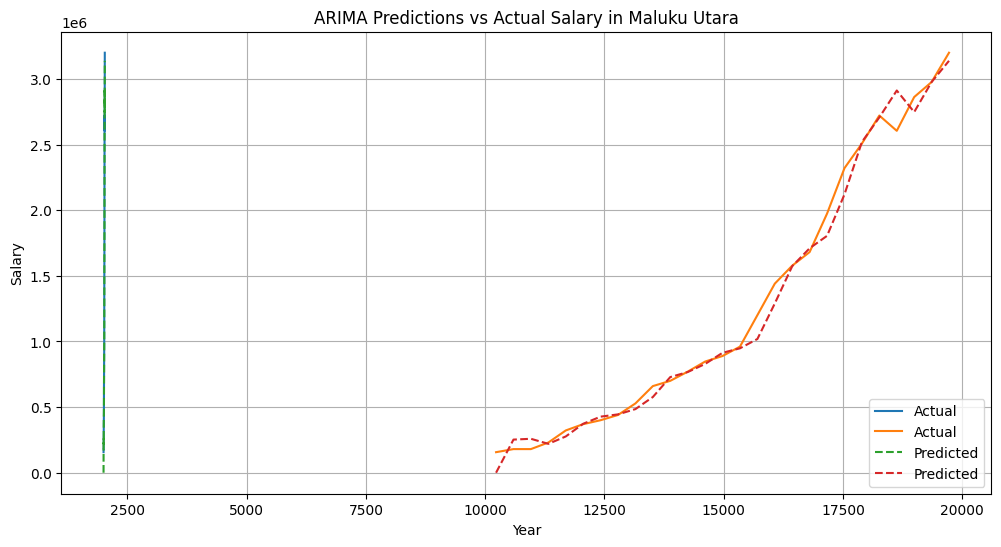

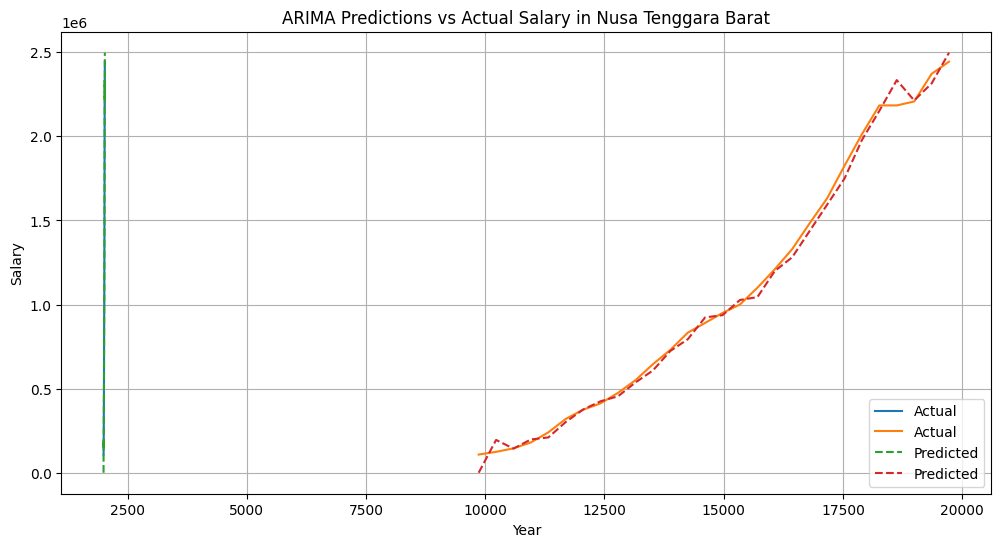

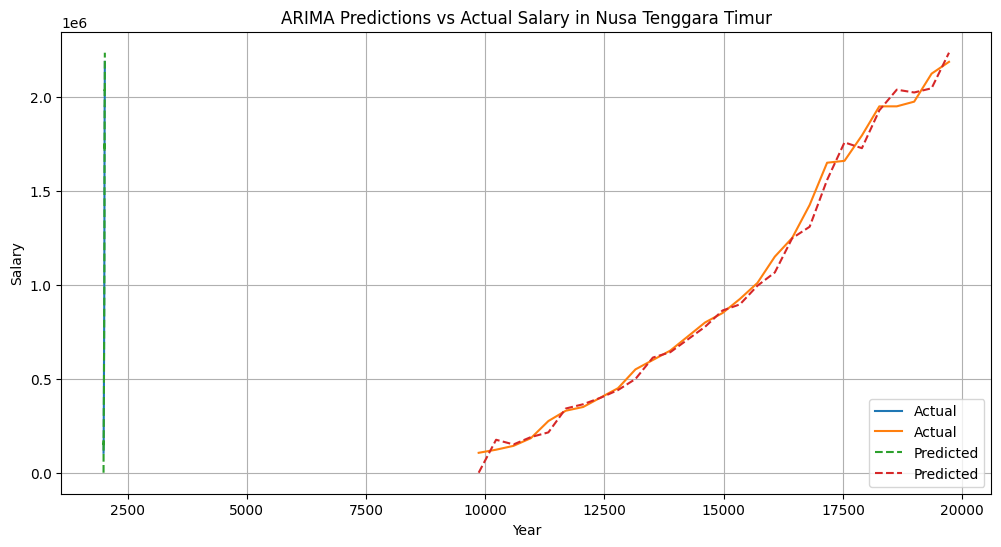

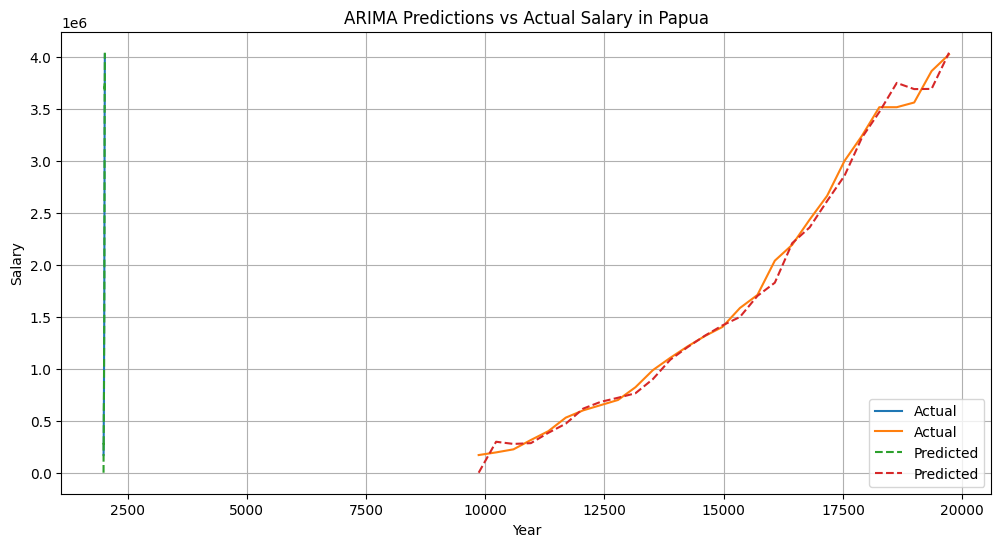

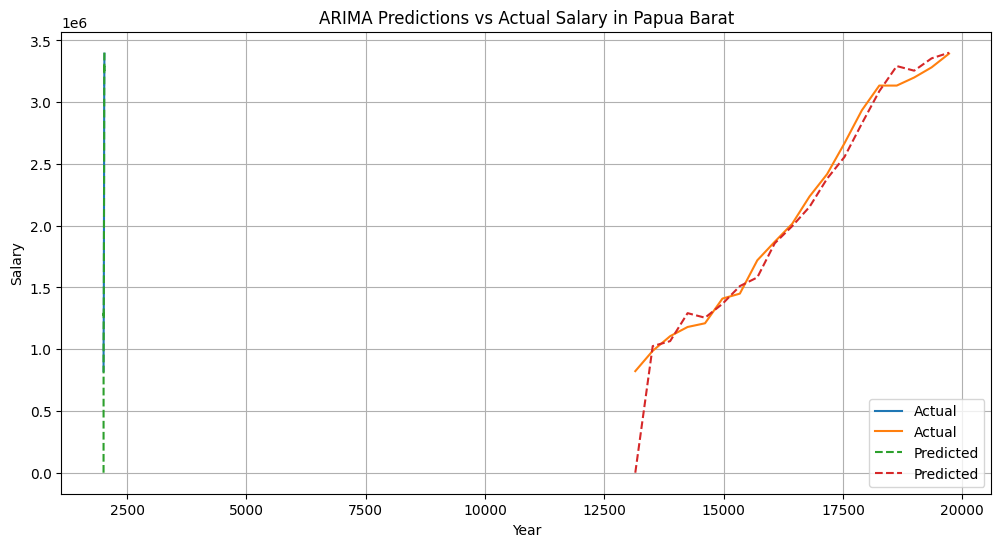

Skipping region Papua Barat Daya due to insufficient data.
Skipping region Papua Pegunungan due to insufficient data.
Skipping region Papua Selatan due to insufficient data.
Skipping region Papua Tengah due to insufficient data.


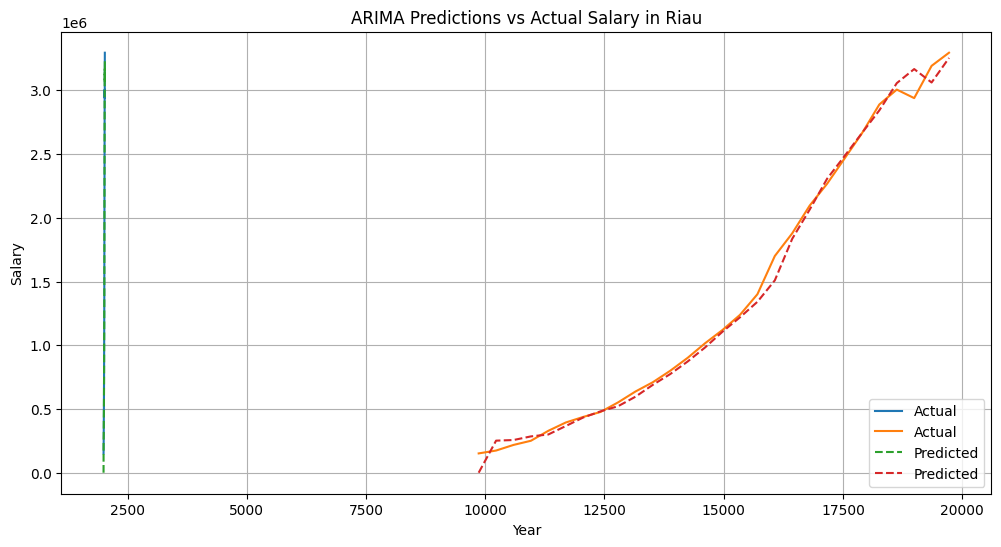

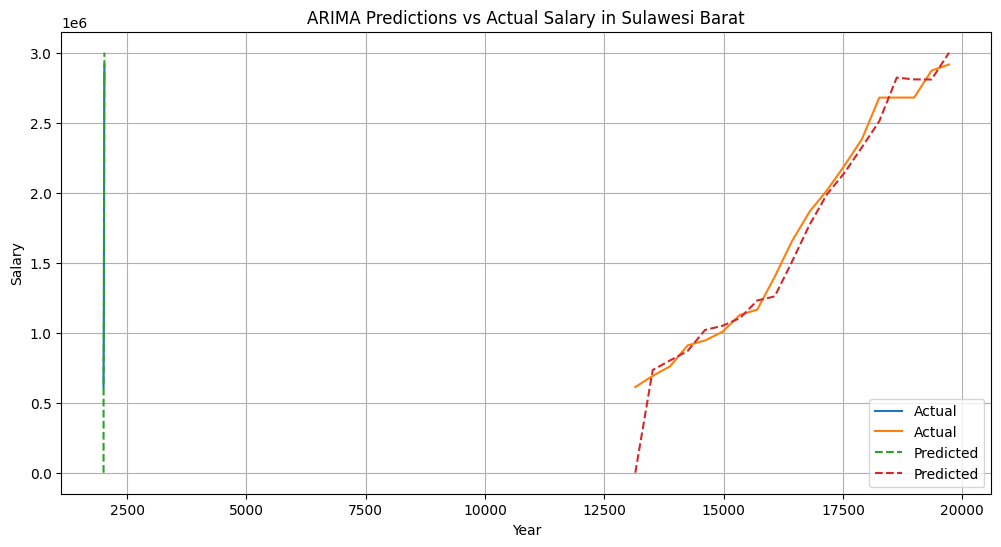

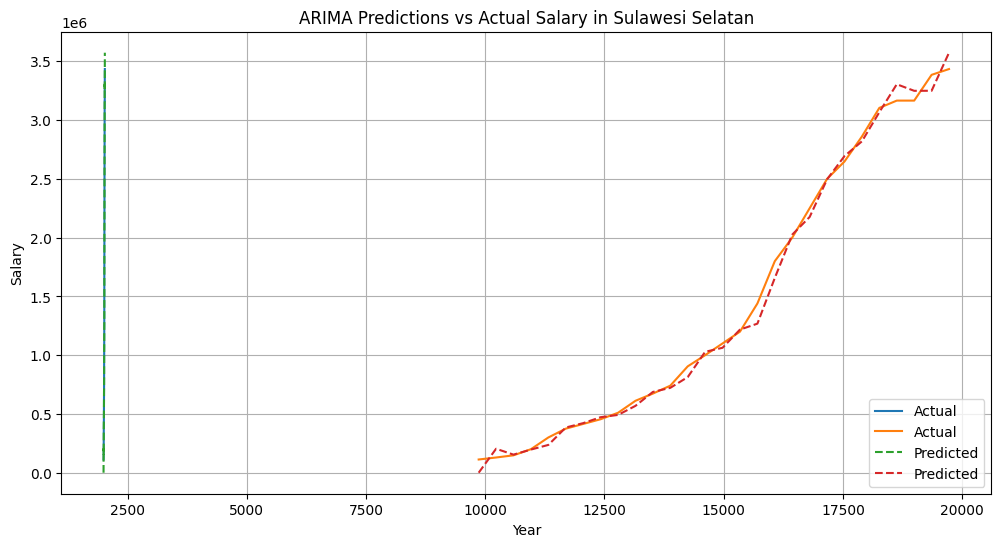

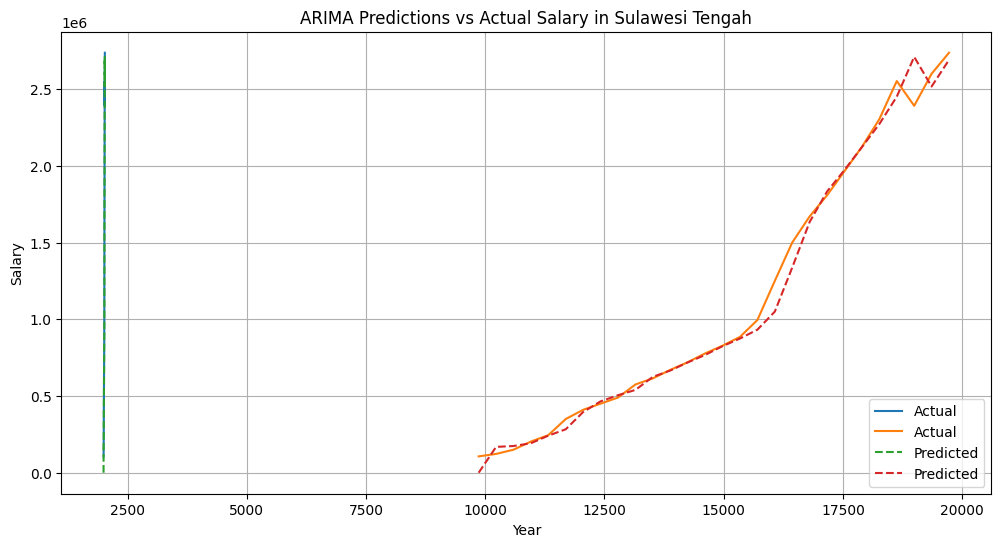

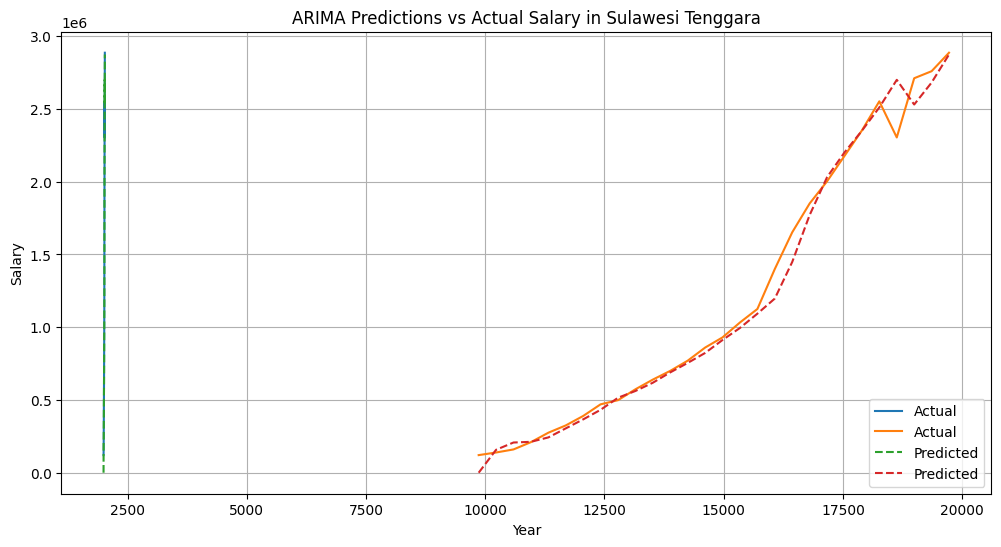

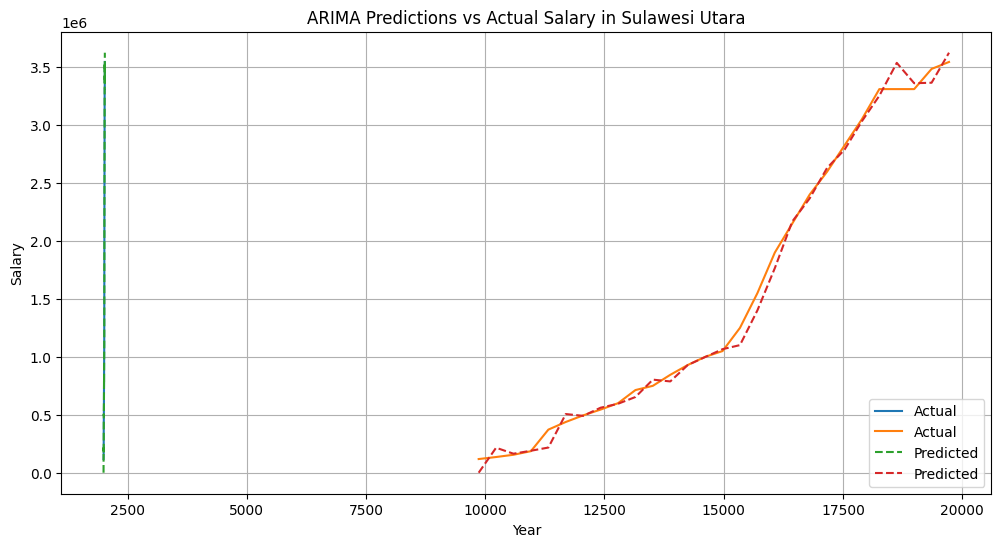

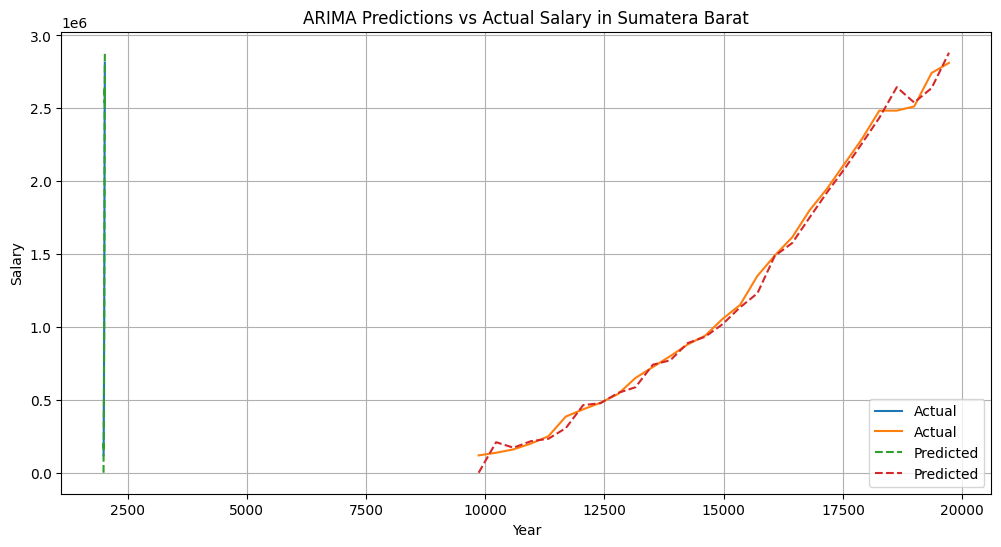

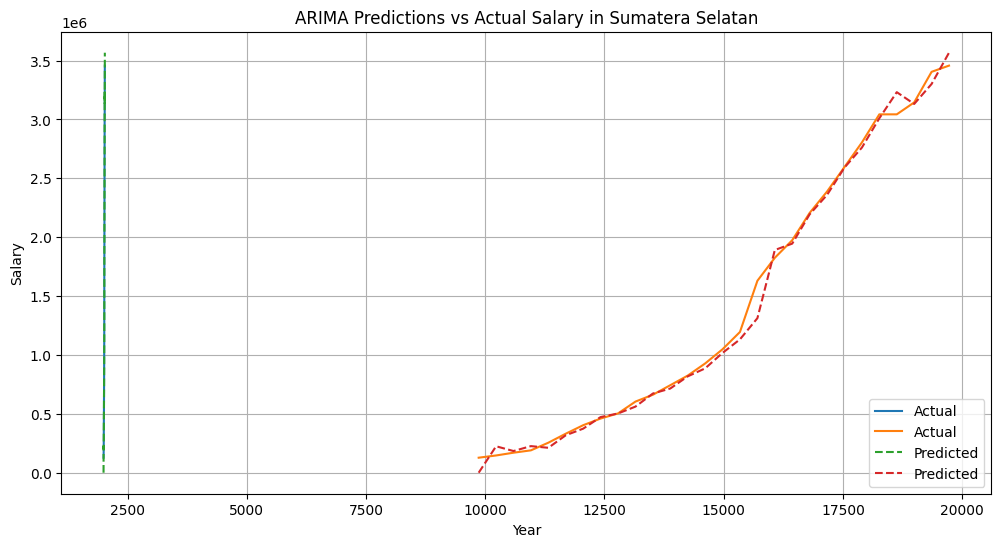

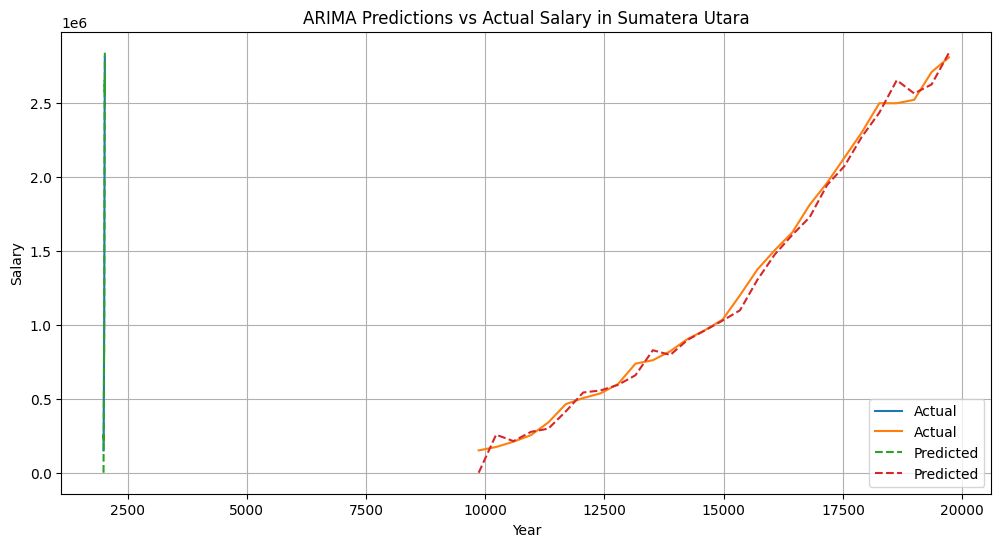

In [243]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Assuming 'df' is your dataset with 'REGION', 'YEAR', 'SALARY'

# Check for missing or duplicate values in the 'ds' column (previously 'YEAR')
print(df['ds'].isna().sum())  # Check for NaN values in the 'ds' column
print(df['ds'].duplicated().sum())  # Check for duplicates in the 'ds' column

# Drop rows with missing ds values (if any)
df = df.dropna(subset=['ds'])

# Drop duplicate rows if necessary
df = df.drop_duplicates(subset=['REGION', 'ds'])  # Use 'ds' instead of 'YEAR'

# Group by region
regions = df['REGION'].unique()  # Get unique regions
results = []

# Loop through each region
for region in regions:
    # Filter data for the current region
    df_region = df[df['REGION'] == region].copy()

    # 'ds' column should already be in datetime format from previous processing
    # If not, uncomment and run the following line:
    # df_region['ds'] = pd.to_datetime(df_region['ds'], format='%Y')

    # Rename columns as required by ARIMA (ds for date, y for value)
    df_region = df_region.rename(columns={'SALARY': 'y'})

    # Check if there's enough data for ARIMA
    if len(df_region) < 5:  # Adjust 5 if necessary based on your ARIMA order
        print(f"Skipping region {region} due to insufficient data.")
        continue  # Skip this region and go to the next one

    # Fit the ARIMA model (you can adjust (p, d, q) as needed for each region)
    model = ARIMA(df_region['y'], order=(2, 1, 2))  # Example order, adjust as needed
    model_fit = model.fit()

    # Make predictions on the entire dataset (for simplicity, we'll predict all years in the dataset)
    predictions = model_fit.predict(start=0, end=len(df_region)-1)

    # Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
    mae = mean_absolute_error(df_region['y'], predictions)
    mse = mean_squared_error(df_region['y'], predictions)

    # Store the results
    results.append({
        'Region': region,
        'MAE': mae,
        'MSE': mse,
        'Predictions': predictions,
        'Actual': df_region['y']
    })

    # Plot the actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(df_region['ds'], df_region['y'], label='Actual')  # Actual salaries
    plt.plot(df_region['ds'], predictions, label='Predicted', linestyle='--')  # Predicted salaries
    plt.title(f'ARIMA Predictions vs Actual Salary in {region}')
    plt.xlabel('Year')
    plt.ylabel('Salary')
    plt.legend()
    plt.grid(True)
    plt.show()

# Option